# Plot Cleaned Data and Estimated Occupancy
This note shows cleaned data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 14})

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import csv
import cv2

import os
import glob

import pdb

import statsmodels.api as sm

In [2]:

raw_sensor_data_files = glob.glob('raw_sensor_data_from_master_script_clean/*.csv')
raw_sensor_data_files.sort()
raw_sensor_data = {}
for file in raw_sensor_data_files:
    print('Loading: {}'.format(file))
    # 1. load sensro data
    raw_sensor_data[file] = pd.read_csv(file)
    

Loading: raw_sensor_data_from_master_script_clean/01_sensor_data__September_14_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/02_sensor_data__September_17_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/03_sensor_data__September_18_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/04_sensor_data__September_19_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/05_sensor_data__September_20_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/06_sensor_data__September_21_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/07_sensor_data__September_24_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/08_sensor_data__September_25_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/09_sensor_data__September_26_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/10_sensor_data__September_27_201

# Plot Data For Each Day

In [3]:
def separate_data_from_different_behavior(raw_sensor_data, date,
                                          experiment_schedule_table = 'experiment_schedule_table.csv'):
    """
    Args:
        raw_sensor_data (pd.DataFrame): sensor data collect in one day
        experiment_schedule_table (string): file name of experiment schedule table which contains schedule of 
            each day's experiments in where:
                0: Prescribed_Behavior
                1: Parameterized_Learning_Agent
                2: Single_Agent_Raw_Act
                3: Agent_Community_Raw_Act
    Return:
        separated_data (dict): key is the phase name, and value is the data.
        phase_code (dict): key is the phase name, and value is the phase code.
    """
    # read experiment schedule file and retrive the schedule of date
    experiment_schedule = pd.read_csv(experiment_schedule_table)
    phaseschedule = experiment_schedule.loc[experiment_schedule['Date'] == date]
    # read schedule code in each interaction phase
    phase_1pm_2pm_code = phaseschedule['1pm-2pm'].values
    phase_2pm_2_30pm_code = phaseschedule['2pm-2:30pm'].values
    phase_2_30pm_3pm_code = phaseschedule['2:30pm-3pm'].values
    phase_3pm_4pm_code = phaseschedule['3pm-4pm'].values
    # separate data
    date, time = raw_sensor_data['timestamp'][0].split(' ')
    
    phase_1pm_2pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:00:00')]
    phase_2pm_2_30pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:30:00')]
    phase_2_30pm_3pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:30:00') & (raw_sensor_data['timestamp'] <= date+' '+'15:00:00')]
    phase_3pm_4pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'15:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'16:00:00')]
    
    phase_data = {}
    phase_code = {}
    # combine phase with the same phase_code
    if (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2_30pm_3pm_code == phase_3pm_4pm_code):
        phase_data['phase_1pm_2_30pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data])
        phase_data['phase_2_30pm_4pm'] = pd.concat([phase_2_30pm_3pm_data, phase_3pm_4pm_data])
        
        phase_code['phase_1pm_2_30pm'] = phase_1pm_2pm_code
        phase_code['phase_2_30pm_4pm'] = phase_2_30pm_3pm_code
    elif (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code) and (phase_1pm_2pm_code != phase_2pm_2_30pm_code):
        phase_data['phase_2pm_3pm'] = pd.concat([phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_1pm_2pm'] = phase_1pm_2pm_data
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_2pm_3pm'] = phase_2pm_2_30pm_code
        phase_code['phase_1pm_2pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    elif (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code):
        phase_data['phase_1pm_3pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_1pm_3pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    else:
        print('phase_1pm_2pm_code:{} phase_2pm_2_30pm_code:{}  phase_2_30pm_3pm_code: {} phase_3pm_4pm_code:{}'.format(phase_1pm_2pm_code,phase_2pm_2_30pm_code,phase_2_30pm_3pm_code,phase_3pm_4pm_code))
        raise Exception('Check {} to spot the error.'.format(experiment_schedule_table))
    
    return phase_data, phase_code

def estimated_occupancy_of_date(date):
    """
    Args:
        date (string): 'Sep_xx' or 'Oct_xx'
    Returns:
        camera1_occupancy (pd.DataFrame): estimated occupancy from camera1 on date
        camera2_occupancy (pd.DataFrame): estimated occupancy from camera2 on date
    """
    occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
    files_camera1 = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
    files_camera2 = glob.glob(os.path.join(occupancy_dir_camera2, date, '*.csv'))
    camera1_occupancy = pd.DataFrame()
    camera2_occupancy = pd.DataFrame()
    camera1_temp = {}
    camera2_temp = {}
    for f_camera1 in files_camera1:
        if '1300_1400' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1300_1400'] = pd.read_csv(f_camera1)
        if '1400_1430' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1430'] = pd.read_csv(f_camera1)
        if '1430_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1430_1500'] = pd.read_csv(f_camera1)
        if '1400_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1500'] = pd.read_csv(f_camera1)
        if '1500_1600' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1500_1600'] = pd.read_csv(f_camera1)
    for f_camera2 in files_camera2:
        if '1300_1400' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1300_1400'] = pd.read_csv(f_camera2)
        if '1400_1430' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1430'] = pd.read_csv(f_camera2)
        if '1430_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1430_1500'] = pd.read_csv(f_camera2)
        if '1400_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1500'] = pd.read_csv(f_camera2)
        if '1500_1600' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1500_1600'] = pd.read_csv(f_camera2)
    if not camera1_temp:
        print('Camera1 on {}: empty'.format(date))
    else:
        keys = list(camera1_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera1_temp[keys[i-1]]['Time'][-1:].values[0]
            camera1_temp[key]['Time'] = camera1_temp[key]['Time']+time_shift
        camera1_occupancy = pd.concat([camera1_temp[k] for k in keys], ignore_index=True)
        
    if not camera2_temp:
        print('Camera2 on {}: empty'.format(date))
    else:
        keys = list(camera2_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera2_temp[keys[i-1]]['Time'][-1:].values[0]
            camera2_temp[key]['Time'] = camera2_temp[key]['Time']+time_shift
        camera2_occupancy = pd.concat([camera2_temp[k] for k in keys], ignore_index=True)
        
    return camera1_occupancy, camera2_occupancy

def plot_reward_signal_and_estimated_occupancy(raw_sensor_data, filename):
    """
    Args:
        raw_sensor_data (pd.DataFrame): the data
        filename (string): the name of the date file
    """
    
    
    # Separate data from different behavior
    _, date = filename.split('_2018')[0].split('sensor_data__')
    print(date)
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data, date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    print('Separate data done!')
    
    # plot reward data
    fig = plt.figure()
    fig.suptitle('Reward and Estimated Occupancy on {}'.format(date))
    grid = plt.GridSpec(6, 1, hspace=0, wspace=0.2)
    main_ax = fig.add_subplot(grid[0:2, :])
    occupancy_ax_camera1 = fig.add_subplot(grid[4:5, :])
    occupancy_ax_camera2 = fig.add_subplot(grid[5:6, :], sharey=occupancy_ax_camera1)
    legend_label = []
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            color = 'k'
            legend_label.append('Prescribed_Behavior')
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            color = 'r'
            legend_label.append('Parameterized_Learning_Agent')
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            color = 'b'
            legend_label.append('Single_Agent_Raw_Act')
        else:                             # Agent_Community_Raw_Act
            color = 'g'
            legend_label.append('Agent_Community_Raw_Act')
        time_series = pd.to_datetime(phase_data[phase_name]['timestamp'])
        main_ax.plot(time_series, phase_data[phase_name]['reward_IR_distance'], color = color, lw=1, alpha=0.8)
    main_ax.legend(legend_label)
    main_ax.set_xlabel('time')
    main_ax.set_ylabel('reward')
    main_ax.set_ylim(0, 3)
    main_ax.set_yticks(np.arange(0, 3.1, 0.5))
    #main_ax.set_title('Reward and Estimated Occupancy on {}'.format(date))
    main_ax.grid(True, linestyle=':')
    main_ax.tick_params(axis='x', rotation=10)
    # Set scond x-axis
    ax2 = main_ax.twiny()
    ax2.plot(np.arange(len(raw_sensor_data)), np.zeros(len(raw_sensor_data)))
    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.spines['bottom'].set_position(('outward', 40))
    ax2.set_xticks(np.arange(0,len(raw_sensor_data), 10000))
    ax2.tick_params(axis='x', rotation=10)
    ax2.set_xlabel('step')
    
    # TODO: plot estimated occupancy
    legend_label.append('Estimated_Occupancy')
    subdir = date.replace('September', 'Sep')
    subdir = subdir.replace('October', 'Oct')
    camera1_occupancy, camera2_occupancy = estimated_occupancy_of_date(subdir)    
    occupancy_legend_label = []
    if not camera1_occupancy.empty:
        occupancy_ax_camera1.plot(camera1_occupancy['Time']/(1000*60), camera1_occupancy['Occupancy'], color='fuchsia')
    else:
        occupancy_ax_camera1.plot(np.zeros(180))
    
    if not camera2_occupancy.empty:
        occupancy_ax_camera2.plot(camera2_occupancy['Time']/(1000*60), camera2_occupancy['Occupancy'], color='aqua')
    else:
        occupancy_ax_camera2.plot(np.zeros(180))
    occupancy_ax_camera1.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera1.tick_params(bottom='off',labelbottom='off')
    occupancy_ax_camera1.legend(['Occupancy_Camera1'])
    occupancy_ax_camera2.legend(['Occupancy_Camera2'])
    occupancy_ax_camera2.set_xlabel('time [m]')
    occupancy_ax_camera2.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera2.set_ylabel('Occupancy',position=(0,1))
    occupancy_ax_camera1.set_yticks(np.arange(0,25,5))
    occupancy_ax_camera1.set_ylim(0,25)
    #occupancy_ax_camera1.set_ylabel('Occupancy')
    #occupancy_ax_camera1.set_title('Occupancy Estimated from Camera1 and Camera2')
    occupancy_ax_camera1.grid(True)
    occupancy_ax_camera2.grid(True)
    #pdb.set_trace()

    plt.tight_layout()

September_14
Separate data done!


<IPython.core.display.Javascript object>


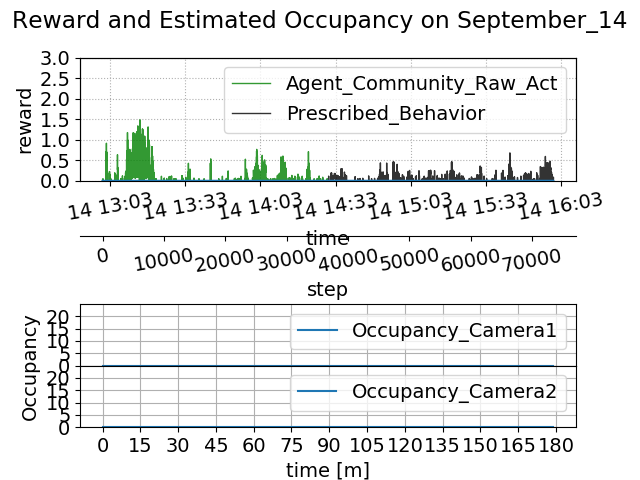

Camera1 on Sep_14: empty
Camera2 on Sep_14: empty
September_17
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


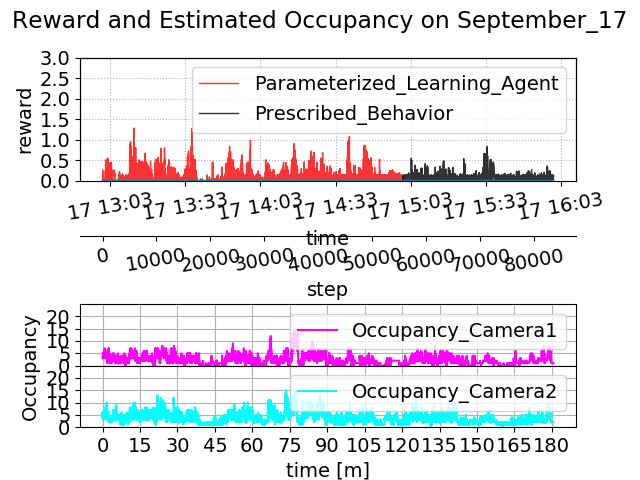

September_18
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


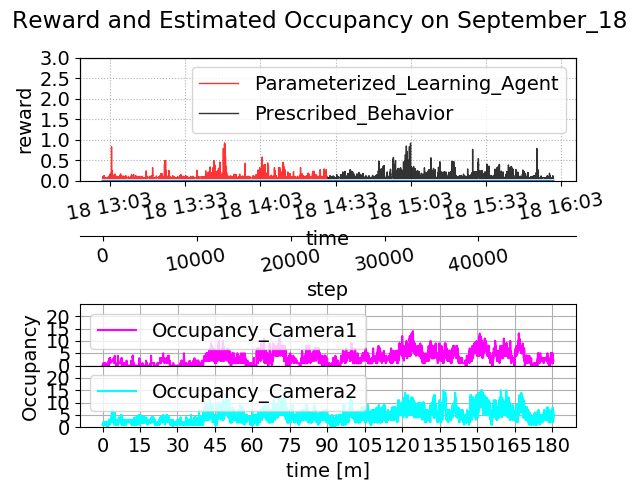

September_19
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


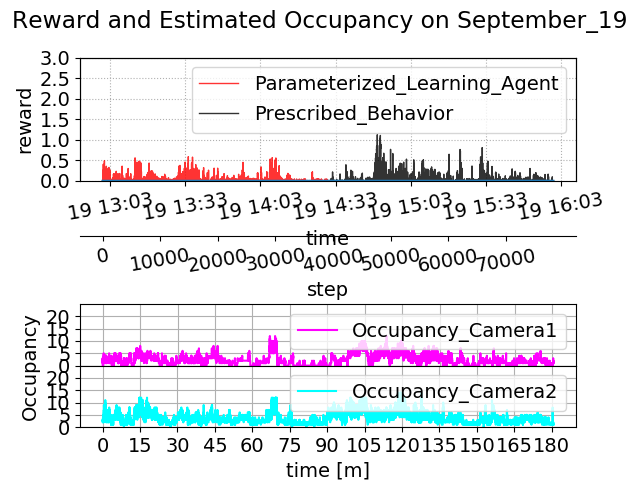

September_20
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


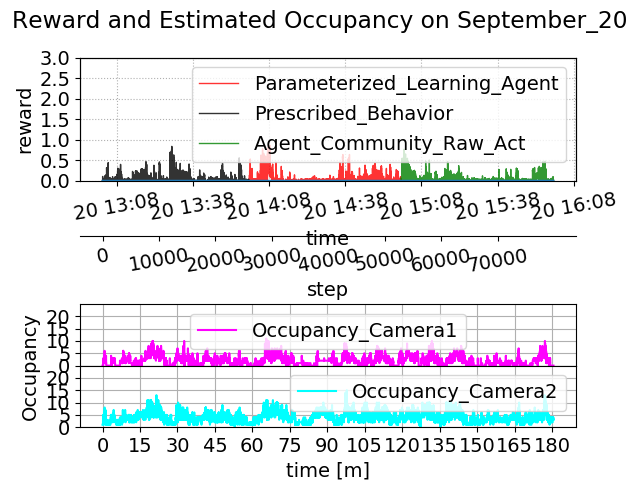

September_21
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


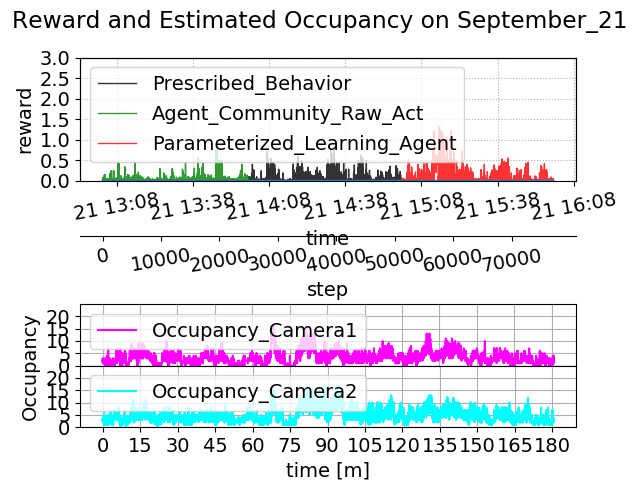

September_24
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


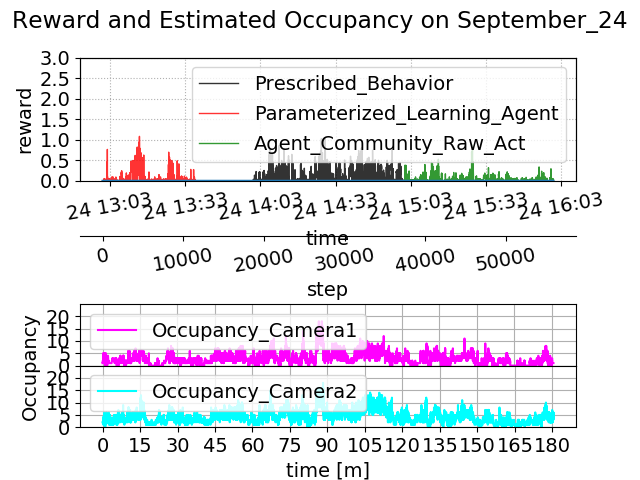

September_25
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


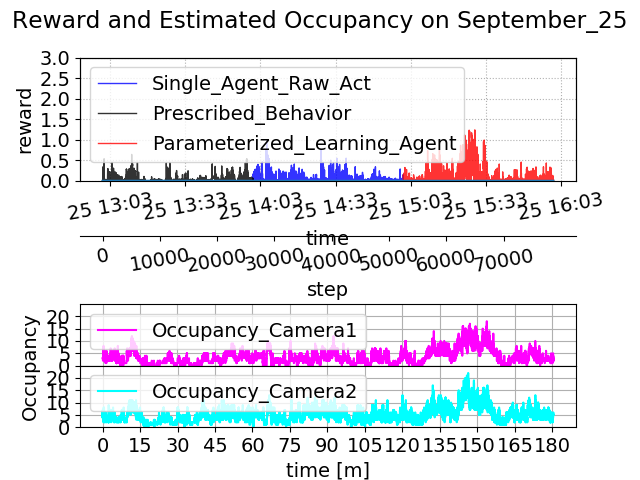

September_26
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


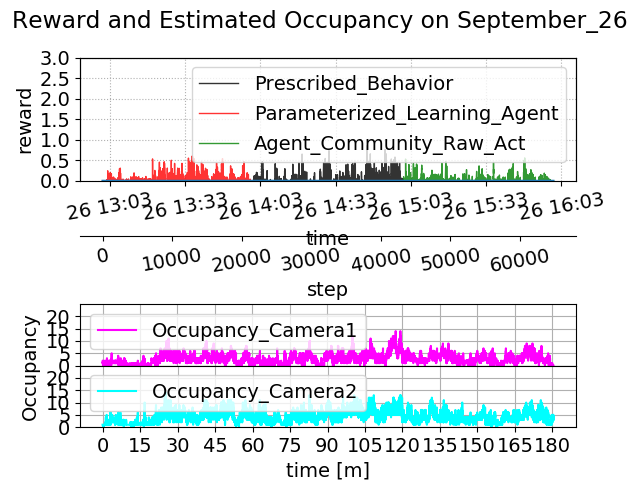

September_27
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


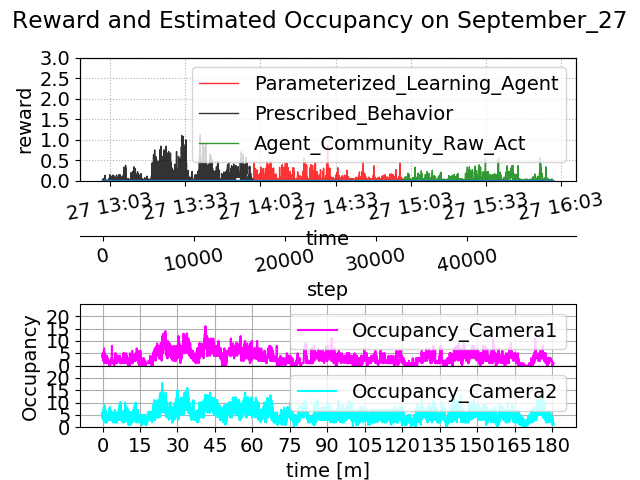

September_28
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


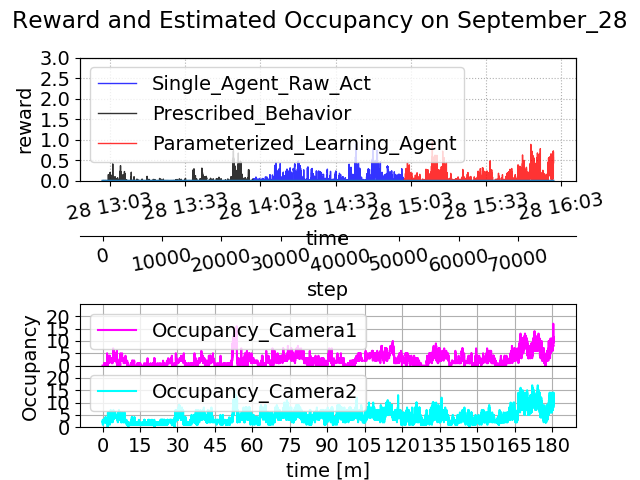

October_02
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


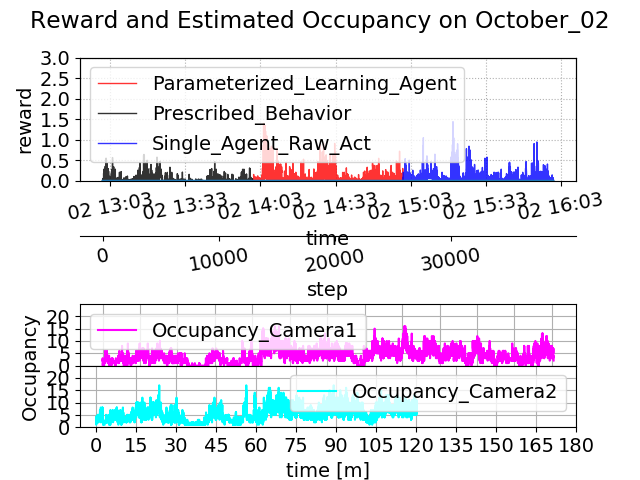

October_03
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


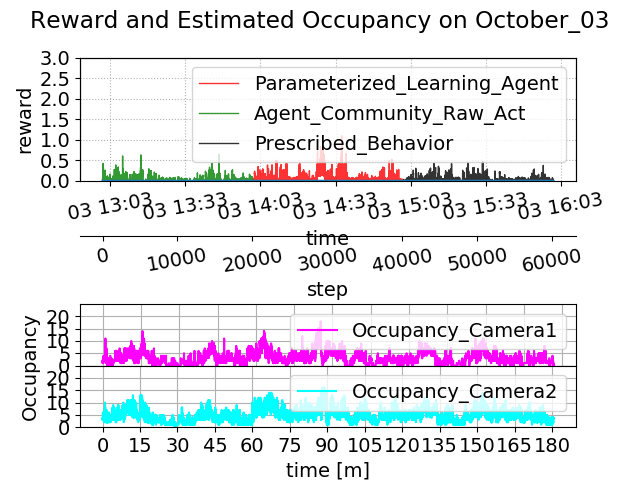

October_05
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


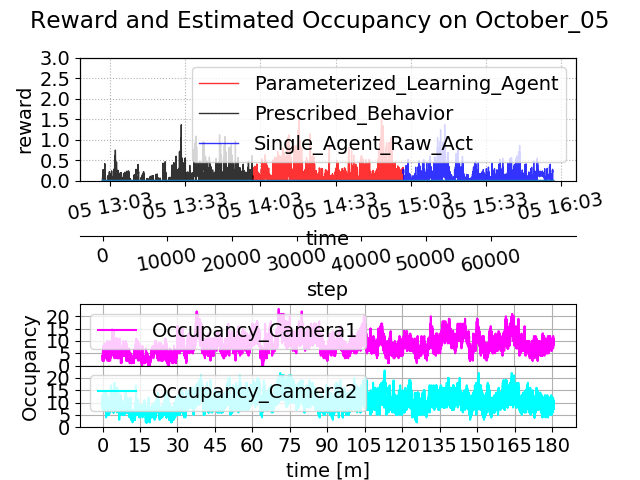

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [4]:
for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    plot_reward_signal_and_estimated_occupancy(raw_sensor_data[file], filename)

## Concate Data from the Same Behavior Mode

In [5]:
prescribed_behavior = {}
prescribed_behavior['data'] = pd.DataFrame()
prescribed_behavior['separate_line'] = []
prescribed_behavior['date'] = []

para_learning_agent = {}
para_learning_agent['data'] = pd.DataFrame()
para_learning_agent['separate_line'] = []
para_learning_agent['date'] = []

single_agent_raw_act = {}
single_agent_raw_act['data'] = pd.DataFrame()
single_agent_raw_act['separate_line'] = []
single_agent_raw_act['date'] = []

agent_coummunity_raw_act = {}
agent_coummunity_raw_act['data'] = pd.DataFrame()
agent_coummunity_raw_act['separate_line'] = []
agent_coummunity_raw_act['date'] = []

for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data[file], date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    if 'September'in date:
        date = date.replace('September','Sep')
    elif 'October' in date:
        date = date.replace('October','Oct')
    else:
        pass
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], phase_data[phase_name]])
            prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
            prescribed_behavior['date'].append(date)
        
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            para_learning_agent['data'] = pd.concat([para_learning_agent['data'], phase_data[phase_name]])
            para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
            para_learning_agent['date'].append(date)
        
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], phase_data[phase_name]])
            single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
            single_agent_raw_act['date'].append(date)
        
        elif phase_code[phase_name] == 3: # Agent_Community_Raw_Act
            agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], phase_data[phase_name]])
            agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
            agent_coummunity_raw_act['date'].append(date)
        else:                             # Dirty data
            pass

## Concate Estimated Occupancy from the Same Behavior Mode

In [6]:
date_sequence = ['Sep_14', 'Sep_17', 'Sep_18', 'Sep_19', 'Sep_20', 'Sep_21', 'Sep_24', 
                 'Sep_25', 'Sep_26', 'Sep_27', 'Sep_28', 'Oct_02', 'Oct_03', 'Oct_05']
date_sequence

['Sep_14',
 'Sep_17',
 'Sep_18',
 'Sep_19',
 'Sep_20',
 'Sep_21',
 'Sep_24',
 'Sep_25',
 'Sep_26',
 'Sep_27',
 'Sep_28',
 'Oct_02',
 'Oct_03',
 'Oct_05']

In [7]:
def concate_occupancy_from_the_same_behavior_mode(occupancy_dir, date_sequence):
    """
    Args:
        occupancy_dir (string):
        date_sequence (list):
    Returns:
        prescribed_behavior (dict):
        para_learning_agent (dict):
        single_agent_raw_act (dict):
        agent_coummunity_raw_act (dict):
    """
    occupancy_dir = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    
    prescribed_behavior = {}
    prescribed_behavior['data'] = pd.DataFrame()
    prescribed_behavior['separate_line'] = []
    prescribed_behavior['date'] = []

    para_learning_agent = {}
    para_learning_agent['data'] = pd.DataFrame()
    para_learning_agent['separate_line'] = []
    para_learning_agent['date'] = []

    single_agent_raw_act = {}
    single_agent_raw_act['data'] = pd.DataFrame()
    single_agent_raw_act['separate_line'] = []
    single_agent_raw_act['date'] = []

    agent_coummunity_raw_act = {}
    agent_coummunity_raw_act['data'] = pd.DataFrame()
    agent_coummunity_raw_act['separate_line'] = []
    agent_coummunity_raw_act['date'] = []
    
    for date in date_sequence:
        files = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
        files.sort()
        if not files:
            print('Empty: {}'.format(date))
        else:
            for f in files:
                date_info = f.split('/')[-1][8:24]
                if 'Prescribed' in f and 'whole' in f:
                    prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], pd.read_csv(f)])
                    prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
                    prescribed_behavior['date'].append(date_info)
                    
                if 'Parameterized_Learning_Agent' in f and 'whole' in f:
                    para_learning_agent['data'] = pd.concat([para_learning_agent['data'], pd.read_csv(f)])
                    para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
                    para_learning_agent['date'].append(date_info)
                    
                if 'Single' in f and 'whole' in f:
                    if date in ['Sep_25', 'Sep_28', 'Oct_02', 'Oct_05']:
                        single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], pd.read_csv(f)])
                        single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
                        single_agent_raw_act['date'].append(date_info)
                    
                if 'Agent_Community' in f and 'whole' in f:
                    if date in ['Sep_24', 'Sep_26', 'Sep_27', 'Oct_03']:
                        agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], pd.read_csv(f)])
                        agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
                        agent_coummunity_raw_act['date'].append(date_info)
    
    return prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act
            
occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
occupancy_camera1_prescribed_behavior,\
occupancy_camera1_para_learning_agent,\
occupancy_camera1_single_agent_raw_act,\
occupancy_camera1_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera1, date_sequence)

occupancy_camera2_prescribed_behavior,\
occupancy_camera2_para_learning_agent,\
occupancy_camera2_single_agent_raw_act,\
occupancy_camera2_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera2, date_sequence)


Empty: Sep_14
Empty: Sep_14


## Plot Reward, Distribution of Reward Greater than 0.5 and Estimated Occupancy

In [8]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
        reward_data = data['data']['reward_IR_distance'].astype(float).values
        
        fig = plt.figure(figsize=(8, 6))
        grid = plt.GridSpec(1, 3, hspace=0.6, wspace=0.2)
        main_ax = fig.add_subplot(grid[:, 1:3])
        y_hist = fig.add_subplot(grid[:, 0:1], sharey=main_ax)
#         x_occupancy = fig.add_subplot(grid[2:3, 1:3])
        
        # plot reward
        main_ax.plot(np.arange(len(reward_data)), reward_data)
        for i, separate_line in enumerate(data['separate_line']):
            main_ax.axvline(x = separate_line, color = 'k', linestyle=':')
            if i == 0:
                middle = data['separate_line'][i]*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
            else:
                middle = data['separate_line'][i-1]+(data['separate_line'][i]-data['separate_line'][i-1])*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
        rect = patches.Rectangle((0,0.5), len(reward_data), 1.25, fill = False, color = 'r', linestyle='--',linewidth = 2)
        main_ax.add_patch(rect)
        main_ax.set_xlabel('Step')
        for label in main_ax.get_xticklabels():
            label.set_rotation(20) 
        main_ax.set_ylabel('Reward')
        main_ax.set_ylim(0,2.5,0.25)
        main_ax.set_title('Reward: {}'.format(behavior_mode))
        
        # plot hist
        hist_reward_threshold = 0.5#1.0#0.75
        hist_data = reward_data[reward_data>=hist_reward_threshold]
        results, edges = np.histogram(hist_data, bins = 100)
        percentage = (results / sum(results)) * 100
        binWidth = 0.05
        y_hist.barh(edges[:-1], percentage, binWidth)
        ellipse = patches.Ellipse((0, 1.3), 2, 0.4, fill = False, color='r', linestyle='--', linewidth=2)
        y_hist.add_patch(ellipse)
        y_hist.annotate('active interaction',
                        xy=(1, 1.3), xycoords='data',
                        xytext=(0.8, 0.65), textcoords='axes fraction',
                        arrowprops=dict(facecolor='black', shrink=0.05, fill=False),
                        horizontalalignment='right', verticalalignment='top')
        from matplotlib.ticker import FuncFormatter
        formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
        y_hist.xaxis.set_major_formatter(formatter)
        y_hist.set_xlim(0,10)
        y_hist.set_xlabel('Percentage')
        y_hist.invert_xaxis()
        y_hist.set_title('Hist of reward >={}'.format(hist_reward_threshold))
        y_hist.grid(True, linestyle=':')
        
#         # plot occupancy
#         x_occupancy.plot(np.arange(len(occupancy_camera1['data'])), occupancy_camera1['data']['Occupancy'])
#         for i, separate_line in enumerate(occupancy_camera1['separate_line']):
#             x_occupancy.axvline(x = separate_line, color = 'k', linestyle=':')
#             if i == 0:
#                 middle = occupancy_camera1['separate_line'][i]*0
#                 x_occupancy.text(middle, -10, occupancy_camera1['date'][i], rotation=-20, verticalalignment='center')
#             else:
#                 middle = occupancy_camera1['separate_line'][i-1]#+(occupancy_camera1['separate_line'][i]-occupancy_camera1['separate_line'][i-1])*0.35
#                 x_occupancy.text(middle, -10, occupancy_camera1['date'][i], rotation=-20, verticalalignment='center')
#         x_occupancy.set_yticks(np.arange(0,25,5))
#         x_occupancy.set_ylim(0,25)
        

**Comparing the following 4 figures, if we regard reward greater than 0.5 as reaching hand, it seems prescribed behavior and learning agent acting on parameterized action space are more interactive than the two algorithms working on raw actuators.**

<IPython.core.display.Javascript object>


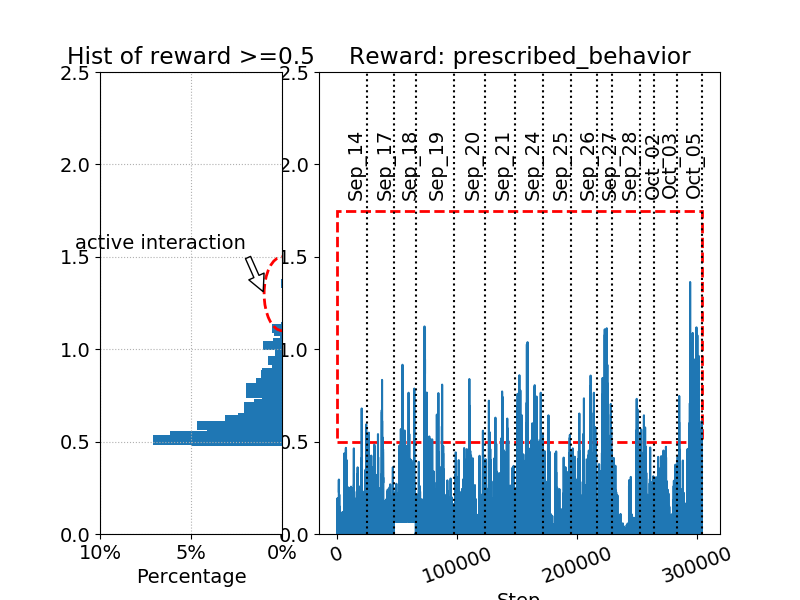

<IPython.core.display.Javascript object>


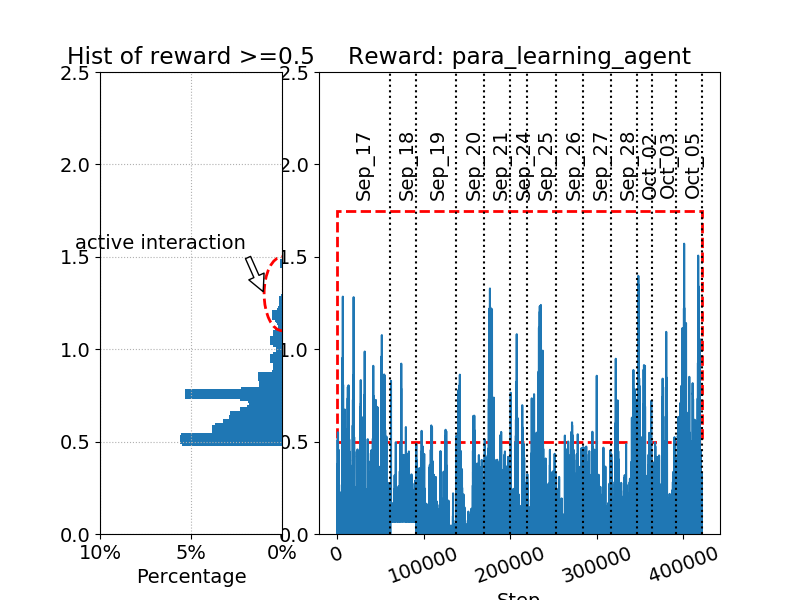

<IPython.core.display.Javascript object>


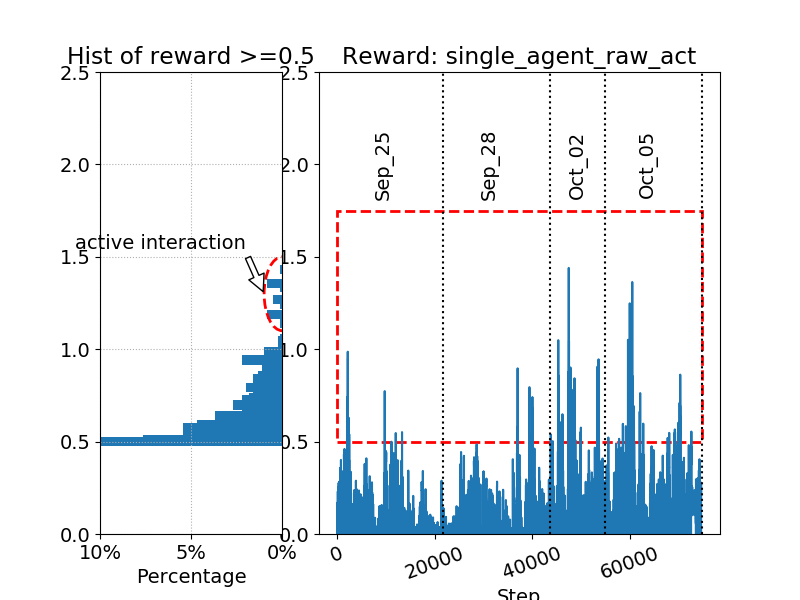

<IPython.core.display.Javascript object>


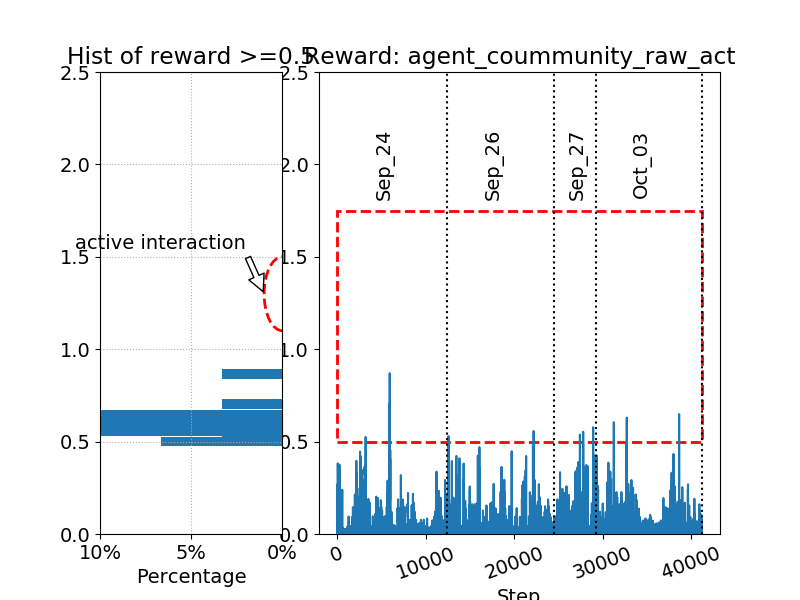

In [9]:
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

In [10]:
def combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_data):
    new_occupancy_data = occupancy_data
    for i, date in enumerate(occupancy_data['date']):
        d = date[0:6]
        t_start = date[7:11]
        t_end = date[12:]
        if i == 0:
            pass
        else:
            if d == last_d:
                print('Combine {} and {}'.format(i, i-1))
                combined_d = '{}_{}_{}'.format(d, last_t_start, t_end)
                print(combined_d)
                new_occupancy_data['date'][i] = combined_d
                new_occupancy_data['date'].pop(i-1)
                new_occupancy_data['separate_line'].pop(i-1)
        last_d = d
        last_t_start = t_start
        last_t_end = t_end
        #print('d:{}, t_start:{}, t_end:{}'.format(d,t_start,t_end))
    return new_occupancy_data

occupancy_camera1_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_prescribed_behavior)
occupancy_camera1_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_para_learning_agent)
occupancy_camera1_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_single_agent_raw_act)
occupancy_camera1_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_agent_coummunity_raw_act)

occupancy_camera2_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_prescribed_behavior)
occupancy_camera2_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_para_learning_agent)
occupancy_camera2_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_single_agent_raw_act)
occupancy_camera2_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_agent_coummunity_raw_act)


Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430
Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430


In [11]:
occupancy_camera1_para_learning_agent['date']

['Sep_17_1300_1500',
 'Sep_18_1300_1400',
 'Sep_18_1400_1430',
 'Sep_19_1300_1430',
 'Sep_20_1400_1500',
 'Sep_21_1500_1600',
 'Sep_24_1300_1400',
 'Sep_25_1500_1600',
 'Sep_26_1300_1400',
 'Sep_27_1400_1500',
 'Sep_28_1500_1600',
 'Oct_02_1400_1500',
 'Oct_03_1400_1500',
 'Oct_05_1400_1500']

In [12]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
    """
    Args:
        behavior_mode (string):
            1. 'prescribed_behavior'
            2. 'para_learning_agent'
            3. 'single_agent_raw_act'
            4. 'agent_coummunity_raw_act'
    """
    segment_num = len(data['separate_line'])
    if behavior_mode == 'prescribed_behavior':
        print('prescribed_behavior: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'para_learning_agent':
        print('para_learning_agent: {} segments'.format(segment_num))
        segment_num = segment_num + 1
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'single_agent_raw_act':
        print('single_agent_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    if behavior_mode == 'agent_coummunity_raw_act':
        print('agent_coummunity_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    grid_h = 3
    print('grid_h:{}, grid_w:{}, segment_num:{}'.format(grid_h, grid_w, segment_num))
    ########################################
    #             Create Axes              #
    ########################################
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Behavior Mode: {}'.format(behavior_mode))
    grid = plt.GridSpec(grid_h, grid_w, hspace=0.8, wspace=0)
    # 1. Main ax
    main_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    # 2. Reward hist ax
    reward_hist_ax = fig.add_subplot(grid[:int(grid_h*2/3), :(int(grid_w/3))], sharey=main_ax[0])
    # 3. Ocuupancy ax  
    occupancy_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    ########################################
    #                 Plot                 #
    ########################################
    # 1. plot reward
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    for i, main_ax_tmp in enumerate(main_ax):
        if behavior_mode != 'para_learning_agent':
            if i != 0:
                y = reward_data[data['separate_line'][i-1]:data['separate_line'][i]]
            else:
                y = reward_data[:data['separate_line'][i]]
            main_ax_tmp.text(len(y)*0.35, 2, data['date'][i], rotation=90, verticalalignment='center')
            
        else:
            if i == 0:
                y = np.zeros(0)
            else:
                temp_i = i-1
                if temp_i != 0:
                    y = reward_data[data['separate_line'][temp_i-1]:data['separate_line'][temp_i]]
                else:
                    y = reward_data[:data['separate_line'][temp_i]]
                main_ax_tmp.text(len(y)*0.35, 2, data['date'][temp_i], rotation=90, verticalalignment='center')
        # plot steps for each day
        steps = len(y)
        main_ax_tmp.text(len(y)*0.05, -0.2, '{}'.format(steps), rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(main_ax)/2): 
            main_ax[i].text(-len(y)*(1/3), -0.4, 'Steps', verticalalignment='center')
        
        main_ax_tmp.plot(np.arange(len(y)), y)

        main_ax_tmp.set_ylim(0,2.5,0.25)
        main_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        main_ax_tmp.tick_params(axis='x', rotation=10)
        main_ax_tmp.tick_params(bottom='off', labelbottom='off')
        if i != 0:
            main_ax_tmp.tick_params(left='off', labelleft='off')
            main_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            main_ax_tmp.spines['right'].set_linestyle('--')
            main_ax_tmp.spines['right'].set_linewidth(1.5)
            main_ax_tmp.spines['right'].set_color('r')
    main_ax[0].set_ylabel('Reward')
    title_main_ax = int(len(main_ax)/2)
    main_ax[title_main_ax].set_title('Reward',position=(0,1))
    
    #main_ax[title_main_ax].set_xlabel('Steps', position=(0,-0.5))
    
    # 2. plot hist
    hist_reward_threshold = 0.5#1.0#0.75
    hist_data = reward_data[reward_data>=hist_reward_threshold]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    reward_hist_ax.barh(edges[:-1], percentage, binWidth)
    ellipse = patches.Ellipse((0, 1.4), 2.2, 0.5, fill = False, color='r', linestyle='--', linewidth=2)
    reward_hist_ax.add_patch(ellipse)
    reward_hist_ax.annotate('active interaction',
                            xy=(1, 1.4), xycoords='data',
                            xytext=(0.8, 0.8), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False),
                            horizontalalignment='right', verticalalignment='top')
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
    reward_hist_ax.xaxis.set_major_formatter(formatter)
    reward_hist_ax.set_xlim(0,10)
    reward_hist_ax.set_xlabel('Percentage')
    reward_hist_ax.set_ylabel('Reward')
    reward_hist_ax.invert_xaxis()
    reward_hist_ax.set_title('Hist of reward >={}'.format(hist_reward_threshold))
    reward_hist_ax.grid(True, linestyle=':')
    
    # 3. plot occupancy Camera1
    occupancy_data_camera1 = occupancy_camera1['data']['Occupancy'].astype(float).values
    for i, occupancy_ax_tmp in enumerate(occupancy_ax):
        temp_i = i
        if i == 0 and (behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent'): # lost video on Sep_14
            y = np.zeros(1)
        else:
            if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
                temp_i = i-1
            
            if temp_i != 0:
                #print("occupancy_camera1['separate_line']:{}".format(len(occupancy_camera1['separate_line'])))
                y = occupancy_data_camera1[occupancy_camera1['separate_line'][temp_i-1]:occupancy_camera1['separate_line'][temp_i]]
            else:
                y = occupancy_data_camera1[:occupancy_camera1['separate_line'][temp_i]]
            
            if temp_i <= len(occupancy_camera1['date'])-1:
                #print('temp_i:{}, {}'.format(temp_i, occupancy_camera1['date'][temp_i]))
                d = occupancy_camera1['date'][temp_i][:6]
                t = occupancy_camera1['date'][temp_i][7:]
                occupancy_ax_tmp.text(len(y)*0.35, 18, d, rotation=90, verticalalignment='center')
                occupancy_ax_tmp.text(len(y)*0.05, -8, t, rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(occupancy_ax)/2): 
            occupancy_ax[i].text(-len(y)*(1/3), -15.5, 'Duration', verticalalignment='center')
        #print('i:{}'.format(i))
        occupancy_ax_tmp.plot(np.arange(len(y)), y, color = 'fuchsia')

        occupancy_ax_tmp.set_ylim(0,25)
        occupancy_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        occupancy_ax_tmp.tick_params(axis='x', rotation=10)
        occupancy_ax_tmp.tick_params(bottom='off',labelbottom='off')
        if i != 0:
            occupancy_ax_tmp.tick_params(left='off', labelleft='off')
            occupancy_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            occupancy_ax_tmp.spines['right'].set_linestyle('--')
            occupancy_ax_tmp.spines['right'].set_linewidth(1.5)
            occupancy_ax_tmp.spines['right'].set_color('r')
    occupancy_ax[0].set_ylabel('Occupancy')
    occupancy_ax[-1].legend(['Camera1'])
    title_occupancy_ax = int(len(occupancy_ax)/2)
    occupancy_ax[title_occupancy_ax].set_title('Estimated Occupancy',position=(0,1))        
    plt.savefig('reward_hist_occupancy_{}.png'.format(behavior_mode), dpi=300)


prescribed_behavior: 14 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


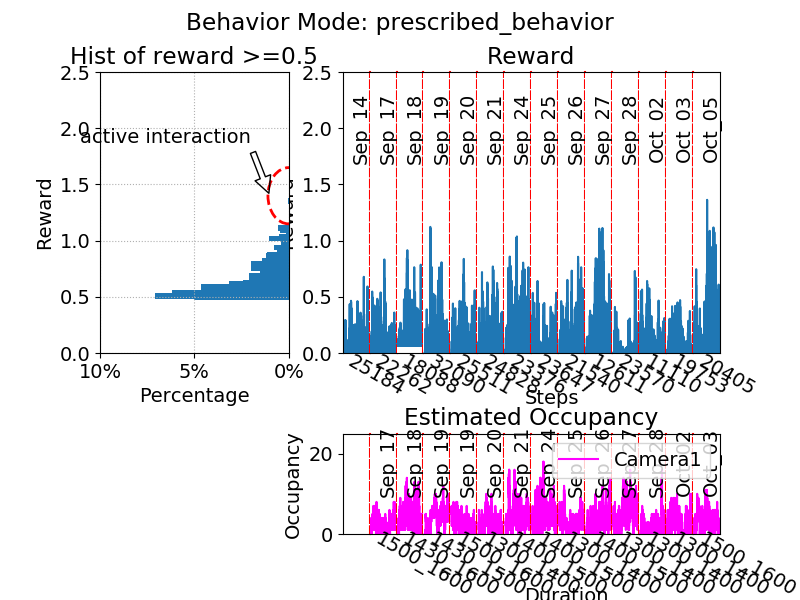

para_learning_agent: 13 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


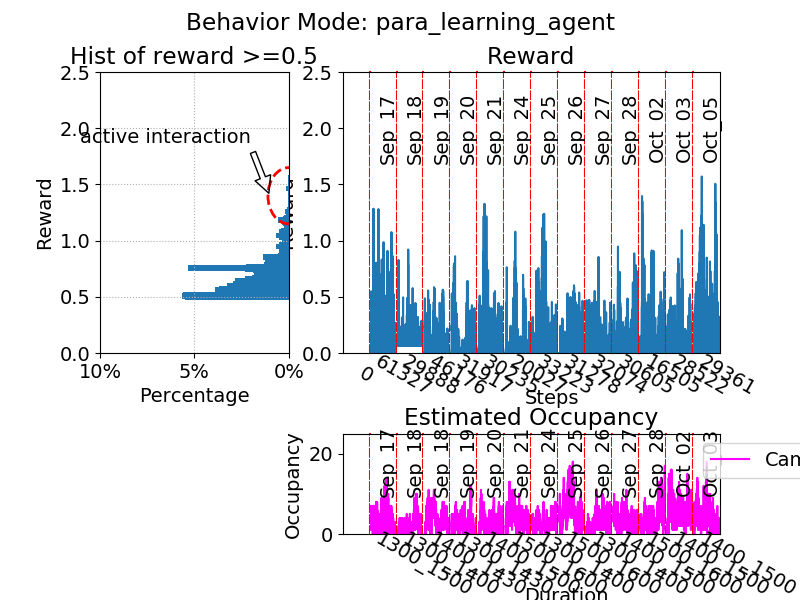

single_agent_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


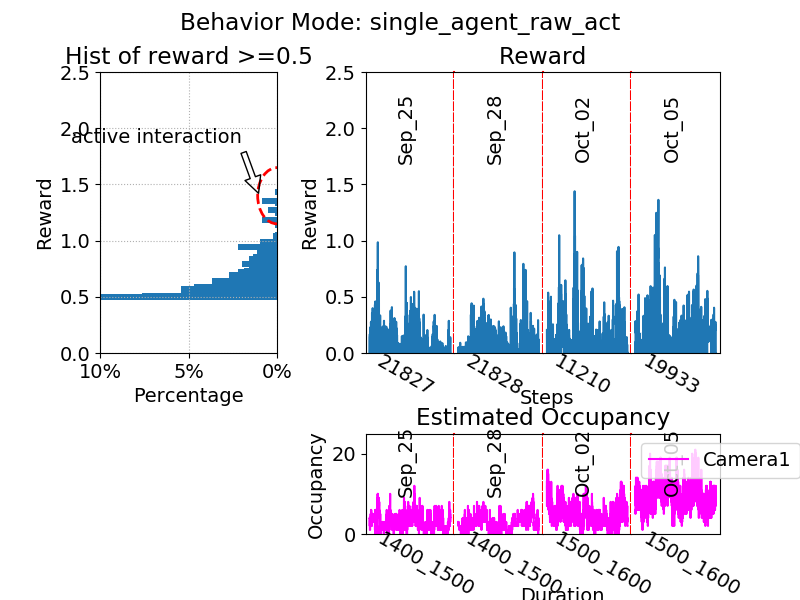

agent_coummunity_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


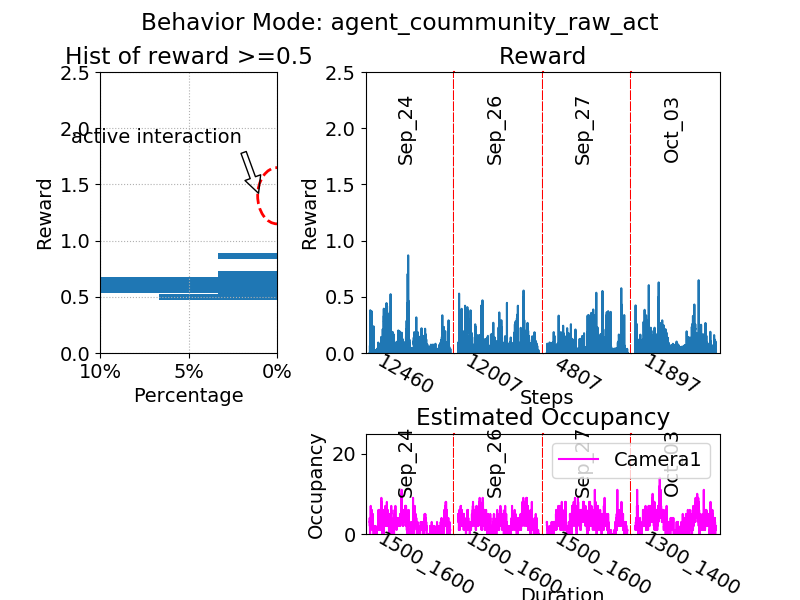

In [13]:
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

### Only reward and occupancy

In [14]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
    """
    Args:
        behavior_mode (string):
            1. 'prescribed_behavior'
            2. 'para_learning_agent'
            3. 'single_agent_raw_act'
            4. 'agent_coummunity_raw_act'
    """
    segment_num = len(data['separate_line'])
    if behavior_mode == 'prescribed_behavior':
        print('prescribed_behavior: {} segments'.format(segment_num))
        grid_w = int(segment_num)
    if behavior_mode == 'para_learning_agent':
        print('para_learning_agent: {} segments'.format(segment_num))
        segment_num = segment_num + 1
        grid_w = int(segment_num)
    if behavior_mode == 'single_agent_raw_act':
        print('single_agent_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num)
    if behavior_mode == 'agent_coummunity_raw_act':
        print('agent_coummunity_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num)
    grid_h = 3
    print('grid_h:{}, grid_w:{}, segment_num:{}'.format(grid_h, grid_w, segment_num))
    ########################################
    #             Create Axes              #
    ########################################
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Behavior Mode: {}'.format(behavior_mode))
    grid = plt.GridSpec(grid_h, grid_w, hspace=0.8, wspace=0)
    # 1. Main ax
    main_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), i]))
        else:
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), i]))
    
    # 3. Ocuupancy ax  
    occupancy_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, i]))
        else:
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, i]))
    ########################################
    #                 Plot                 #
    ########################################
    # 1. plot reward
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    for i, main_ax_tmp in enumerate(main_ax):
        if behavior_mode != 'para_learning_agent':
            if i != 0:
                y = reward_data[data['separate_line'][i-1]:data['separate_line'][i]]
            else:
                y = reward_data[:data['separate_line'][i]]
            main_ax_tmp.text(len(y)*0.35, 2, data['date'][i], rotation=90, verticalalignment='center')
            
        else:
            if i == 0:
                y = np.zeros(0)
            else:
                temp_i = i-1
                if temp_i != 0:
                    y = reward_data[data['separate_line'][temp_i-1]:data['separate_line'][temp_i]]
                else:
                    y = reward_data[:data['separate_line'][temp_i]]
                main_ax_tmp.text(len(y)*0.35, 2, data['date'][temp_i], rotation=90, verticalalignment='center')
        # plot steps for each day
        steps = len(y)
        main_ax_tmp.text(len(y)*0.05, -0.2, '{}'.format(steps), rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(main_ax)/2): 
            main_ax[i].text(-len(y)*(1/3), -0.4, 'Steps', verticalalignment='center')
        
        main_ax_tmp.plot(np.arange(len(y)), y)

        main_ax_tmp.set_ylim(0,2.5,0.25)
        main_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        main_ax_tmp.tick_params(axis='x', rotation=10)
        main_ax_tmp.tick_params(bottom='off', labelbottom='off')
        if i != 0:
            main_ax_tmp.tick_params(left='off', labelleft='off')
            main_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            main_ax_tmp.spines['right'].set_linestyle('--')
            main_ax_tmp.spines['right'].set_linewidth(1.5)
            main_ax_tmp.spines['right'].set_color('r')
    main_ax[0].set_ylabel('Reward')
    title_main_ax = int(len(main_ax)/2)
    main_ax[title_main_ax].set_title('Reward',position=(0,1))
    
    #main_ax[title_main_ax].set_xlabel('Steps', position=(0,-0.5))
    
    # 3. plot occupancy Camera1
    occupancy_data_camera1 = occupancy_camera1['data']['Occupancy'].astype(float).values
    for i, occupancy_ax_tmp in enumerate(occupancy_ax):
        temp_i = i
        if i == 0 and (behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent'): # lost video on Sep_14
            y = np.zeros(1)
        else:
            if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
                temp_i = i-1
            
            if temp_i != 0:
                #print("occupancy_camera1['separate_line']:{}".format(len(occupancy_camera1['separate_line'])))
                y = occupancy_data_camera1[occupancy_camera1['separate_line'][temp_i-1]:occupancy_camera1['separate_line'][temp_i]]
            else:
                y = occupancy_data_camera1[:occupancy_camera1['separate_line'][temp_i]]
            
            if temp_i <= len(occupancy_camera1['date'])-1:
                #print('temp_i:{}, {}'.format(temp_i, occupancy_camera1['date'][temp_i]))
                d = occupancy_camera1['date'][temp_i][:6]
                t = occupancy_camera1['date'][temp_i][7:]
                occupancy_ax_tmp.text(len(y)*0.35, 18, d, rotation=90, verticalalignment='center')
                occupancy_ax_tmp.text(len(y)*0.05, -8, t, rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(occupancy_ax)/2): 
            occupancy_ax[i].text(-len(y)*(1/3), -15.5, 'Duration', verticalalignment='center')
        #print('i:{}'.format(i))
        occupancy_ax_tmp.plot(np.arange(len(y)), y, color = 'fuchsia')

        occupancy_ax_tmp.set_ylim(0,25)
        occupancy_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        occupancy_ax_tmp.tick_params(axis='x', rotation=10)
        occupancy_ax_tmp.tick_params(bottom='off',labelbottom='off')
        if i != 0:
            occupancy_ax_tmp.tick_params(left='off', labelleft='off')
            occupancy_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            occupancy_ax_tmp.spines['right'].set_linestyle('--')
            occupancy_ax_tmp.spines['right'].set_linewidth(1.5)
            occupancy_ax_tmp.spines['right'].set_color('r')
    occupancy_ax[0].set_ylabel('Occupancy')
    occupancy_ax[-1].legend(['Camera1'],loc='upper right')
    title_occupancy_ax = int(len(occupancy_ax)/2)
    occupancy_ax[title_occupancy_ax].set_title('Estimated Occupancy',position=(0,1))        
    plt.savefig('reward_and_occupancy_{}.png'.format(behavior_mode), dpi=300)



prescribed_behavior: 14 segments
grid_h:3, grid_w:14, segment_num:14


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


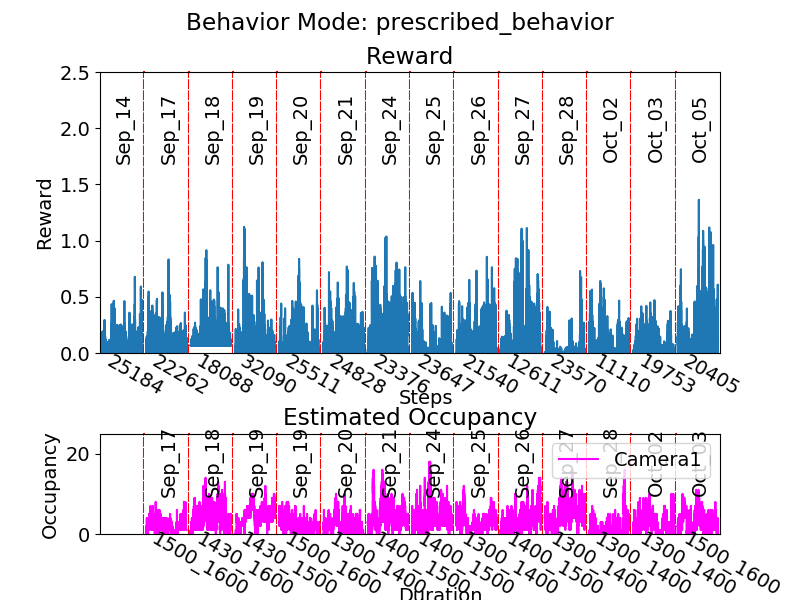

para_learning_agent: 13 segments
grid_h:3, grid_w:14, segment_num:14


<IPython.core.display.Javascript object>


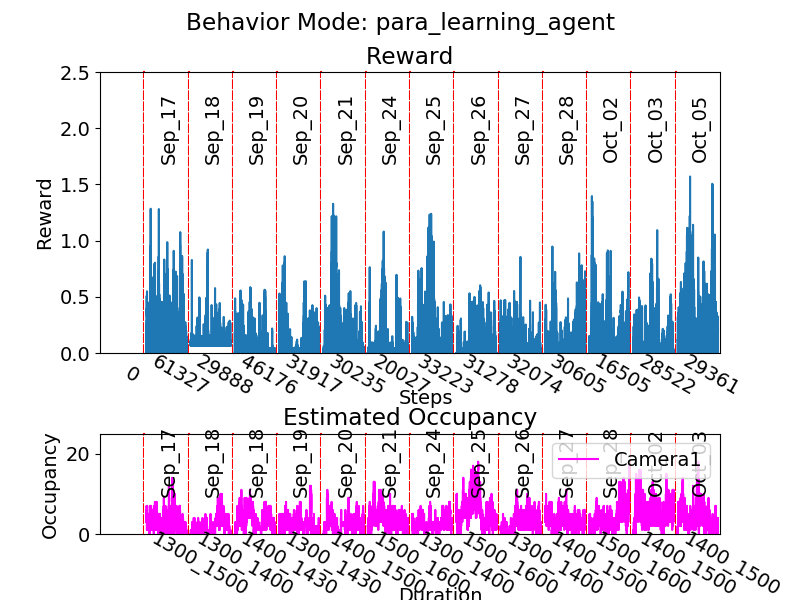

single_agent_raw_act: 4 segments
grid_h:3, grid_w:4, segment_num:4


<IPython.core.display.Javascript object>


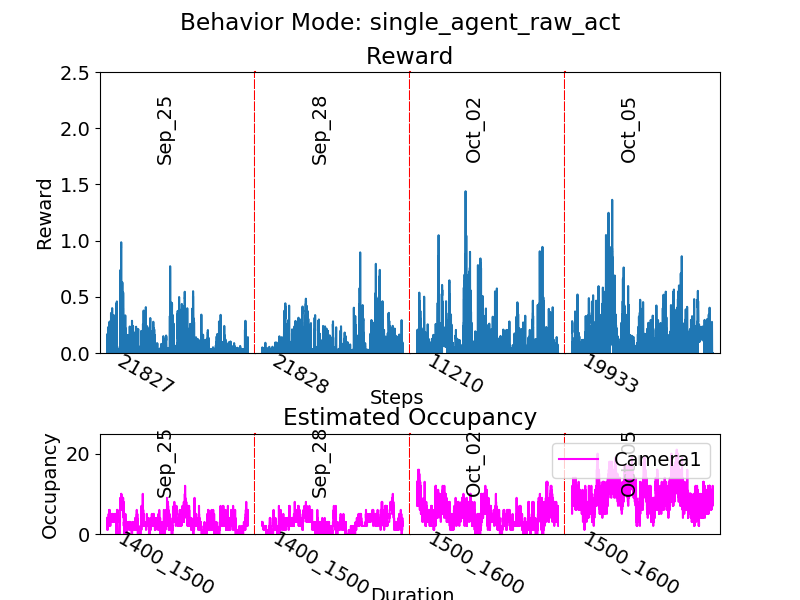

agent_coummunity_raw_act: 4 segments
grid_h:3, grid_w:4, segment_num:4


<IPython.core.display.Javascript object>


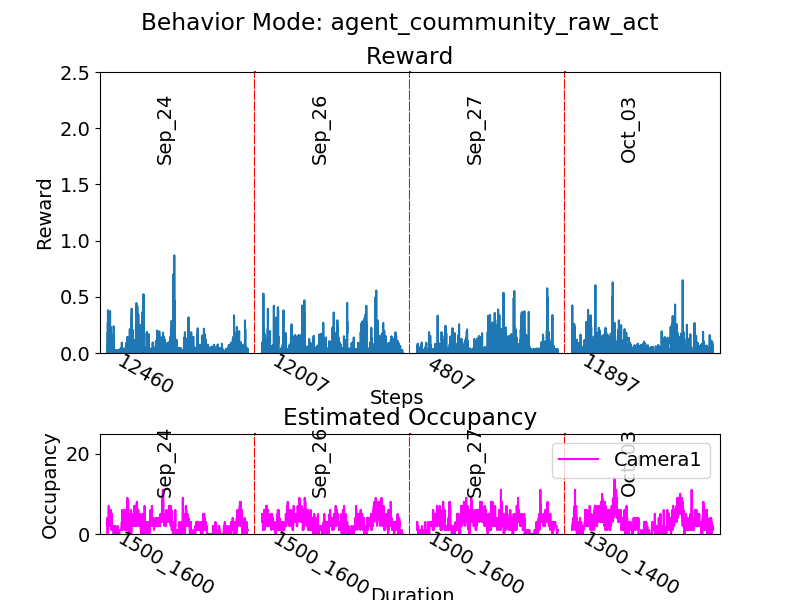

In [15]:
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

## Reward and Occupancy

prescribed_behavior: 14 segments
grid_h:3, grid_w:23, segment_num:14


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


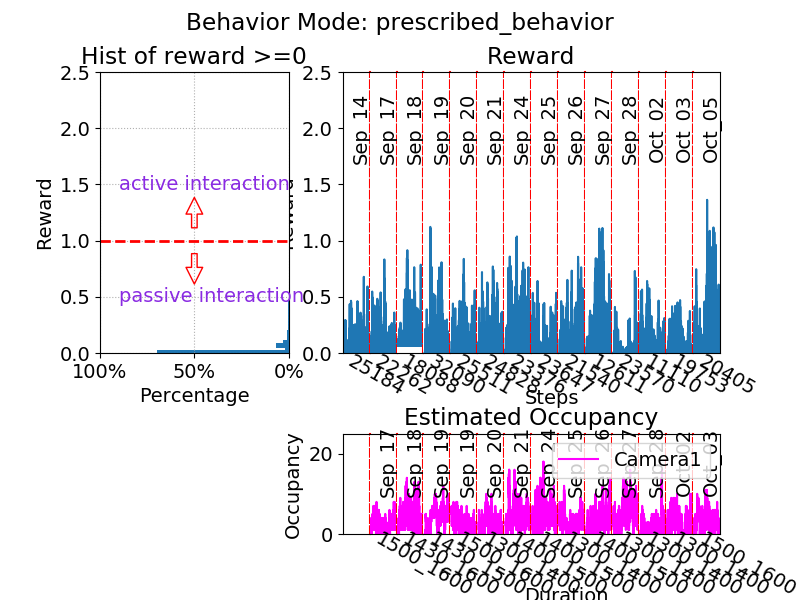

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


para_learning_agent: 13 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


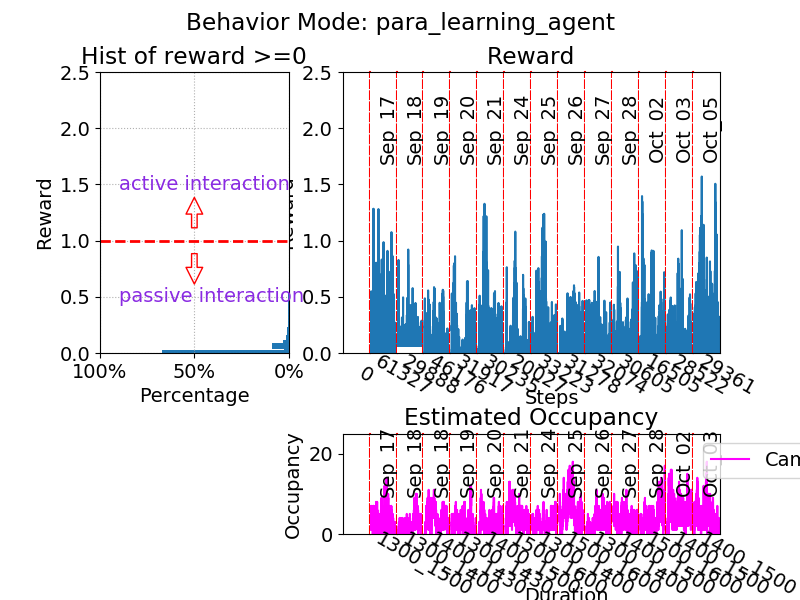

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


single_agent_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


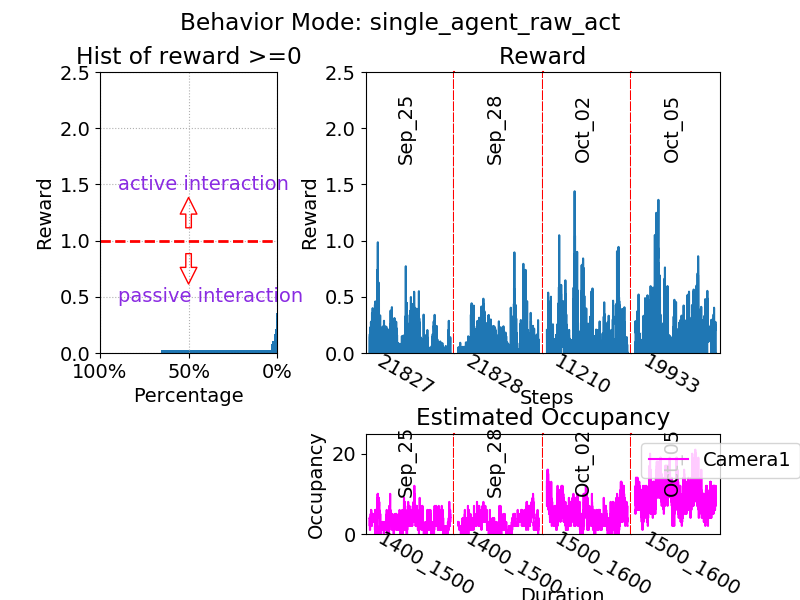

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


agent_coummunity_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


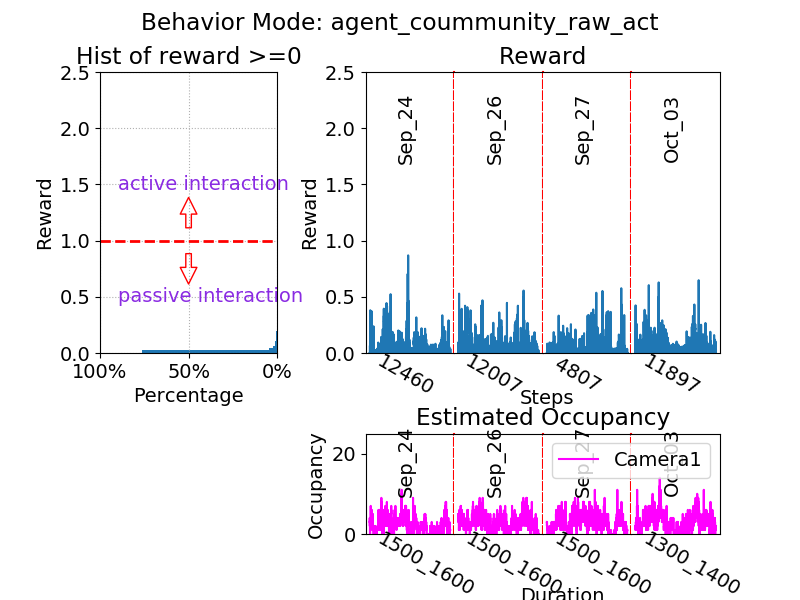

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


In [16]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
    """
    Args:
        behavior_mode (string):
            1. 'prescribed_behavior'
            2. 'para_learning_agent'
            3. 'single_agent_raw_act'
            4. 'agent_coummunity_raw_act'
    """
    segment_num = len(data['separate_line'])
    if behavior_mode == 'prescribed_behavior':
        print('prescribed_behavior: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'para_learning_agent':
        print('para_learning_agent: {} segments'.format(segment_num))
        segment_num = segment_num + 1
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'single_agent_raw_act':
        print('single_agent_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    if behavior_mode == 'agent_coummunity_raw_act':
        print('agent_coummunity_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    grid_h = 3
    print('grid_h:{}, grid_w:{}, segment_num:{}'.format(grid_h, grid_w, segment_num))
    ########################################
    #             Create Axes              #
    ########################################
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Behavior Mode: {}'.format(behavior_mode))
    grid = plt.GridSpec(grid_h, grid_w, hspace=0.8, wspace=0)
    # 1. Main ax
    main_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    # 2. Reward hist ax
    reward_hist_ax = fig.add_subplot(grid[:int(grid_h*2/3), :(int(grid_w/3))], sharey=main_ax[0])
    # 3. Ocuupancy ax  
    occupancy_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    ########################################
    #                 Plot                 #
    ########################################
    # 1. plot reward
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    for i, main_ax_tmp in enumerate(main_ax):
        if behavior_mode != 'para_learning_agent':
            if i != 0:
                y = reward_data[data['separate_line'][i-1]:data['separate_line'][i]]
            else:
                y = reward_data[:data['separate_line'][i]]
            main_ax_tmp.text(len(y)*0.35, 2, data['date'][i], rotation=90, verticalalignment='center')
            
        else:
            if i == 0:
                y = np.zeros(0)
            else:
                temp_i = i-1
                if temp_i != 0:
                    y = reward_data[data['separate_line'][temp_i-1]:data['separate_line'][temp_i]]
                else:
                    y = reward_data[:data['separate_line'][temp_i]]
                main_ax_tmp.text(len(y)*0.35, 2, data['date'][temp_i], rotation=90, verticalalignment='center')
        # plot steps for each day
        steps = len(y)
        main_ax_tmp.text(len(y)*0.05, -0.2, '{}'.format(steps), rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(main_ax)/2): 
            main_ax[i].text(-len(y)*(1/3), -0.4, 'Steps', verticalalignment='center')
        
        main_ax_tmp.plot(np.arange(len(y)), y)

        main_ax_tmp.set_ylim(0,2.5,0.25)
        main_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        main_ax_tmp.tick_params(axis='x', rotation=10)
        main_ax_tmp.tick_params(bottom='off', labelbottom='off')
        if i != 0:
            main_ax_tmp.tick_params(left='off', labelleft='off')
            main_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            main_ax_tmp.spines['right'].set_linestyle('--')
            main_ax_tmp.spines['right'].set_linewidth(1.5)
            main_ax_tmp.spines['right'].set_color('r')
    main_ax[0].set_ylabel('Reward')
    title_main_ax = int(len(main_ax)/2)
    main_ax[title_main_ax].set_title('Reward',position=(0,1))
    
    #main_ax[title_main_ax].set_xlabel('Steps', position=(0,-0.5))
    
    # 2. plot hist
    hist_reward_threshold = 0#0.5#1.0#0.75
    hist_data = reward_data[reward_data>=hist_reward_threshold]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    reward_hist_ax.barh(edges[:-1], percentage, binWidth)
    # draw horizontal line
    active_passive_boundary = 1
    reward_hist_ax.axhline(y = active_passive_boundary, color = 'r', linestyle='--', linewidth=2)
    # annotate
    reward_hist_ax.text(90, 1.5, 'active interaction', verticalalignment='center', color='blueviolet')
    reward_hist_ax.text(90, 0.5, 'passive interaction', verticalalignment='center', color='blueviolet')
    reward_hist_ax.annotate("", xy=(1, 5), xytext=(9, 1.5),
                            arrowprops=dict(arrowstyle="->"))
    reward_hist_ax.annotate('',
                            xy=(50, 1.4), xycoords='data',
                            xytext=(0.5, 0.44), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False, color='r'),
                            horizontalalignment='right', verticalalignment='top')
    reward_hist_ax.annotate('',
                            xy=(50, 0.6), xycoords='data',
                            xytext=(0.5, 0.36), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False, color='r'),
                            horizontalalignment='right', verticalalignment='top')
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
    reward_hist_ax.xaxis.set_major_formatter(formatter)
    reward_hist_ax.set_xlim(0,100)
    reward_hist_ax.set_xlabel('Percentage')
    reward_hist_ax.set_ylabel('Reward')
    reward_hist_ax.invert_xaxis()
    reward_hist_ax.set_title('Hist of reward >={}'.format(hist_reward_threshold))
    reward_hist_ax.grid(True, linestyle=':')
    
    # 3. plot occupancy Camera1
    occupancy_data_camera1 = occupancy_camera1['data']['Occupancy'].astype(float).values
    for i, occupancy_ax_tmp in enumerate(occupancy_ax):
        temp_i = i
        if i == 0 and (behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent'): # lost video on Sep_14
            y = np.zeros(1)
        else:
            if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
                temp_i = i-1
            
            if temp_i != 0:
                #print("occupancy_camera1['separate_line']:{}".format(len(occupancy_camera1['separate_line'])))
                y = occupancy_data_camera1[occupancy_camera1['separate_line'][temp_i-1]:occupancy_camera1['separate_line'][temp_i]]
            else:
                y = occupancy_data_camera1[:occupancy_camera1['separate_line'][temp_i]]
            
            if temp_i <= len(occupancy_camera1['date'])-1:
                #print('temp_i:{}, {}'.format(temp_i, occupancy_camera1['date'][temp_i]))
                d = occupancy_camera1['date'][temp_i][:6]
                t = occupancy_camera1['date'][temp_i][7:]
                occupancy_ax_tmp.text(len(y)*0.35, 18, d, rotation=90, verticalalignment='center')
                occupancy_ax_tmp.text(len(y)*0.05, -8, t, rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(occupancy_ax)/2): 
            occupancy_ax[i].text(-len(y)*(1/3), -15.5, 'Duration', verticalalignment='center')
        #print('i:{}'.format(i))
        occupancy_ax_tmp.plot(np.arange(len(y)), y, color = 'fuchsia')

        occupancy_ax_tmp.set_ylim(0,25)
        occupancy_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        occupancy_ax_tmp.tick_params(axis='x', rotation=10)
        occupancy_ax_tmp.tick_params(bottom='off',labelbottom='off')
        if i != 0:
            occupancy_ax_tmp.tick_params(left='off', labelleft='off')
            occupancy_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            occupancy_ax_tmp.spines['right'].set_linestyle('--')
            occupancy_ax_tmp.spines['right'].set_linewidth(1.5)
            occupancy_ax_tmp.spines['right'].set_color('r')
    occupancy_ax[0].set_ylabel('Occupancy')
    occupancy_ax[-1].legend(['Camera1'])
    title_occupancy_ax = int(len(occupancy_ax)/2)
    occupancy_ax[title_occupancy_ax].set_title('Estimated Occupancy',position=(0,1))        
    plt.savefig('reward_hist_occupancy_{}.png'.format(behavior_mode), dpi=300)

    
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

# Plot Reward With Zoom In

In [17]:
def plot_reward_in_range(reward_low, reward_up, 
                         prescribed_behavior, para_learning_agent, 
                         behavior_name1, behavior_name2):
    """
    Args:
        reward_low (float): lower bound of reward range
        reward_up (float): upper bound of reward range
        prescribed_behavior :
        para_learning_agent :
        behavior_name1 :
        behavior_name2 :
    """
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.1

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100
    
    # Plot all hist
    fig = plt.figure(figsize=(10,6))
    plt.bar(edges_pb[:-1]+binWidth/2, percentage_pb, binWidth, edgecolor='white')
    plt.bar(edges_pla[:-1]+binWidth/2, -percentage_pla, binWidth, edgecolor='white')
    segment_len = 5
    for x, y in zip(edges_pb[0:segment_len], percentage_pb[0:segment_len]):
        plt.text(x+binWidth/2, y + 2.5, '{0:.2f}'.format(y), ha='center', va= 'bottom')

    for x, y in zip(edges_pla[0:segment_len], percentage_pla[0:segment_len]):
        plt.text(x+binWidth/2, -y - 2.5, '{0:.2f}'.format(y), ha='center', va= 'top')
    
    plt.xlim(edges_pb[0]-bin_step*0.99, edges_pb[-1])
    plt.xlabel('reward')
    plt.xticks(edges_pb[:-1], rotation=30)
    plt.ylim(-100, 100)
    plt.yticks(np.arange(-100, 100.1, 10))
    plt.ylabel('percentage')
    plt.gca().set_yticklabels(['{:.0f}%'.format(abs(x)) for x in plt.gca().get_yticks()])

    plt.legend([behavior_name1, behavior_name2], loc=(0.14, 0.01))
    #plt.title('{} vs {} \nreward in range [{:.1f}, {:.1f})'.format(behavior_name1, behavior_name2, edges_pb[0], edges_pb[-1]))
    plt.title('{} vs {}'.format(behavior_name1, behavior_name2))
    plt.grid(True, linestyle=':')
    plt.show()
    
    # annotate Zoom In text and arrow
    zoom_in_arrow = [[0.4, 25, 1, 25], [0.9, -25, 1.5, -25], [1.4, 25, 2, 25]]
    zoom_in_arrow_start = [[0.49, 0, 0.91, 0], [0.99, 0, 1.41, 0], [1.49, 0, 1.91, 0]]
    zoom_in_text = [[0.7, 5], [1.2, -15], [1.7, 5]]
    for i in range(3):
        plt.annotate('',
                     xy=(zoom_in_arrow[i][0], zoom_in_arrow[i][1]), xycoords='data',
                     xytext=(zoom_in_arrow_start[i][0], zoom_in_arrow_start[i][1]), 
                     arrowprops=dict(facecolor='black', shrink=0.025, fill=False, color='r',linestyle=':'),
                     horizontalalignment='right', verticalalignment='top')
        plt.annotate('',
                     xy=(zoom_in_arrow[i][2], zoom_in_arrow[i][3]), xycoords='data',
                     xytext=(zoom_in_arrow_start[i][2], zoom_in_arrow_start[i][3]),
                     arrowprops=dict(facecolor='black', shrink=0.025, fill=False, color='r',linestyle=':'),
                     horizontalalignment='right', verticalalignment='top')
        plt.text(zoom_in_text[i][0], zoom_in_text[i][1], 'zoom in', ha='center', va= 'bottom',fontsize='large')
        
    # Plot Zoom In Part
    segment_num = 4
    segment_len = 5
    ylim = [100, 1, 0.1, 0.01]
    text_shift = [2.5, 0.1, 0.01, 0.001]
    sub_axes = [[0.31, 0.59, .22, .22], [0.495, 0.175, .22, .22], [0.68, 0.59, .22, .22]]
    
    for i in range(1,segment_num):
        # add axes
        a = plt.axes(sub_axes[i-1])
        
        # plot
        plt.bar(edges_pb[i*segment_len:(i+1)*segment_len]+binWidth/2, percentage_pb[i*segment_len:(i+1)*segment_len], binWidth, edgecolor='white')
        plt.bar(edges_pla[i*segment_len:(i+1)*segment_len]+binWidth/2, -percentage_pla[i*segment_len:(i+1)*segment_len], binWidth, edgecolor='white')

        for x, y in zip(edges_pb[i*segment_len:(i+1)*segment_len], percentage_pb[i*segment_len:(i+1)*segment_len]):
            if y>0.0005:
                plt.text(x+binWidth/2, y + text_shift[i], '{0:.3f}'.format(y), ha='center', va= 'bottom', rotation=20)
            else:
                plt.text(x+binWidth/2, y + text_shift[i], '{0:.0f}'.format(y), ha='center', va= 'bottom', rotation=20)

        for x, y in zip(edges_pla[i*segment_len:(i+1)*segment_len], percentage_pla[i*segment_len:(i+1)*segment_len]):
            if y>0.0005:
                plt.text(x+binWidth/2, -y - text_shift[i], '{0:.3f}'.format(y), ha='center', va= 'top', rotation=-20)
            else:
                plt.text(x+binWidth/2, -y - text_shift[i], '{0:.0f}'.format(y), ha='center', va= 'top', rotation=-20)

        plt.xlim(edges_pb[i*segment_len]-bin_step*0.99, edges_pb[(i+1)*segment_len])
        #plt.xlabel('reward')
        plt.xticks(edges_pb[i*segment_len:(i+1)*segment_len])
        plt.ylim(-ylim[i], ylim[i])
        #plt.ylabel('percentage')
        #plt.gca().set_yticklabels(['{:.3f}'.format(abs(x)) for x in plt.gca().get_yticks()])
        plt.gca().set_yticklabels([])
        #plt.gca().get_yaxis().set_visible(False)

        #plt.legend([behavior_name1, behavior_name2], loc='upper right')
        #plt.title('reward in range [{:.1f}, {:.1f})'.format(edges_pb[i*segment_len], edges_pb[(i+1)*segment_len]))
        plt.grid(True, linestyle=':')
        plt.show()
    plt.savefig('plot_reward_{}_{}_in_range_{}_{}.png'.format(behavior_name1, 
                                                              behavior_name2, 
                                                              str(reward_low).replace('.','_'), 
                                                              str(reward_up).replace('.','_')), 
                dpi=300)
   


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


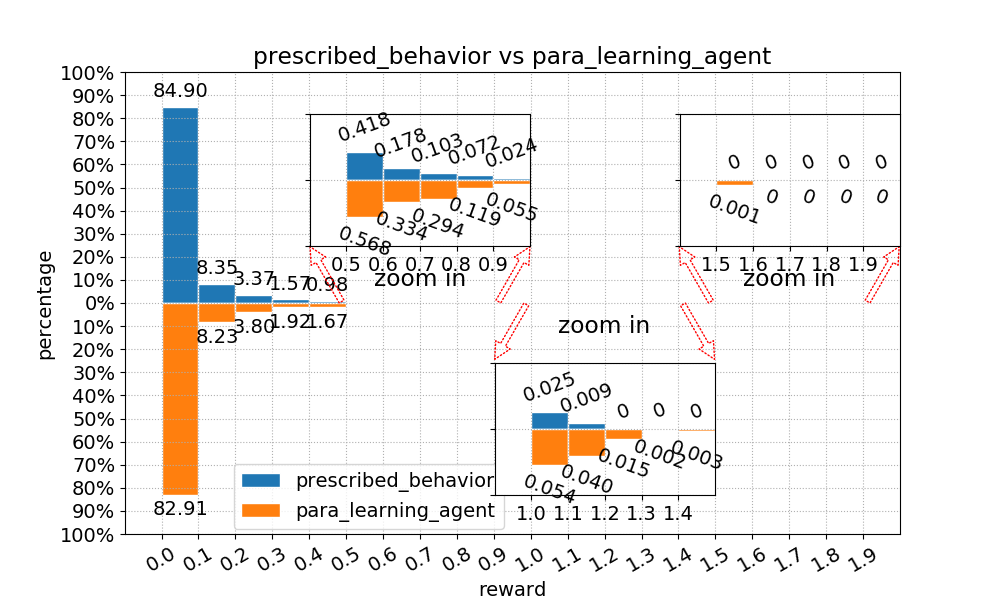

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.ling

<IPython.core.display.Javascript object>


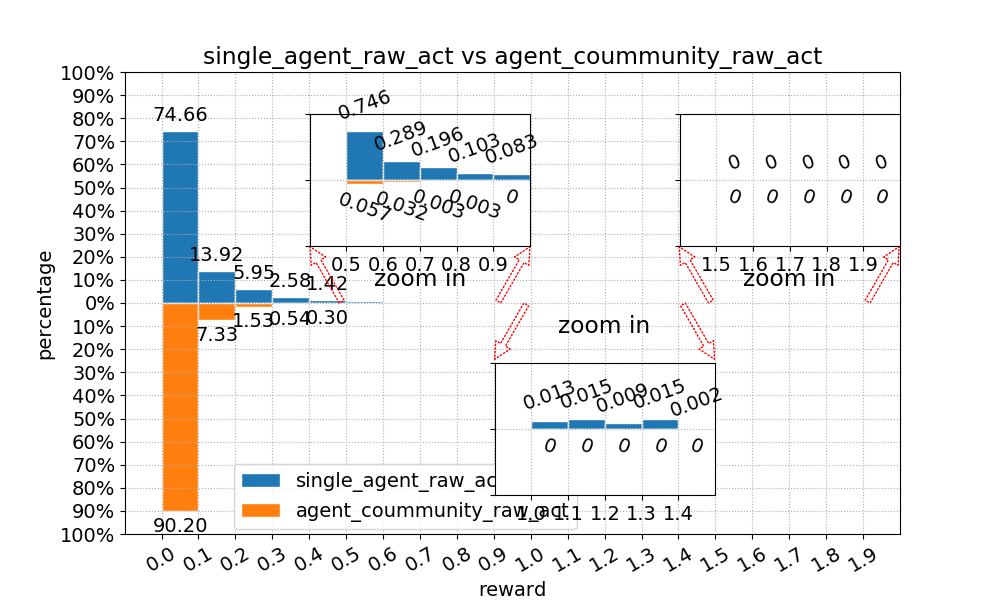

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/jack.ling

In [18]:
reward_low = 0
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent, 
                     'prescribed_behavior', 'para_learning_agent')

reward_low = 0
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')

In [139]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
results_pb, edges_pb = np.histogram(hist_data_pb, bins)


# Parameterized Learning Agent
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
results_pla, edges_pla = np.histogram(hist_data_pla, bins)


alternative hypothesis: $p_{PB}<p_{PLA}$

In [140]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_pb)-1):
    counts = np.array([results_pb[i], results_pla[i]])
    nobs = np.array([sum(results_pb), sum(results_pla)])
    stat, pval = proportions_ztest(counts, nobs, alternative='smaller')
    print('[{}, {})'.format(edges_pb[i], edges_pb[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=0.6919933341030738
[0.30000000000000004, 0.4)
pval=2.2551251677663073e-05
[0.4, 0.5)
pval=2.6084562616603054e-69
[0.5, 0.6)
pval=6.450343480419495e-07
[0.6, 0.7000000000000001)
pval=1.554067832114498e-20
[0.7000000000000001, 0.8)
pval=1.6768510862032992e-43
[0.8, 0.9)
pval=8.971335029948509e-06
[0.9, 1.0)
pval=5.399281273659409e-07
[1.0, 1.1)
pval=4.229226866875527e-06
[1.1, 1.2000000000000002)
pval=1.634534964798656e-11
[1.2000000000000002, 1.3000000000000003)
pval=6.313191718145751e-09
[1.3000000000000003, 1.4000000000000001)
pval=0.07523881422551452
[1.4000000000000001, 1.5000000000000002)
pval=0.0039336981126949925
[1.5000000000000002, 1.6)
pval=0.09195798209111145
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


In [141]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_SARA = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_SARA = reward_data_SARA[reward_data_SARA!=0] # remove 0
hist_data_SARA = reward_data_SARA[reward_data_SARA>=bin_low]
hist_data_SARA = hist_data_SARA[hist_data_SARA<bin_up]
results_SARA, edges_SARA = np.histogram(hist_data_SARA, bins)


# Parameterized Learning Agent
reward_data_ACRA = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_ACRA = reward_data_ACRA[reward_data_ACRA!=0] # remove 0
hist_data_ACRA = reward_data_ACRA[reward_data_ACRA>=bin_low]
hist_data_ACRA = hist_data_ACRA[hist_data_ACRA<bin_up]
results_ACRA, edges_ACRA = np.histogram(hist_data_ACRA, bins)



alternative hypothesis: $p_{SARA}>p_{ACRA}$

In [142]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_SARA)-1):
    counts = np.array([results_SARA[i], results_ACRA[i]])
    nobs = np.array([sum(results_SARA), sum(results_ACRA)])
    stat, pval = proportions_ztest(counts, nobs, alternative='larger')
    print('[{}, {})'.format(edges_pb[i], edges_pb[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=8.171151026381727e-22
[0.30000000000000004, 0.4)
pval=2.6830557665084347e-16
[0.4, 0.5)
pval=3.1919761211019506e-09
[0.5, 0.6)
pval=1.4079671493337095e-14
[0.6, 0.7000000000000001)
pval=1.6320298867703815e-05
[0.7000000000000001, 0.8)
pval=1.3788567672823076e-06
[0.8, 0.9)
pval=0.0005668233647743483
[0.9, 1.0)
pval=0.0006837483166289724
[1.0, 1.1)
pval=0.10611986758928232
[1.1, 1.2000000000000002)
pval=0.09116777655636193
[1.2000000000000002, 1.3000000000000003)
pval=0.1458935567260769
[1.3000000000000003, 1.4000000000000001)
pval=0.09116777655636193
[1.4000000000000001, 1.5000000000000002)
pval=0.31867704002091635
[1.5000000000000002, 1.6)
pval=nan
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


In [143]:
PB_PLA = {}
PB_PLA_Data = pd.concat([prescribed_behavior['data'], para_learning_agent['data']])
PB_PLA['data'] = PB_PLA_Data

SARA_ACRA = {}
SARA_ACRA_Data = pd.concat([single_agent_raw_act['data'], agent_coummunity_raw_act['data']])
SARA_ACRA['data'] = SARA_ACRA_Data



In [144]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_PB_PLA = PB_PLA['data']['reward_IR_distance'].astype(float).values
reward_data_PB_PLA = reward_data_PB_PLA[reward_data_PB_PLA!=0] # remove 0
hist_data_PB_PLA = reward_data_PB_PLA[reward_data_PB_PLA>=bin_low]
hist_data_PB_PLA = hist_data_PB_PLA[hist_data_PB_PLA<bin_up]
results_PB_PLA, edges_PB_PLA = np.histogram(hist_data_PB_PLA, bins)


# Parameterized Learning Agent
reward_data_SARA_ACRA = SARA_ACRA['data']['reward_IR_distance'].astype(float).values
reward_data_SARA_ACRA = reward_data_SARA_ACRA[reward_data_SARA_ACRA!=0] # remove 0
hist_data_SARA_ACRA = reward_data_SARA_ACRA[reward_data_SARA_ACRA>=bin_low]
hist_data_SARA_ACRA = hist_data_SARA_ACRA[hist_data_SARA_ACRA<bin_up]
results_SARA_ACRA, edges_SARA_ACRA = np.histogram(hist_data_SARA_ACRA, bins)



In [145]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_PB_PLA)-1):
    counts = np.array([results_PB_PLA[i], results_SARA_ACRA[i]])
    nobs = np.array([sum(results_PB_PLA), sum(results_SARA_ACRA)])
    stat, pval = proportions_ztest(counts, nobs, alternative='larger')
    print('[{}, {})'.format(edges_PB_PLA[i], edges_PB_PLA[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=0.27301713490314206
[0.30000000000000004, 0.4)
pval=5.047000294860605e-10
[0.4, 0.5)
pval=7.615798477523451e-52
[0.5, 0.6)
pval=1.1098684398288758e-05
[0.6, 0.7000000000000001)
pval=2.91974715090662e-11
[0.7000000000000001, 0.8)
pval=1.5441036696071982e-14
[0.8, 0.9)
pval=5.951291936098442e-06
[0.9, 1.0)
pval=0.5546564327297957
[1.0, 1.1)
pval=1.1875118807372732e-08
[1.1, 1.2000000000000002)
pval=6.765763575511678e-05
[1.2000000000000002, 1.3000000000000003)
pval=0.08293738655816496
[1.3000000000000003, 1.4000000000000001)
pval=0.9999679459295091
[1.4000000000000001, 1.5000000000000002)
pval=0.23879843238403003
[1.5000000000000002, 1.6)
pval=0.23642675521302597
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


# Plot Reward distribution with broken axis

https://matplotlib.org/examples/pylab_examples/broken_axis.html

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


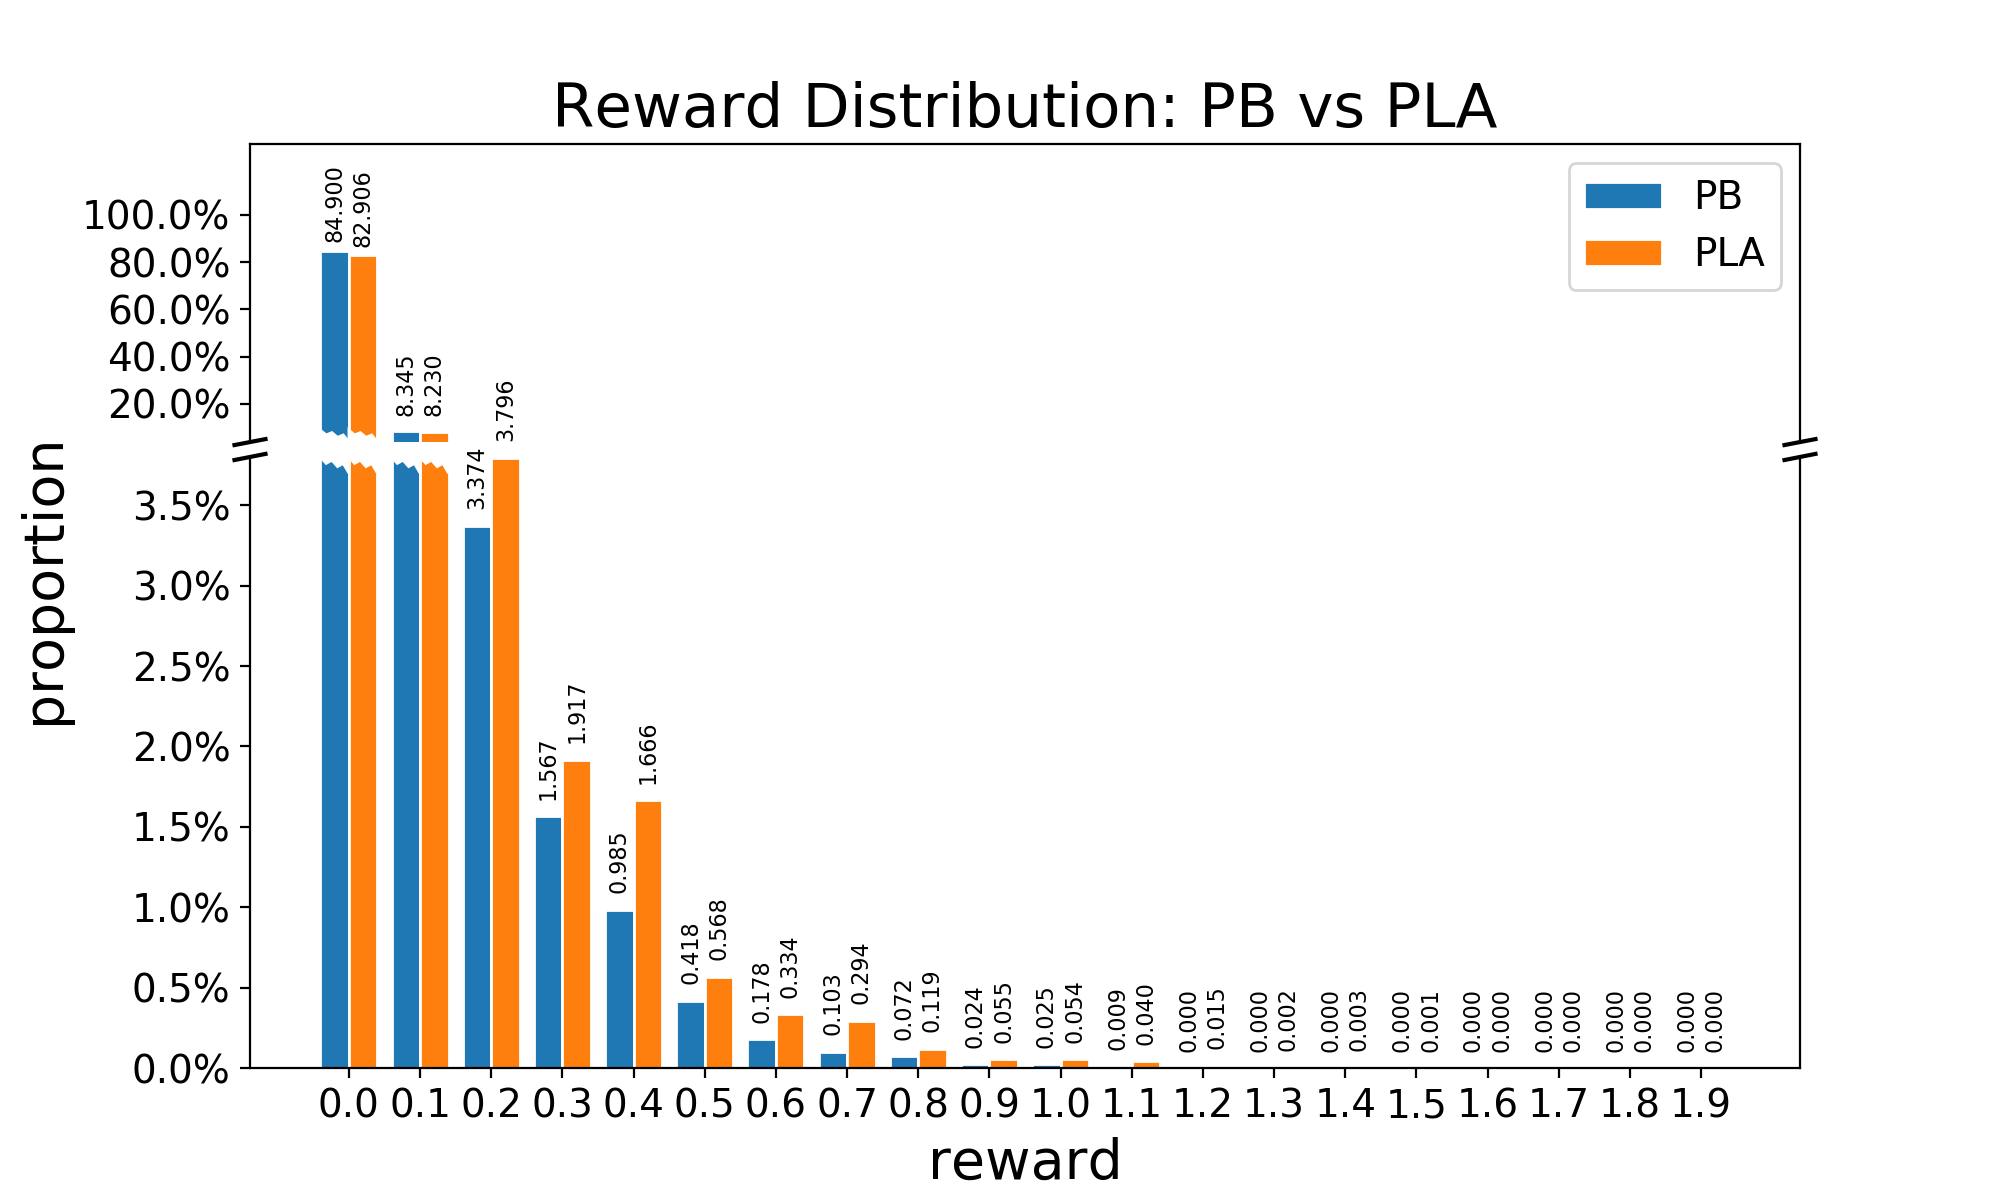

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


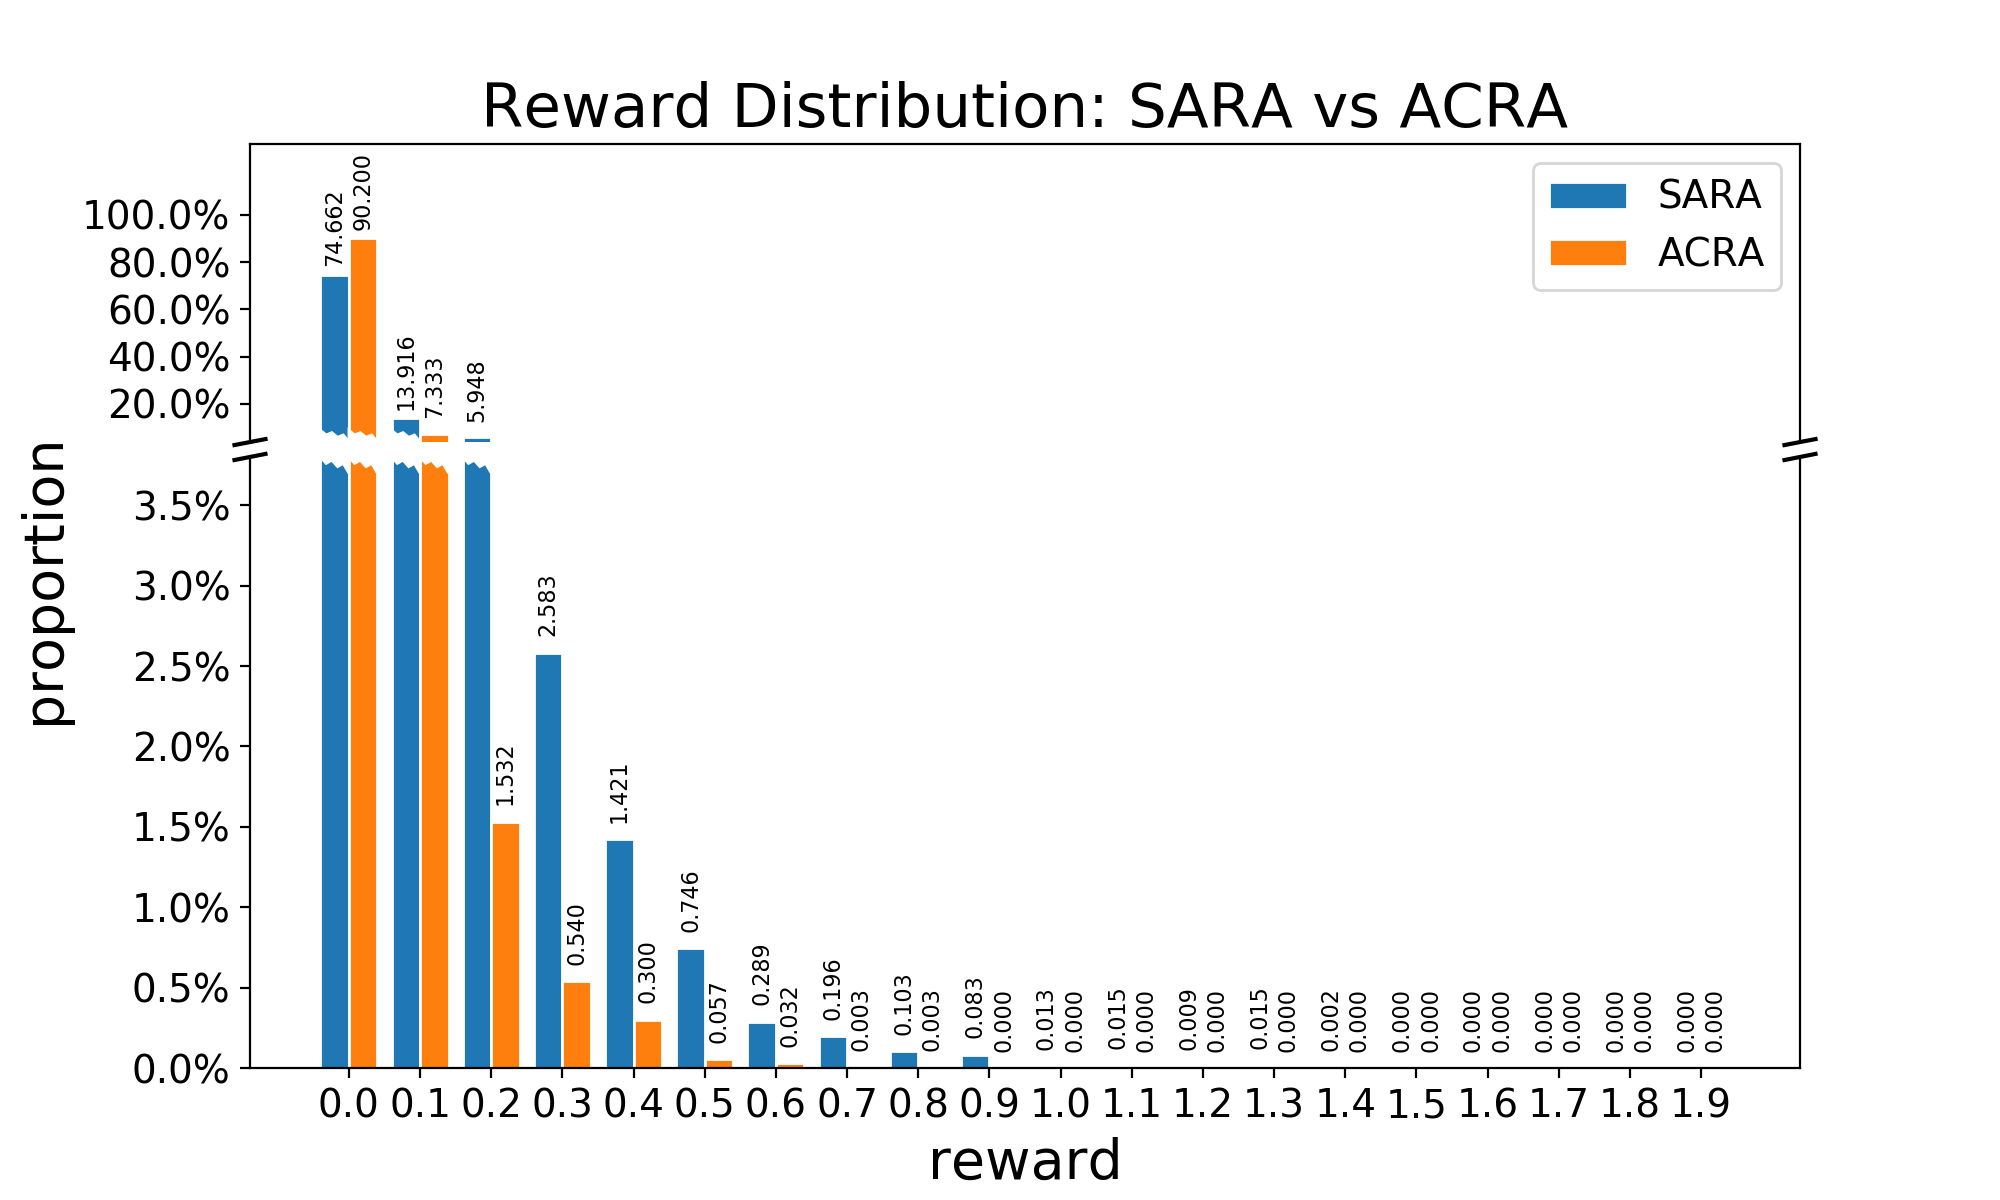

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


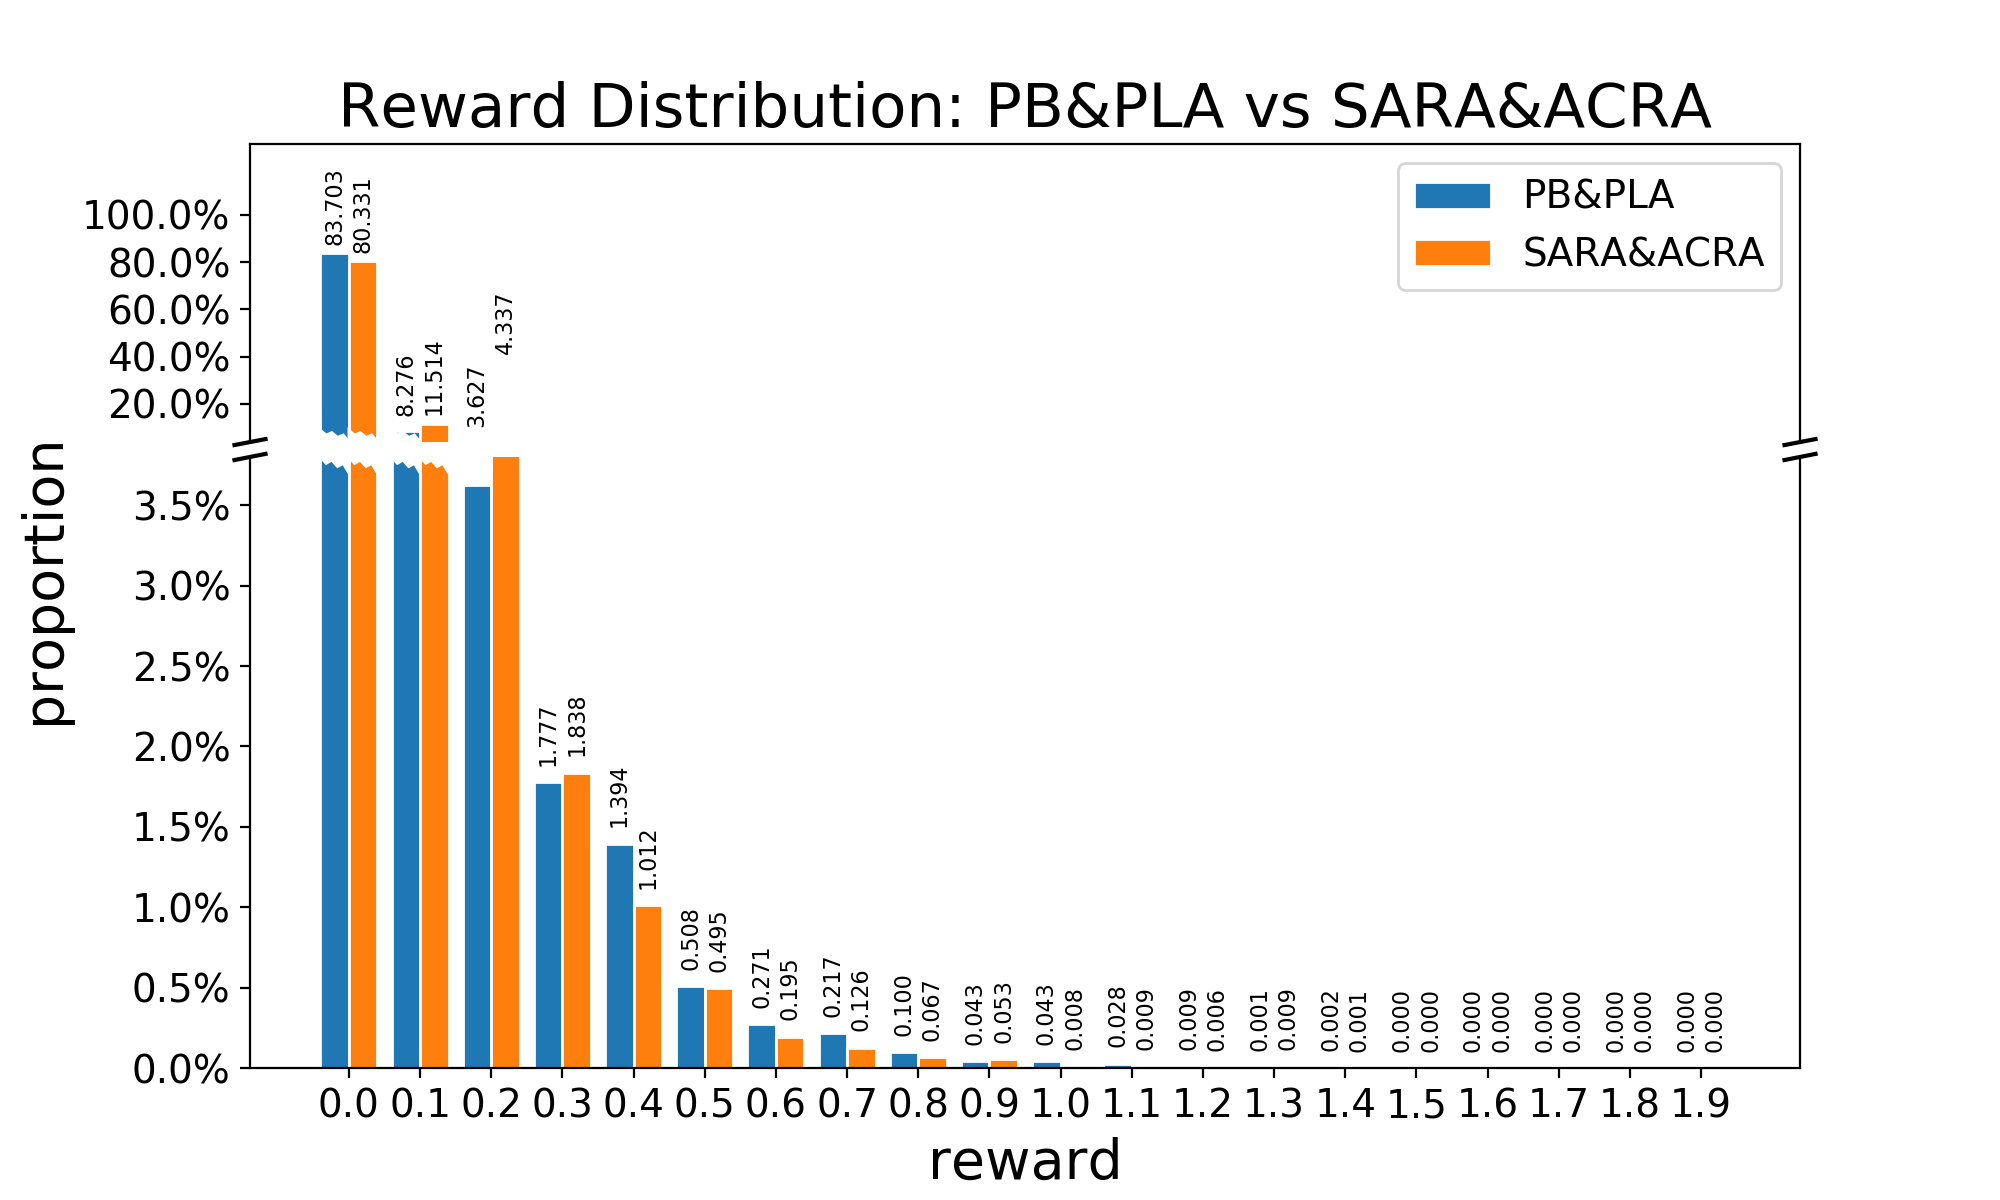

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [122]:
import matplotlib.gridspec as gridspec

def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    
    # set y-axis
    if behavior_name1=='PB':
        ax_y_min = 3.8
    else:
        ax_y_min = 3.8
    ax.set_ylim(ax_y_min, 130)  # outliers only
    ax2.set_ylim(0, ax_y_min)  # most of the data

    ax.set_yticks(np.arange(20, 105, 20))
    ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
    ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
    ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
    # set x-axis
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    d = .01
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

    ax.get_xaxis().set_visible(False)
    ax2.set_xticks(np.arange(reward_low, reward_up,0.1))

    

    # add proportion text
    rotation = 90
    fontsize=8
    if reward_low ==0:
        text_x_ax = [0, 0.1]
    else:
        text_x_ax = []
    for i in range(len(text_x_ax)):
        ax.text(text_x_ax[i]-binWidth/2, percentage_pb[i]+20, '{0:.3f}'.format(percentage_pb[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        ax.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+20, '{0:.3f}'.format(percentage_pla[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
    
    if behavior_name1=='PB':
        shift = 0.3
    else:
        shift = 0.3
    text_x_ax2 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    for i in range(len(text_x_ax2)):
        if behavior_name1!='PB' and i==0:
            tmp_shift = 20
            ax.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+tmp_shift, 
                    '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        else:
            ax2.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+shift, 
                    '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

        ax2.text(text_x_ax2[i]+binWidth/2, percentage_pla[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

    # add broken wave to ax
    ax_bins=[0, 0.1]
    wave_high = 5
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax_bins:
        if i == 0.1 and behavior_name1!='PB':
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth,ax_y_min+wave_high],
                                       [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)
        else:
            if i==0.1:
                break
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth,ax_y_min+wave_high],
                                       [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)
            tmp_polygon = plt.Polygon([[i,ax_y_min],
                                       [i,ax_y_min+wave_high],
                                       [i+binWidth*1/5, ax_y_min+wave_high*3/5],
                                       [i+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i+binWidth,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)    
    
    # add broken wave to ax2
    ax2_bins=[0, 0.1, 0.2]
    wave_high = 0.1
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax2_bins:
        if behavior_name1!='PB' and i==0.2:
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i,ax_y_min-wave_high],
                                       [i,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
        else:
            if i==0.2:
                break
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i,ax_y_min-wave_high],
                                       [i,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
            tmp_polygon = plt.Polygon([[i,ax_y_min],
                                       [i+binWidth*1/5, ax_y_min-wave_high*2/5],
                                       [i+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i+binWidth,ax_y_min-wave_high],
                                       [i+binWidth,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
                                   

    ax.set_title('Reward Distribution: {} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
    ax2.set_xlabel('reward', fontsize=20)
    ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
    ax2.yaxis.set_label_coords(-0.15,0.8)
    fig.tight_layout()
    plt.savefig('./figures/plot_reward_distribution_in_range_0_2_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)

    
plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0, reward_up = 2)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0, reward_up = 2)

plot_reward_distribution(PB_PLA, SARA_ACRA, 
                         behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
                         reward_low = 0, reward_up = 2)
    

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


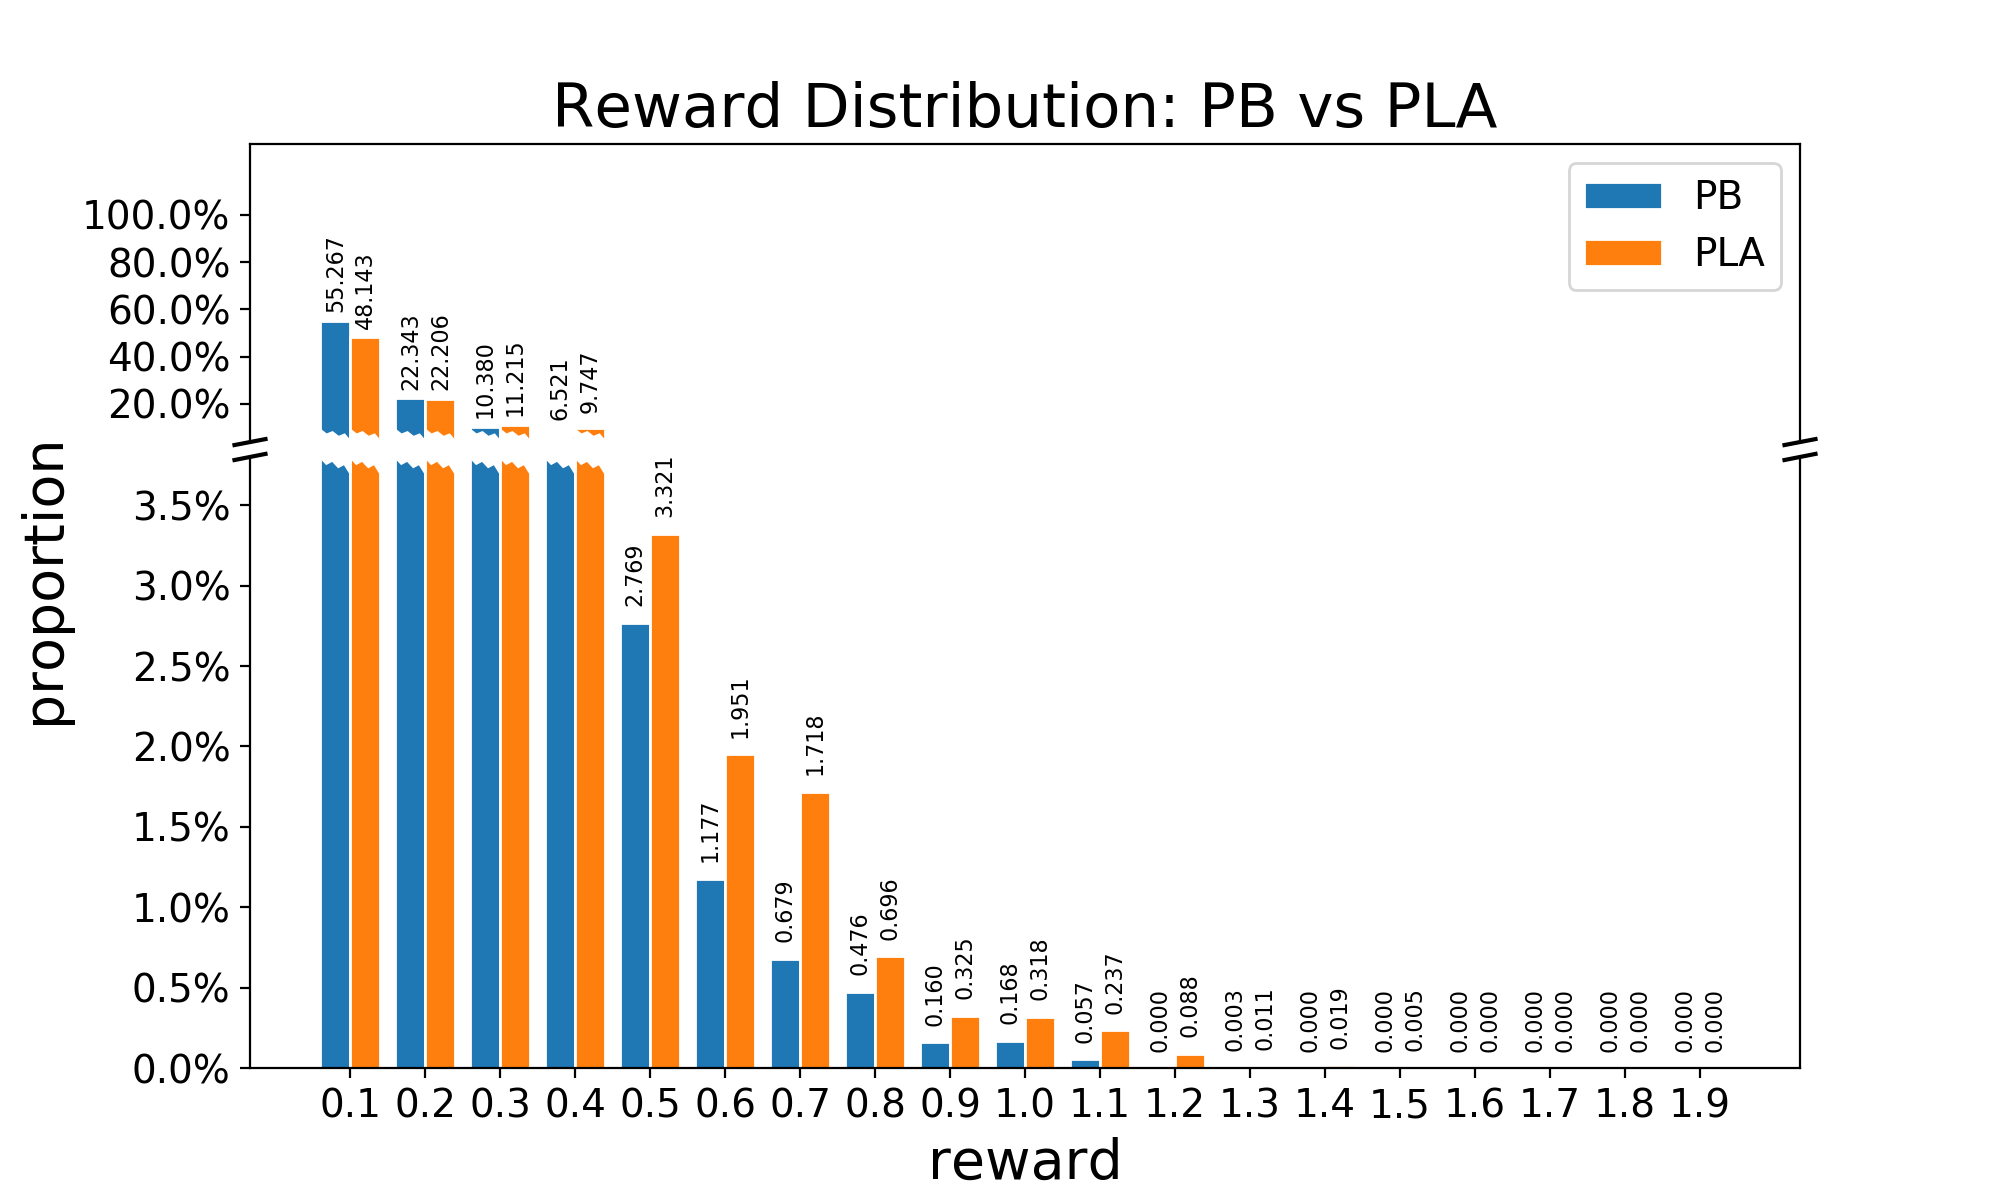

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


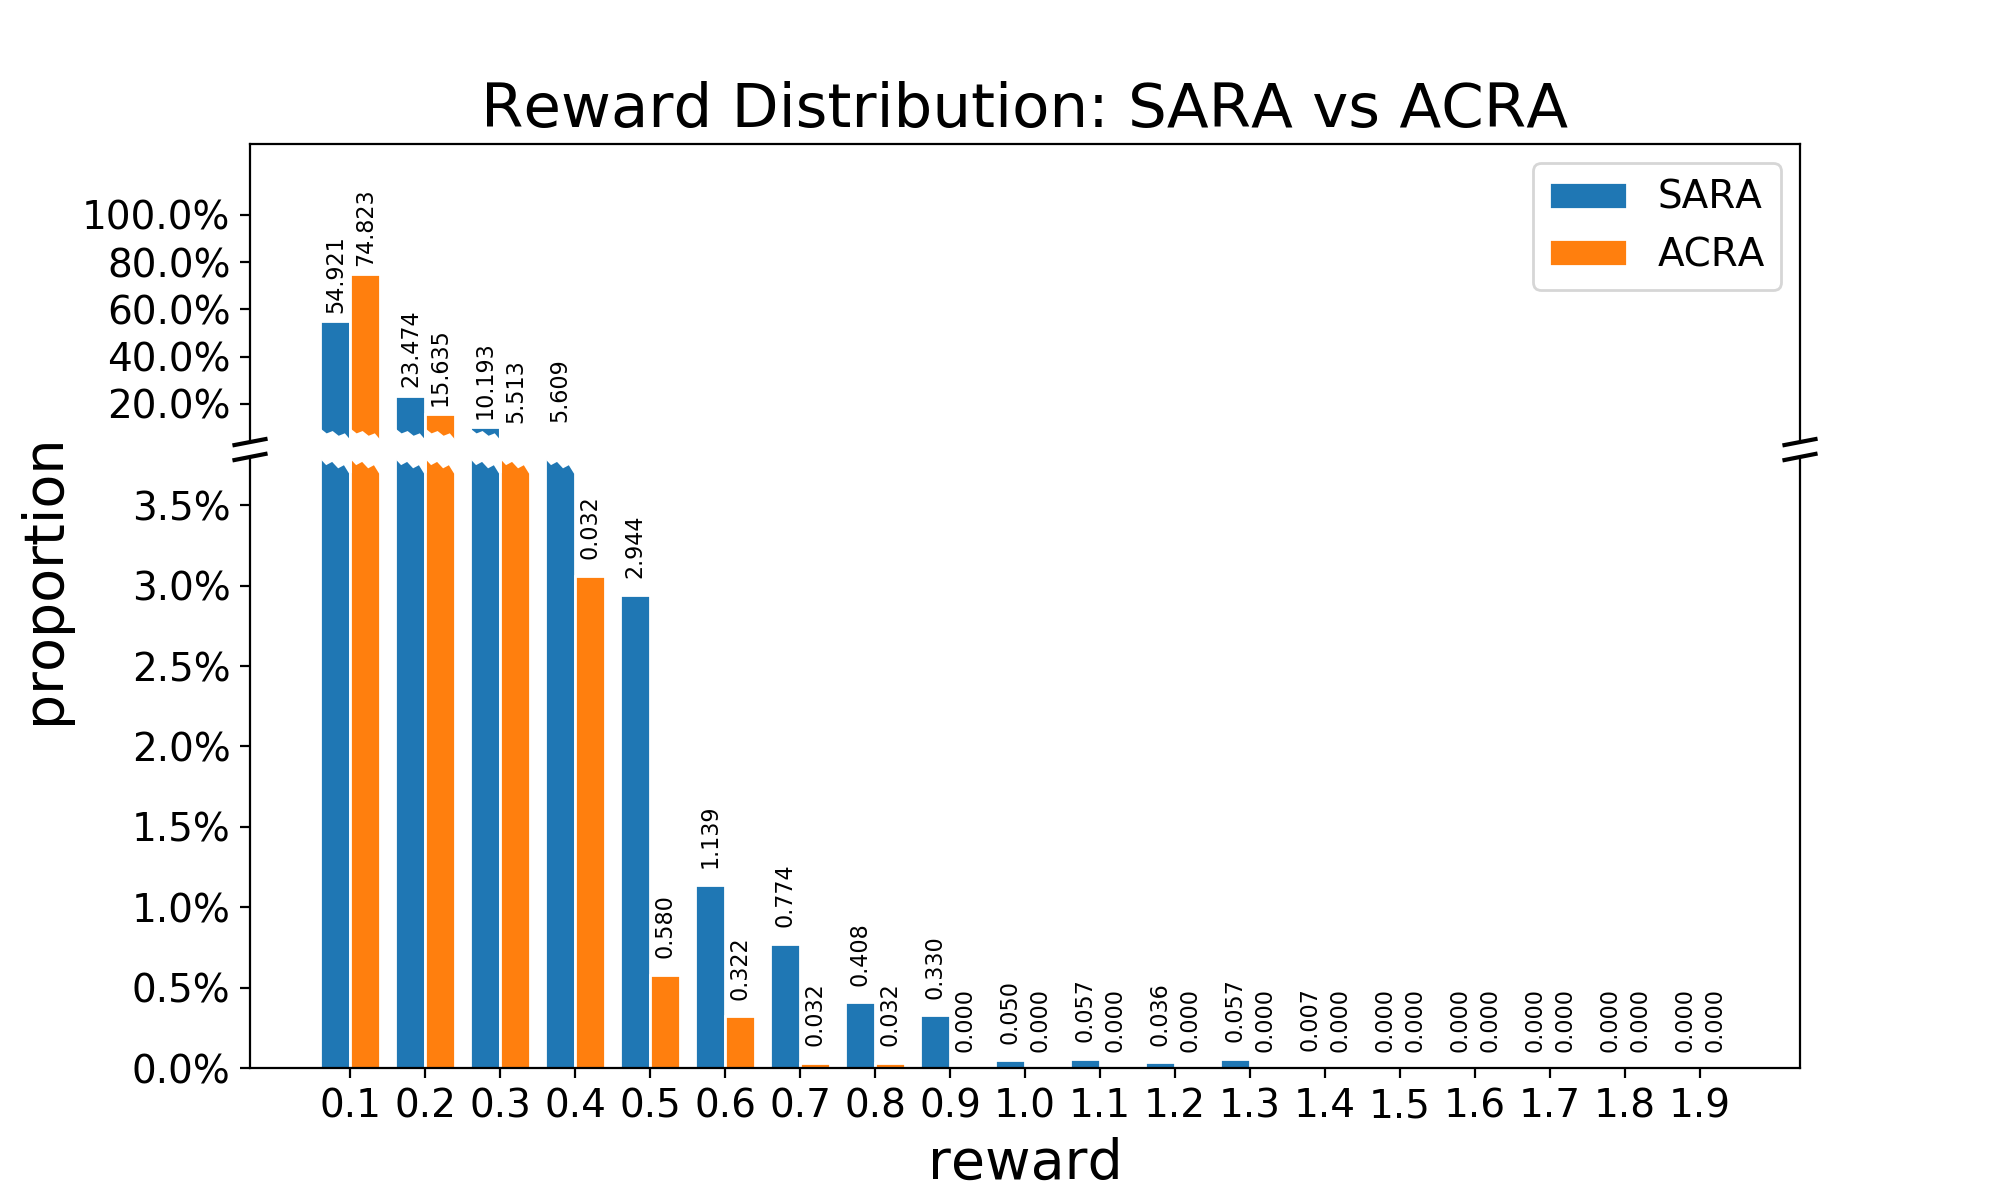

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


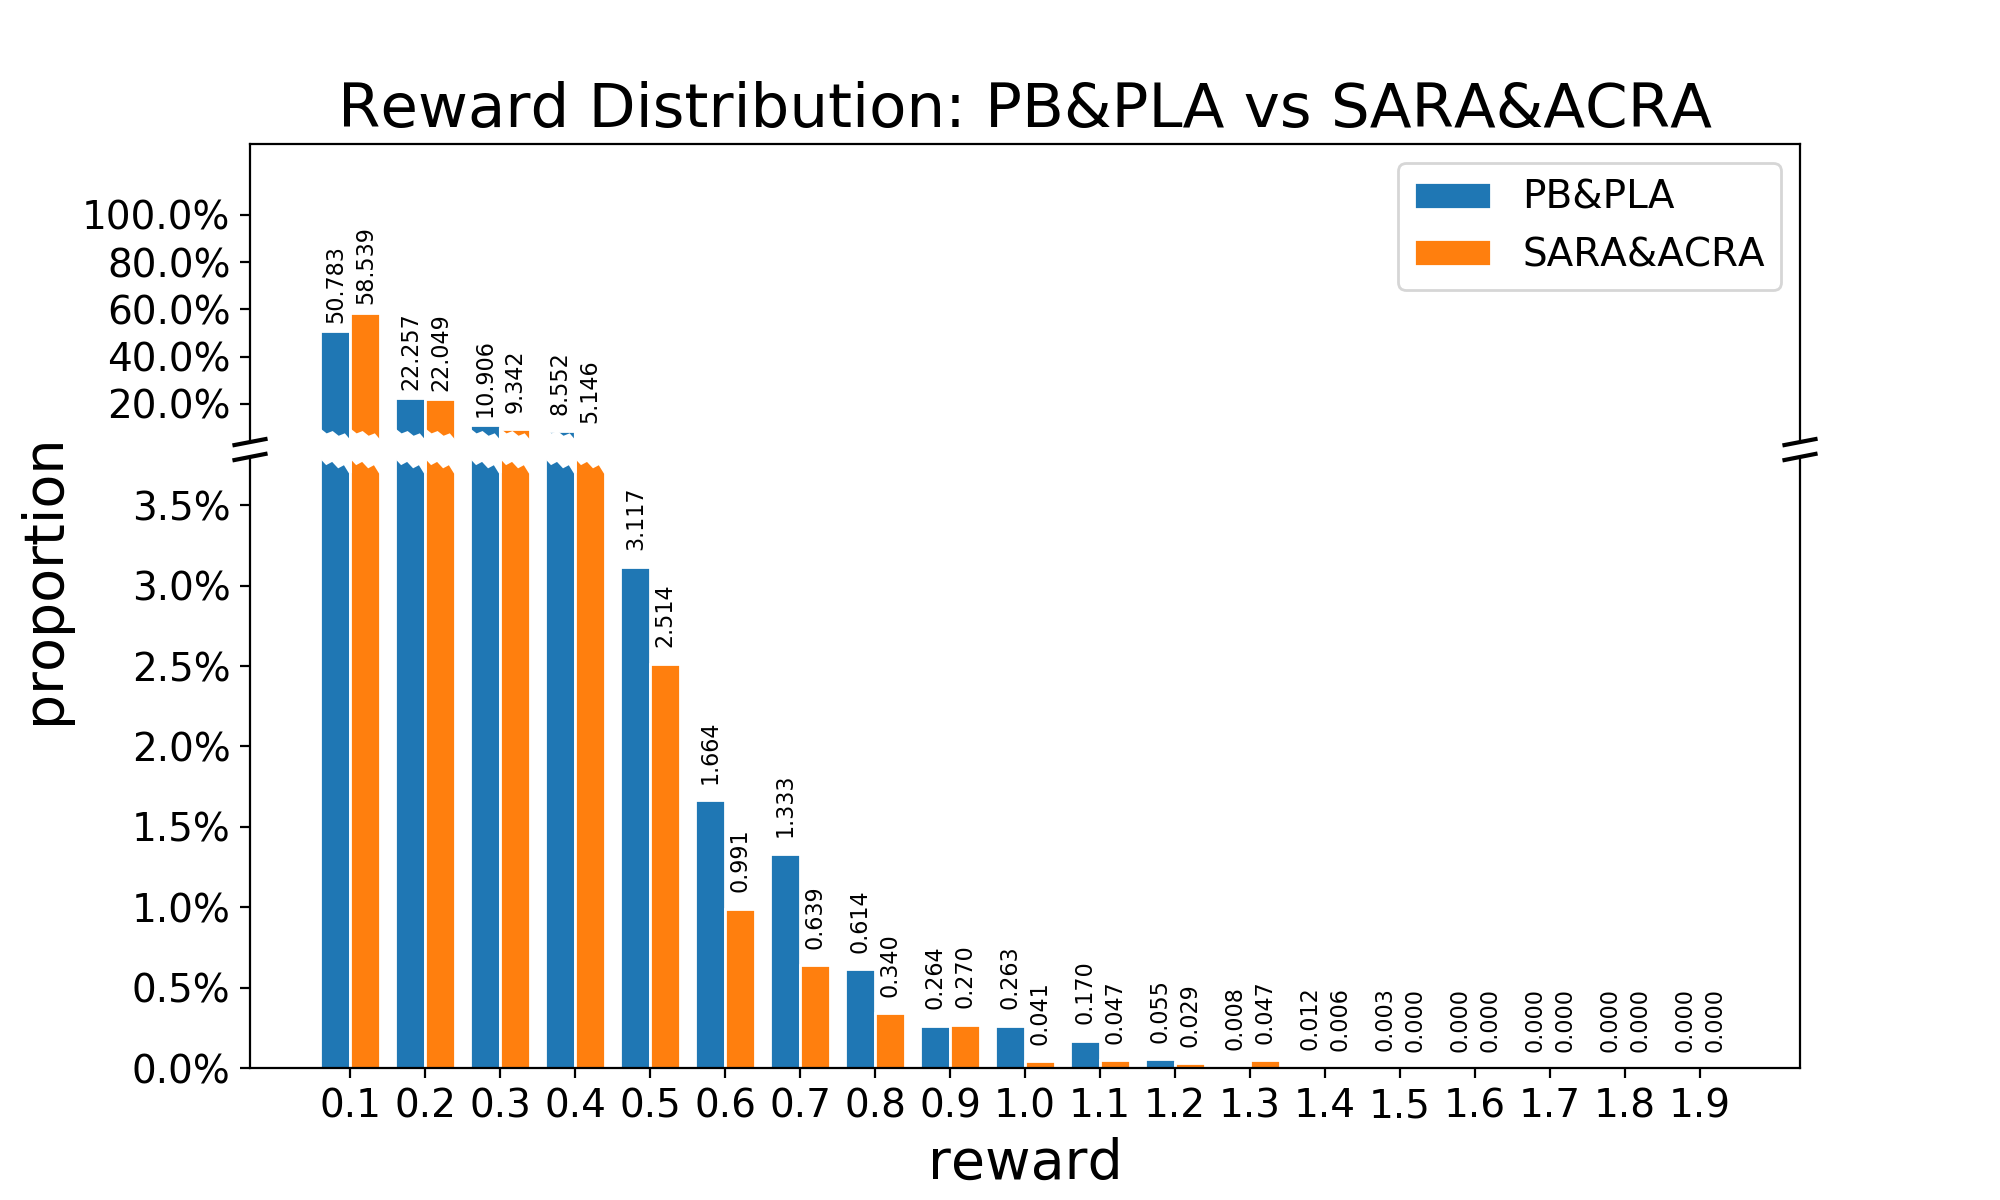

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [138]:
def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    
    # set y-axis
    if behavior_name1=='PB':
        ax_y_min = 3.8
    else:
        ax_y_min = 3.8
    ax.set_ylim(ax_y_min, 130)  # outliers only
    ax2.set_ylim(0, ax_y_min)  # most of the data

    ax.set_yticks(np.arange(20, 105, 20))
    ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
    ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
    ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
    # set x-axis
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    d = .01
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

    ax.get_xaxis().set_visible(False)
    ax2.set_xticks(np.arange(reward_low, reward_up,0.1))

    

    # add proportion text
    rotation = 90
    fontsize=8
    if reward_low ==0:
        text_x_ax = [0, 0.1]
    else:
        text_x_ax = [0.1, 0.2, 0.3, 0.4]
    for i in range(len(text_x_ax)):
        ax.text(text_x_ax[i]-binWidth/2, percentage_pb[i]+20, '{0:.3f}'.format(percentage_pb[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        if behavior_name1=='SARA' and i==3:
            ax2.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+0.3, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+20, '{0:.3f}'.format(percentage_pla[i]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
    
    if behavior_name1=='PB':
        shift = 0.3
    else:
        shift = 0.3
    text_x_ax2 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    
    for i in range(len(text_x_ax2)):
#         if behavior_name1=='SARA' and i==3:
#             tmp_shift = 20
#             ax.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+tmp_shift, 
#                     '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
#                     rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
#         else:
        ax2.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        
        ax2.text(text_x_ax2[i]+binWidth/2, percentage_pla[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

    # add broken wave to ax
    ax_bins=[0.1, 0.2, 0.3, 0.4]
    wave_high = 5
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax_bins:
        tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                   [i-binWidth,ax_y_min+wave_high],
                                   [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                   [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                   [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                   [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                   [i,ax_y_min]], 
                                  color='white')
        ax.add_patch(tmp_polygon)
        tmp_polygon = plt.Polygon([[i,ax_y_min],
                                   [i,ax_y_min+wave_high],
                                   [i+binWidth*1/5, ax_y_min+wave_high*3/5],
                                   [i+binWidth*2/5, ax_y_min+wave_high*4/5],
                                   [i+binWidth*3/5, ax_y_min+wave_high*2/5],
                                   [i+binWidth*4/5, ax_y_min+wave_high*3/5],
                                   [i+binWidth,ax_y_min]], 
                                  color='white')
        ax.add_patch(tmp_polygon)    
    
    # add broken wave to ax2
    ax2_bins=[0.1, 0.2, 0.3, 0.4]
    wave_high = 0.1
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax2_bins:
        tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                   [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                   [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                   [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                   [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                   [i,ax_y_min-wave_high],
                                   [i,ax_y_min]], 
                                  color='white')
        ax2.add_patch(tmp_polygon)
        tmp_polygon = plt.Polygon([[i,ax_y_min],
                                   [i+binWidth*1/5, ax_y_min-wave_high*2/5],
                                   [i+binWidth*2/5, ax_y_min-wave_high*1/5],
                                   [i+binWidth*3/5, ax_y_min-wave_high*3/5],
                                   [i+binWidth*4/5, ax_y_min-wave_high*2/5],
                                   [i+binWidth,ax_y_min-wave_high],
                                   [i+binWidth,ax_y_min]], 
                                  color='white')
        ax2.add_patch(tmp_polygon)
                                   

    ax.set_title('Reward Distribution: {} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
    ax2.set_xlabel('reward', fontsize=20)
    ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
    ax2.yaxis.set_label_coords(-0.15,0.8)
    fig.tight_layout()
    plt.savefig('./figures/plot_reward_distribution_in_range_0_1_2_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)


plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(PB_PLA, SARA_ACRA, 
                         behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
                         reward_low = 0.1, reward_up = 2)

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


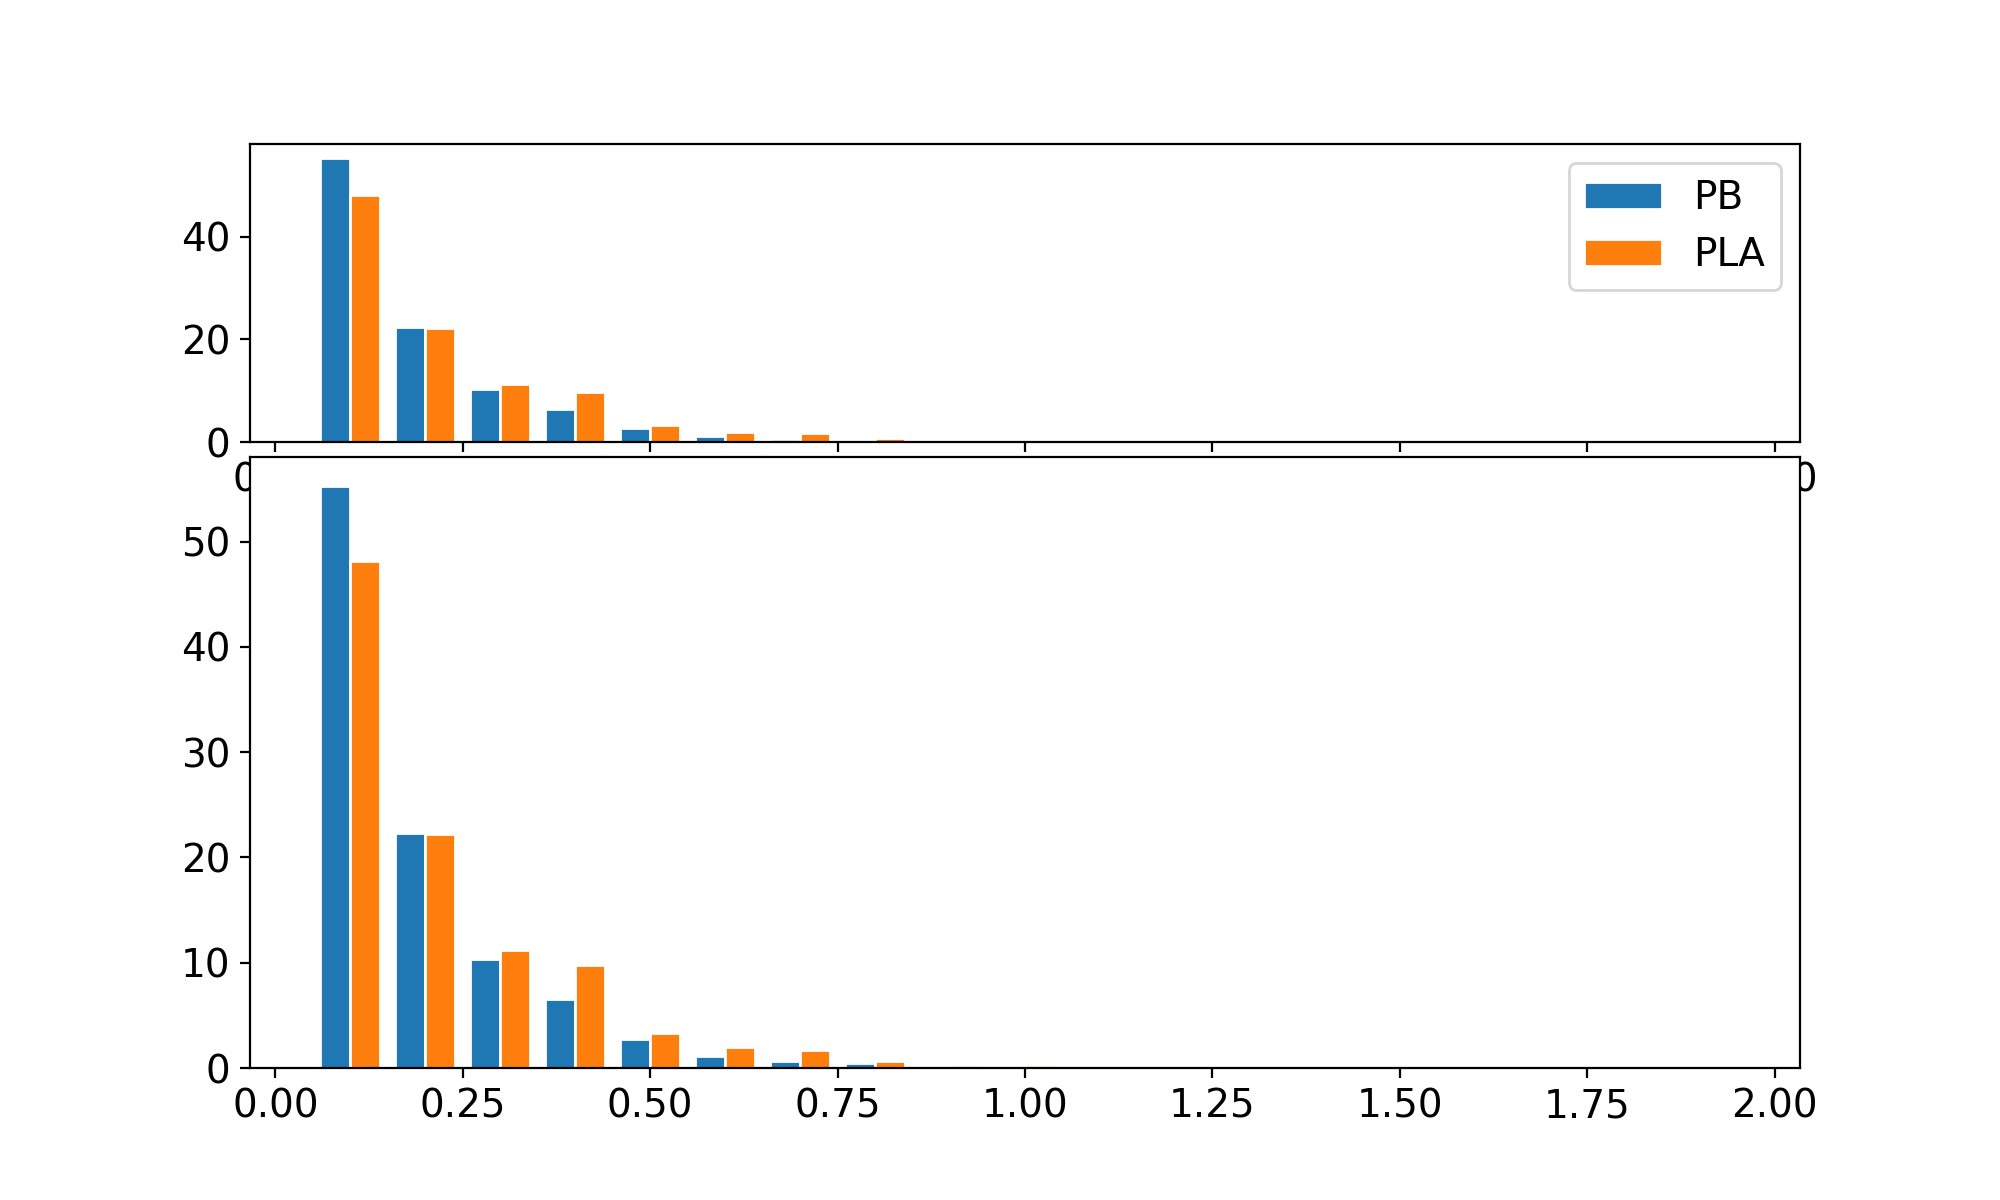

<IPython.core.display.Javascript object>


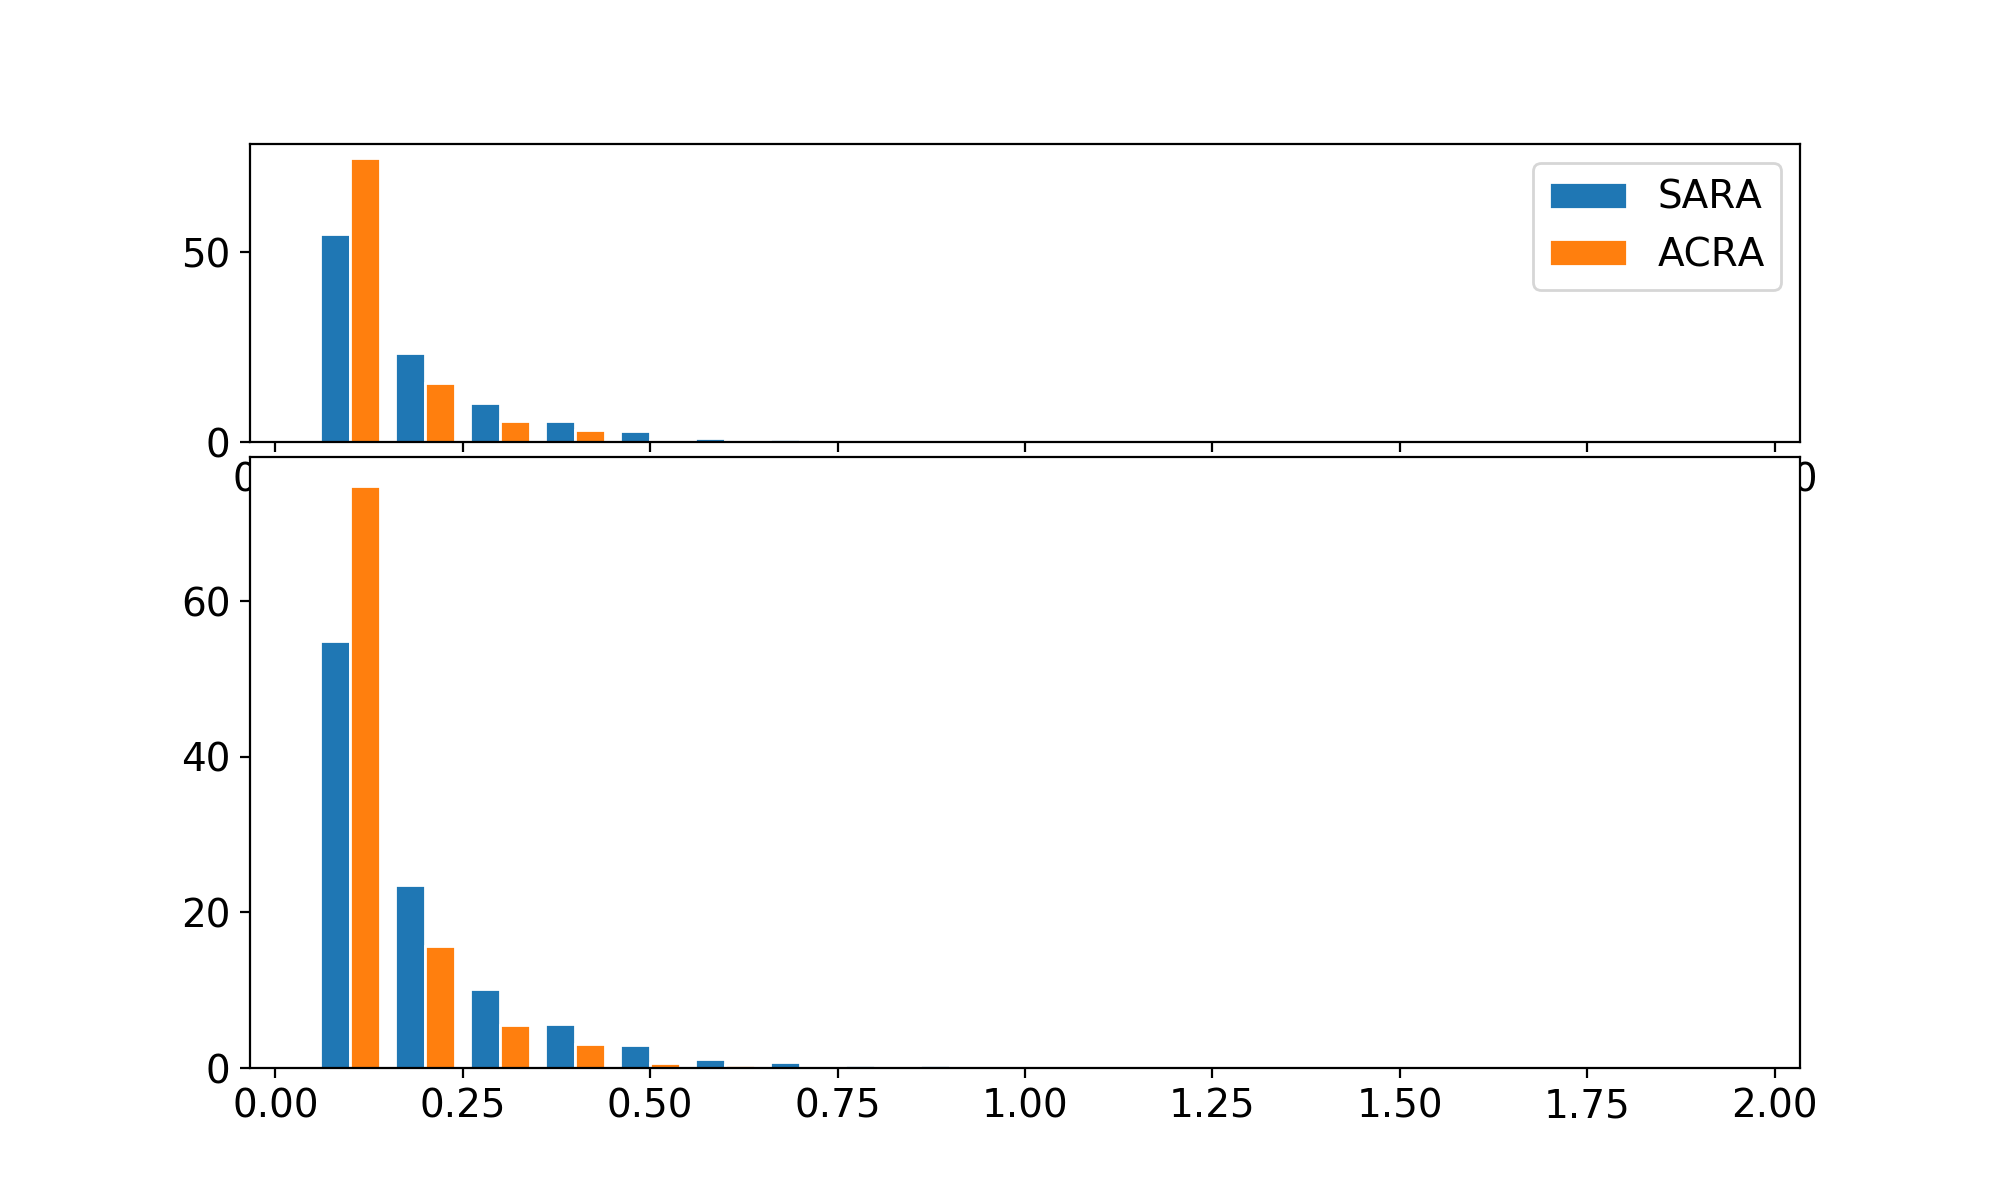

<IPython.core.display.Javascript object>


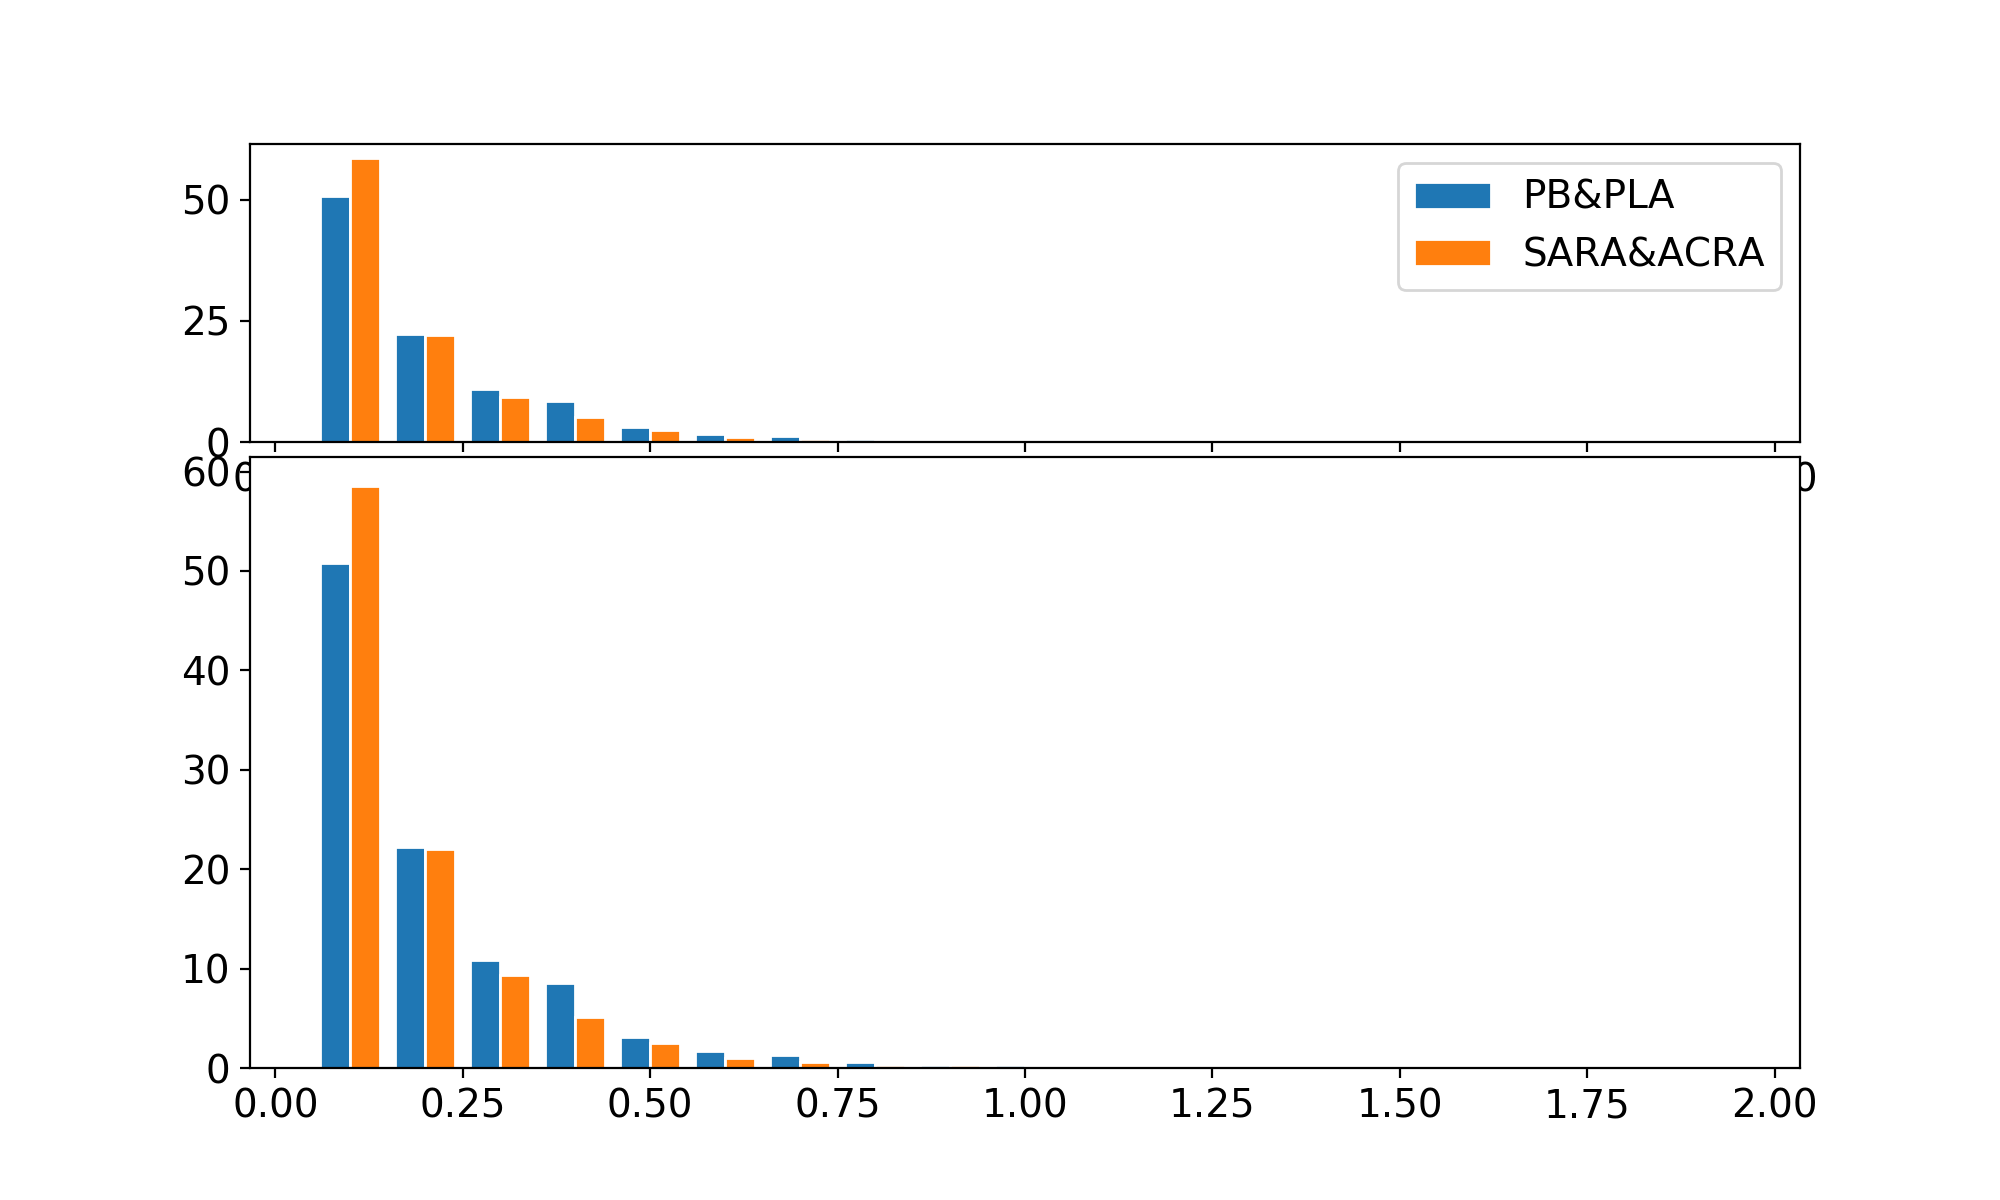

In [109]:

def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0.1, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    
#     # set y-axis
#     if behavior_name1=='PB':
#         ax_y_min = 3.8
#     else:
#         ax_y_min = 3.8
#     ax.set_ylim(ax_y_min, 130)  # outliers only
#     ax2.set_ylim(0, ax_y_min)  # most of the data

#     ax.set_yticks(np.arange(20, 105, 20))
#     ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
#     ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
#     ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
#     # set x-axis
#     ax.spines['bottom'].set_visible(False)
#     ax2.spines['top'].set_visible(False)

#     d = .01  # how big to make the diagonal lines in axes coordinates
#     # arguments to pass to plot, just so we don't keep repeating them
#     kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#     ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
#     ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

#     d = .01
#     kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#     ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
#     ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

#     ax.get_xaxis().set_visible(False)
#     ax2.set_xticks(np.arange(reward_low, reward_up,0.1))

    

#     # add proportion text
#     rotation = 90
#     fontsize=8
#     text_x_ax = [0, 0.1]
#     for i in range(len(text_x_ax)):
#         ax.text(text_x_ax[i]-binWidth/2, percentage_pb[i]+20, '{0:.3f}'.format(percentage_pb[i]), 
#                 rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
#         ax.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+20, '{0:.3f}'.format(percentage_pla[i]), 
#                 rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
    
#     if behavior_name1=='PB':
#         shift = 0.3
#     else:
#         shift = 0.3
#     text_x_ax2 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
#     for i in range(len(text_x_ax2)):
#         if behavior_name1!='PB' and i==0:
#             tmp_shift = 20
#             ax.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+tmp_shift, 
#                     '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
#                     rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
#         else:
#             ax2.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+shift, 
#                     '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
#                     rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

#         ax2.text(text_x_ax2[i]+binWidth/2, percentage_pla[i+len(text_x_ax)]+shift, 
#                 '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
#                 rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

#     # add broken wave to ax
#     ax_bins=[0, 0.1]
#     wave_high = 5
#     wave_start = i-binWidth
#     wave_end = i+binWidth
#     for i in ax_bins:
#         if i == 0.1 and behavior_name1!='PB':
#             tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
#                                        [i-binWidth,ax_y_min+wave_high],
#                                        [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
#                                        [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
#                                        [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
#                                        [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
#                                        [i,ax_y_min]], 
#                                       color='white')
#             ax.add_patch(tmp_polygon)
#         else:
#             if i==0.1:
#                 break
#             tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
#                                        [i-binWidth,ax_y_min+wave_high],
#                                        [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
#                                        [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
#                                        [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
#                                        [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
#                                        [i,ax_y_min]], 
#                                       color='white')
#             ax.add_patch(tmp_polygon)
#             tmp_polygon = plt.Polygon([[i,ax_y_min],
#                                        [i,ax_y_min+wave_high],
#                                        [i+binWidth*1/5, ax_y_min+wave_high*3/5],
#                                        [i+binWidth*2/5, ax_y_min+wave_high*4/5],
#                                        [i+binWidth*3/5, ax_y_min+wave_high*2/5],
#                                        [i+binWidth*4/5, ax_y_min+wave_high*3/5],
#                                        [i+binWidth,ax_y_min]], 
#                                       color='white')
#             ax.add_patch(tmp_polygon)    
    
#     # add broken wave to ax2
#     ax2_bins=[0, 0.1, 0.2]
#     wave_high = 0.1
#     wave_start = i-binWidth
#     wave_end = i+binWidth
#     for i in ax2_bins:
#         if behavior_name1!='PB' and i==0.2:
#             tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
#                                        [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
#                                        [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
#                                        [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
#                                        [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
#                                        [i,ax_y_min-wave_high],
#                                        [i,ax_y_min]], 
#                                       color='white')
#             ax2.add_patch(tmp_polygon)
#         else:
#             if i==0.2:
#                 break
#             tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
#                                        [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
#                                        [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
#                                        [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
#                                        [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
#                                        [i,ax_y_min-wave_high],
#                                        [i,ax_y_min]], 
#                                       color='white')
#             ax2.add_patch(tmp_polygon)
#             tmp_polygon = plt.Polygon([[i,ax_y_min],
#                                        [i+binWidth*1/5, ax_y_min-wave_high*2/5],
#                                        [i+binWidth*2/5, ax_y_min-wave_high*1/5],
#                                        [i+binWidth*3/5, ax_y_min-wave_high*3/5],
#                                        [i+binWidth*4/5, ax_y_min-wave_high*2/5],
#                                        [i+binWidth,ax_y_min-wave_high],
#                                        [i+binWidth,ax_y_min]], 
#                                       color='white')
#             ax2.add_patch(tmp_polygon)
                                   

#     ax.set_title('Reward Distribution: {} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
#     ax2.set_xlabel('reward', fontsize=20)
#     ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
#     ax2.yaxis.set_label_coords(-0.15,0.8)
#     fig.tight_layout()
#     plt.savefig('./figures/plot_reward_distribution_in_range_0_2_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)





plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(PB_PLA, SARA_ACRA, 
                         behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
                         reward_low = 0.1, reward_up = 2)


# Pisson Regression
**Assumption:**
1. we assume that the dependent variable is not over-dispersed and does not have an excessive number of zeros

**Response Variable:**
1. \# of activation interaction within a time window with size of 5 minutes

**Explanatory Variable:**
1. Behavior Mode:
   * 0: PB (Priscript Behavior (or Prescribed Behavior))
   * 1: PLA (Parameterized Learning Agent)
   * 2: SARA (Single Agent Raw Act)
   * 3: ACRA (Agent Community Raw Act)
2. Day:
   * 5: Fri. Sep. 14
   * 1: Mon. Sep. 17
   * 2: Tue. Sep. 18
   * 3: Wed. Sep. 19
   * 4: Thu. Sep. 20
   * 5: Fri. Sep. 21
   * 1: Mon. Sep. 24
   * 2: Tue. Sep. 25
   * 3: Wed. Sep. 26
   * 4: Thu. Sep. 27
   * 5: Fri. Sep. 28
   * 2: Tue. Oct. 02
   * 3: Wed. Oct. 03
   * 5: Fri. Oct. 05
3. Time:(There are days run one hour and a half)
   * 1: 13:00:00-13:30:00
   * 2: 13:30:01-14:00:00
   * 3: 14:00:00-14:29:59
   * 4: 14:30:00-14:59:59
   * 5: 15:00:00-15:29:59
   * 6: 15:30:00-15:59:59
  
**Reference:**
1. https://stats.idre.ucla.edu/stata/output/poisson-regression/
2. http://www.statsmodels.org/dev/glm.html#
3. https://medium.com/tencent-thailand/intro-to-poisson-regression-22fb33918839


In [25]:
prescribed_behavior
para_learning_agent
single_agent_raw_act
agent_coummunity_raw_act.keys()

dict_keys(['data', 'separate_line', 'date'])

In [26]:
prescribed_behavior['data'].columns[1:25]

Index(['IR1-1', 'IR1-2', 'IR2-1', 'IR2-2', 'IR3-1', 'IR3-2', 'IR4-1', 'IR4-2',
       'IR5-1', 'IR5-2', 'IR6-1', 'IR6-2', 'IR7-1', 'IR7-2', 'IR8-1', 'IR8-2',
       'IR9-1', 'IR9-2', 'IR10-1', 'IR10-2', 'IR11-1', 'IR11-2', 'IR12-1',
       'IR12-2'],
      dtype='object')

Should we test IR reading rather than reward for active interaction?

In [27]:
def add_explanatory_variable_columns(data, 
                                     behavior_mode='PB', 
                                     time_window=5,
                                     IR_reading_based_counting = False,
                                     active_interaction_reward_threshold=0.5,
                                     active_interaction_IR_threshold=0.1):
    """
    Add date code, time code, behavior code for each row.
    
    Args:
        data (dict):
            data['data']:
            data['separate_line']:
            data['date']:
        behavior_mode (str):
            1. 'PB'
            2. 'PLA'
            3. 'SARA'
            4. 'ACRA'
        time_window (int): minutes
        IR_reading_based_counting (bool): default = False
            if True, based on IR reading; Otherwise, based on reward.
        active_interaction_reward_threshold (float): default=0.5,
        active_interaction_IR_threshold  (float): default=0.1
    """
    date_code = {'2018-09-14':5,
                 '2018-09-17':1, '2018-09-18':2, '2018-09-19':3, '2018-09-20':4, '2018-09-21':5,
                 '2018-09-24':1, '2018-09-25':2, '2018-09-26':3, '2018-09-27':4, '2018-09-28':5,
                 '2018-10-02':2, '2018-10-03':3, '2018-10-05':5}
#     date_code = {'2018-09-14':0,
#                  '2018-09-17':1, '2018-09-18':2, '2018-09-19':3, '2018-09-20':4, '2018-09-21':5,
#                  '2018-09-24':6, '2018-09-25':7, '2018-09-26':8, '2018-09-27':9, '2018-09-28':10,
#                  '2018-10-02':11, '2018-10-03':12, '2018-10-05':13}
    time_code = {'1': ['13:00:00', '13:29:59'],
                 '2': ['13:30:00', '13:59:59'],
                 '3': ['14:00:00', '14:29:59'],
                 '4': ['14:30:00', '14:59:59'],
                 '5': ['15:00:00', '15:29:59'], 
                 '6': ['15:30:00', '15:59:59']}
    behavior_code = {'PB': 0, 'PLA': 1, 'SARA': 2, 'ACRA': 3}
    
    explanatory_vars = {'behavior_code':[], 
                        'date_code':[], 
                        'time_code':[], 
                        'active_interaction_count':[],
                        'total_interaction_count':[],
                        'date':[]}
    # datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    
    day_separate_line = list(data['separate_line'])
    day_separate_line.insert(0, 0)
    day_num = len(day_separate_line)-1
    print('Behavior: {}, total_days={}'.format(behavior_mode, day_num))
    
    for day_i in range(day_num):
        # get start and end index of a day
        day_start_index = day_separate_line[day_i]
        day_end_index = day_separate_line[day_i+1]-1
        #print('day {}: day_start_index={}, day_end_index={}'.format(day_i+1, day_start_index, day_end_index))
        
        # get start and end time of a day
        day_start_time = datetime.strptime(data['data'].iloc[day_start_index]['timestamp'], datetime_format)
        day_end_time = datetime.strptime(data['data'].iloc[day_end_index]['timestamp'], datetime_format)
        print('day {}: day_start_time={}, day_end_time={}'.format(day_i+1, day_start_time, day_end_time))
        
        # get time window
        stop_time_series = []
        for i in range(day_start_index, day_end_index):
            sensor_reading = data['data'].iloc[i]
            time = datetime.strptime(sensor_reading['timestamp'], datetime_format)
            if i == day_start_index:
                stop_time = time+timedelta(minutes=time_window-1, seconds=59)
                #print('stop_time={}'.format(stop_time.strftime("%Y-%m-%d %H:%M:%S.%f")))
                stop_time_series.append(stop_time)
            elif time >= stop_time_series[len(stop_time_series)-1]:
                stop_time = time+timedelta(minutes=time_window)
                if stop_time>day_end_time:
                    stop_time = day_end_time
                #print('stop_time={}'.format(stop_time.strftime("%Y-%m-%d %H:%M:%S.%f")))
                stop_time_series.append(stop_time)
        
        # count within a time window
        active_interaction_count = 0
        total_interaction_count = 0
        time_window_count = 0
        for i in range(day_start_index, day_end_index+1):
            
            sensor_reading = data['data'].iloc[i]
            time = datetime.strptime(sensor_reading['timestamp'], datetime_format) 
#             import pdb
#             pdb.set_trace()
            
            if time <= stop_time_series[time_window_count]:
                if IR_reading_based_counting == True:
                    for IR in sensor_reading.index[1:25]:
                        if sensor_reading[IR] >= active_interaction_IR_threshold:
                            active_interaction_count += 1
                    total_interaction_count += 1
                else:
                    if sensor_reading['reward_IR_distance'] >= active_interaction_reward_threshold:
                        active_interaction_count += 1
                    total_interaction_count += 1
            
            if time > stop_time_series[time_window_count] or time == day_end_time:
                #i = i-1
                sensor_reading = data['data'].iloc[i-1]
                time = datetime.strptime(sensor_reading['timestamp'], datetime_format)
                #print('stop_time_series[time_window_count]={}, time={}'.format(stop_time_series[time_window_count], time))
                
                bc_tmp = behavior_code[behavior_mode]
                dc_tmp = date_code[time.strftime("%Y-%m-%d")]
                tc_tmp = -1
                for k in time_code.keys():
                    if time_code[k][0]<=time.strftime("%H:%M:%S") and time.strftime("%H:%M:%S")<=time_code[k][1]:
                        tc_tmp = int(k)
                if tc_tmp == -1:
                    print('No time code for {}'.format(time))
                
                explanatory_vars['behavior_code'].append(bc_tmp)
                explanatory_vars['date_code'].append(dc_tmp)
                explanatory_vars['time_code'].append(tc_tmp)
                explanatory_vars['date'].append(time.strftime("%Y-%m-%d"))

                explanatory_vars['active_interaction_count'].append(active_interaction_count)
                explanatory_vars['total_interaction_count'].append(total_interaction_count)
                
                # reset
                time_window_count = time_window_count+1
                active_interaction_count = 0
                total_interaction_count = 0
    
    return pd.DataFrame(explanatory_vars)


time_window=5 # minutes
IR_reading_based_counting = True#True#False
active_interaction_reward_threshold=0.5
active_interaction_IR_threshold = 0.25#0.2

add_explanatory_variables_PB = add_explanatory_variable_columns(prescribed_behavior, 
                                                                'PB', 
                                                                time_window, 
                                                                IR_reading_based_counting,
                                                                active_interaction_reward_threshold,
                                                                active_interaction_IR_threshold)
add_explanatory_variables_PLA = add_explanatory_variable_columns(para_learning_agent,
                                                                 'PLA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)

add_explanatory_variables_SARA = add_explanatory_variable_columns(single_agent_raw_act,
                                                                 'SARA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)

add_explanatory_variables_ACRA = add_explanatory_variable_columns(agent_coummunity_raw_act,
                                                                 'ACRA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)



Behavior: PB, total_days=14
day 1: day_start_time=2018-09-14 14:30:00.071998, day_end_time=2018-09-14 15:59:59.899390
day 2: day_start_time=2018-09-17 15:00:00.072148, day_end_time=2018-09-17 15:59:59.867383
day 3: day_start_time=2018-09-18 14:30:00.047061, day_end_time=2018-09-18 15:59:59.982582
day 4: day_start_time=2018-09-19 14:30:00.013349, day_end_time=2018-09-19 15:59:59.932554
day 5: day_start_time=2018-09-20 13:02:22.916799, day_end_time=2018-09-20 13:59:59.794765
day 6: day_start_time=2018-09-21 14:00:00.074933, day_end_time=2018-09-21 14:59:59.969794
day 7: day_start_time=2018-09-24 14:00:02.075400, day_end_time=2018-09-24 14:59:59.777977
day 8: day_start_time=2018-09-25 13:00:00.008425, day_end_time=2018-09-25 13:59:59.850318
day 9: day_start_time=2018-09-26 14:00:00.082711, day_end_time=2018-09-26 14:59:59.854474
day 10: day_start_time=2018-09-27 13:00:00.046482, day_end_time=2018-09-27 13:59:59.954526
day 11: day_start_time=2018-09-28 13:00:00.038597, day_end_time=2018-09

In [28]:
len(add_explanatory_variables_PB)

186

In [29]:
len(add_explanatory_variables_PLA)

179

## Plot active interaction count: PB vs PLA and SARA vs ACRA

In [30]:
def combine_active_interaction_count(add_explanatory_variables_PB, add_explanatory_variables_PLA):
    dates = ['2018-09-14',
             '2018-09-17','2018-09-18','2018-09-19','2018-09-20','2018-09-21',
             '2018-09-24','2018-09-25','2018-09-26','2018-09-27','2018-09-28',
             '2018-10-02','2018-10-03','2018-10-05']
    combined_count = pd.DataFrame()
    combined_count_separate_line_day = [0]
    combined_count_separate_line_behavior = [0]
    combined_count_dates = ['']
    
    for date in dates:
        #print('Combining data on {}'.format(date))
        PB = add_explanatory_variables_PB.loc[add_explanatory_variables_PB['date'] == date]
        PB.reset_index(drop=True,inplace=True)
        PLA = add_explanatory_variables_PLA.loc[add_explanatory_variables_PLA['date'] == date]
        PLA.reset_index(drop=True,inplace=True)

        if len(PB)!=0 and len(PLA)!=0:
            if PB['time_code'][0]<PLA['time_code'][0]:
                combined_count = pd.concat([combined_count, PB])
                combined_count_separate_line_behavior.append(len(combined_count))
                combined_count = pd.concat([combined_count, PLA])
                combined_count_separate_line_behavior.append(len(combined_count))
            else:
                combined_count = pd.concat([combined_count, PLA])
                combined_count_separate_line_behavior.append(len(combined_count))
                combined_count = pd.concat([combined_count, PB])
                combined_count_separate_line_behavior.append(len(combined_count))
        elif len(PB)==0:
            combined_count = pd.concat([combined_count, PLA])
            combined_count_separate_line_behavior.append(len(combined_count))
        elif len(PLA)==0:
            combined_count = pd.concat([combined_count, PB])
            combined_count_separate_line_behavior.append(len(combined_count))
        else:
            pass
        
        if not (len(PB)==0 and len(PLA)==0):
            combined_count_separate_line_day.append(len(combined_count))
            combined_count_dates.append(date)
        
    return combined_count, combined_count_separate_line_day, combined_count_separate_line_behavior, combined_count_dates

PB_PLA_combined_count,\
PB_PLA_combined_count_separate_line_day,\
PB_PLA_combined_count_separate_line_behavior,\
PB_PLA_combined_count_dates = combine_active_interaction_count(add_explanatory_variables_PB, add_explanatory_variables_PLA)

SARA_ACRA_combined_count,\
SARA_ACRA_combined_count_separate_line_day,\
SARA_ACRA_combined_count_separate_line_behavior,\
SARA_ACRA_combined_count_dates = combine_active_interaction_count(add_explanatory_variables_SARA, add_explanatory_variables_ACRA)


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


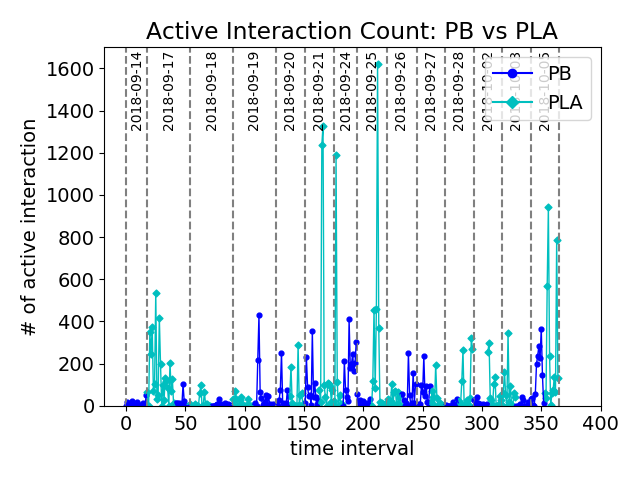

<IPython.core.display.Javascript object>


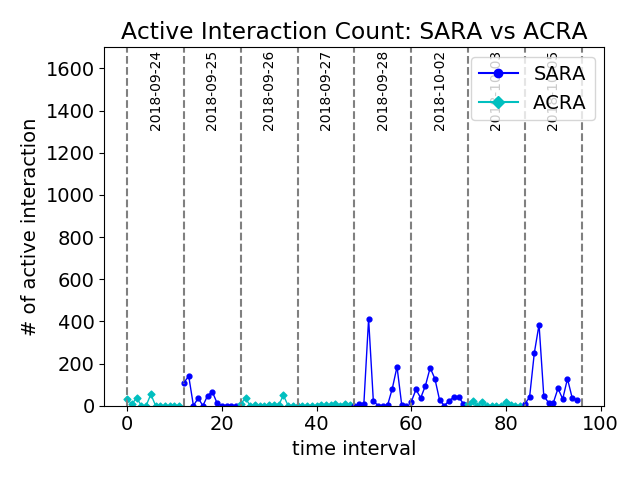

In [31]:
from matplotlib.lines import Line2D

def plot_active_interactionn_count(combined_count, 
                                   combined_count_separate_line_day, 
                                   combined_count_separate_line_behavior,
                                   combined_count_dates,
                                   behavior1 = 'PB',
                                   behavior2 = 'PLA'):

    combined_count.reset_index(drop=True,inplace=True)
    plt.figure()
    colors = ['b', 'c', 'b', 'c']
    marker_style = ['o','D', 'o','D']
    
    # plot active_count scatter
    for i in range(len(combined_count)):
        plt.scatter(i, combined_count['active_interaction_count'][i], 
                    color=colors[combined_count['behavior_code'][i]],
                    marker=marker_style[combined_count['behavior_code'][i]],
                    s = 12)
    
    # add vertical line separate each day
    for i, x in enumerate(combined_count_separate_line_day): 
#         if x == 0:
#             continue
        plt.axvline(x=x, linestyle='--', color='grey')
        
        plt.text(x=np.floor((x+combined_count_separate_line_day[i-1])/2), y=1500, 
                 s=combined_count_dates[i], fontsize='10',
                 rotation=90,
                 verticalalignment='center',horizontalalignment='center')
    
    # plot line for each behavior
    for i, x in enumerate(combined_count_separate_line_behavior):
        if x == 0:
            continue
        plt.plot(combined_count['active_interaction_count'][combined_count_separate_line_behavior[i-1]:x],
                 color=colors[combined_count['behavior_code'][x-1]],
                 linestyle='-', linewidth=1)
        
    plt.ylim(0,1700)
    plt.xlabel('time interval')
    plt.ylabel('# of active interaction')
    if behavior1 == 'PB':
        plt.xticks(np.arange(0, 401, 50))
    else:
        plt.xticks(np.arange(0, 101, 20))
        
    plt.title('Active Interaction Count: {} vs {}'.format(behavior1, behavior2))
    legend_elements = [Line2D([0], [0], marker='o', color='b', label=behavior1, markersize=6),
                       Line2D([0], [0], marker='D', color='c', label=behavior2, markersize=6)]
    plt.legend(handles=legend_elements)
    plt.tight_layout()
    plt.savefig('./figures/active_interaction_count_based_on_IR_{}_{}.png'.format(behavior1, behavior2), dpi=300)
    
plot_active_interactionn_count(PB_PLA_combined_count, 
                               PB_PLA_combined_count_separate_line_day, 
                               PB_PLA_combined_count_separate_line_behavior,
                               PB_PLA_combined_count_dates, 
                               'PB', 'PLA')

plot_active_interactionn_count(SARA_ACRA_combined_count, 
                               SARA_ACRA_combined_count_separate_line_day, 
                               SARA_ACRA_combined_count_separate_line_behavior,
                               SARA_ACRA_combined_count_dates, 
                               'SARA', 'ACRA')


## Pisson Regression: PB and PLA

In [90]:
def generate_explanatory_variables(add_explanatory_variables_PB, add_explanatory_variables_PLA):
    separate_line_PB_PLA = len(add_explanatory_variables_PB)
    explanatory_var_PB_PLA = pd.concat([add_explanatory_variables_PB, add_explanatory_variables_PLA])
    explanatory_var_PB_PLA.columns

    date_code_dummies = pd.get_dummies(explanatory_var_PB_PLA['date_code']).rename(columns=lambda x: 'Date_Code_' + str(x))
    time_code_dummies = pd.get_dummies(explanatory_var_PB_PLA['time_code']).rename(columns=lambda x: 'Time_Code_' + str(x))

    #X_With_Dummies = pd.concat([explanatory_var_PB_PLA['behavior_code'], date_code_dummies, time_code_dummies], axis=1)
    X_With_Dummies = pd.concat([explanatory_var_PB_PLA['behavior_code']], axis=1)
    X_With_Dummies.applymap(np.int)
    print('Explanatory Variable: {}'.format(X_With_Dummies.columns))
    X = X_With_Dummies.values
    X = sm.add_constant(X, prepend=False) # add constant

    # Y = np.divide(explanatory_var_PB_PLA['active_interaction_count'].values, 
    #               explanatory_var_PB_PLA['total_interaction_count'].values)
    Y = explanatory_var_PB_PLA['active_interaction_count'].values

    print('X.shape=({}, {})'.format(X.shape[0],X.shape[1]))
    print('Y.shape=({}, {})'.format(Y.shape[0], ''))

    Offset = explanatory_var_PB_PLA['date_code'].values
    #Offset = explanatory_var_PB_PLA['time_code'].values
    return X, Y, Offset

X_PB_PLA, Y_PB_PLA, Offset_PB_PLA = generate_explanatory_variables(add_explanatory_variables_PB, 
                                                                   add_explanatory_variables_PLA)

X_SARA_ACRA, Y_SARA_ACRA, Offset_SARA_ACRA = generate_explanatory_variables(add_explanatory_variables_SARA, 
                                                                            add_explanatory_variables_ACRA)


Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(365, 2)
Y.shape=(365, )
Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(96, 2)
Y.shape=(96, )


In [91]:
# combine PB and PLA
add_explanatory_variables_PB_tmp = add_explanatory_variables_PB.copy()
add_explanatory_variables_PB_tmp['behavior_code'] = 0
add_explanatory_variables_PLA_tmp = add_explanatory_variables_PLA.copy()
add_explanatory_variables_PLA_tmp['behavior_code'] = 0
add_explanatory_variables_PB_PLA = pd.concat([add_explanatory_variables_PB_tmp, add_explanatory_variables_PLA_tmp])
add_explanatory_variables_PB_PLA.reset_index(drop=True,inplace=True)

# combine SARA and ACRA
add_explanatory_variables_SARA_tmp = add_explanatory_variables_SARA.copy()
add_explanatory_variables_SARA_tmp['behavior_code'] = 1
add_explanatory_variables_ACRA_tmp = add_explanatory_variables_ACRA.copy()
add_explanatory_variables_ACRA_tmp['behavior_code'] = 1
add_explanatory_variables_SARA_ACRA = pd.concat([add_explanatory_variables_SARA_tmp, add_explanatory_variables_ACRA_tmp])
add_explanatory_variables_SARA_ACRA.reset_index(drop=True,inplace=True)

X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA, Offset_PB_PLA_SARA_ACRA = generate_explanatory_variables(add_explanatory_variables_PB_PLA,
                                                                                                 add_explanatory_variables_SARA_ACRA)


Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(461, 2)
Y.shape=(461, )


### Delete 0 Count

In [92]:
def delete_zeros_in_explanatory_vars(X, Y, Offset, add_explanatory_variables_PB):
    zero_num = np.count_nonzero(Y==0)
    print('zeros: {}, total: {}'.format(zero_num, len(Y)))
    
    separate_line_PB_PLA = len(add_explanatory_variables_PB) - len(np.where( np.where(Y == 0)[0]< len(add_explanatory_variables_PB))[0])
    print('add_explanatory_variables_PB={}'.format(len(add_explanatory_variables_PB)))
    print('separate_line_PB_PLA={}'.format(separate_line_PB_PLA))
    
    X = np.delete(X, np.where(Y == 0), axis=0)
    Offset = np.delete(Offset, np.where(Y == 0))
    Y = np.delete(Y, np.where(Y == 0))
    
    return X, Y, separate_line_PB_PLA
    
X_PB_PLA, Y_PB_PLA, separate_line_PB_PLA = delete_zeros_in_explanatory_vars(X_PB_PLA, 
                                                                            Y_PB_PLA, 
                                                                            Offset_PB_PLA, 
                                                                            add_explanatory_variables_PB)

X_SARA_ACRA, Y_SARA_ACRA, separate_line_SARA_ACRA = delete_zeros_in_explanatory_vars(X_SARA_ACRA, 
                                                                                     Y_SARA_ACRA, 
                                                                                     Offset_SARA_ACRA, 
                                                                                     add_explanatory_variables_SARA)

X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA, separate_line_PB_PLA_SARA_ACRA = delete_zeros_in_explanatory_vars(X_PB_PLA_SARA_ACRA, 
                                                                                                          Y_PB_PLA_SARA_ACRA, 
                                                                                                          Offset_PB_PLA_SARA_ACRA, 
                                                                                                          add_explanatory_variables_PB_PLA)
    

zeros: 90, total: 365
add_explanatory_variables_PB=186
separate_line_PB_PLA=134
zeros: 31, total: 96
add_explanatory_variables_PB=48
separate_line_PB_PLA=40
zeros: 121, total: 461
add_explanatory_variables_PB=365
separate_line_PB_PLA=275


#### Poisson Regression: 
For interpret the results, please refer to https://stats.idre.ucla.edu/stata/output/poisson-regression/.

In [93]:
import statsmodels.api as sm
# building the model
def Poisson_Regression(X, Y):
    poisson_mod = sm.Poisson(Y, X)
    poisson_res = poisson_mod.fit(method="newton")
    print(poisson_res.summary2())
    

    # testing the model
    predVals = poisson_res.predict(X)
    print('Parameters: ', poisson_res.params)
    print('T-values: ', poisson_res.tvalues)
    print('poisson_res.scale={}'.format(poisson_res.scale))
    return predVals

print('Poisson Regression: PB and PLA')
predVals_PB_PLA = Poisson_Regression(X_PB_PLA, Y_PB_PLA)

print('**********************************************************************')

print('Poisson Regression: SARA and ACRA')
predVals_SARA_ACRA = Poisson_Regression(X_SARA_ACRA, Y_SARA_ACRA)

print('**********************************************************************')

print('Poisson Regression: SARA and ACRA')
predVals_PB_PLA_SARA_ACRA = Poisson_Regression(X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA)


Poisson Regression: PB and PLA
Optimization terminated successfully.
         Current function value: 95.102014
         Iterations 5
                        Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.068     
Dependent Variable: y                AIC:              52310.1074
Date:               2018-12-03 21:29 BIC:              52317.3410
No. Observations:   275              Log-Likelihood:   -26153.   
Df Model:           1                LL-Null:          -28058.   
Df Residuals:       273              LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
-------------------------------------------------------------------
x1          0.7819     0.0132    59.2726   0.0000   0.7561   0.8078
const       4.1195     0.

the variance of a Poisson distribution is equal to its mean, hence the scale parameter should be approximately equal 1 if the data follow a Poisson regression model. http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/ir0bnkup9rywmqd54zvm.ipynb

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


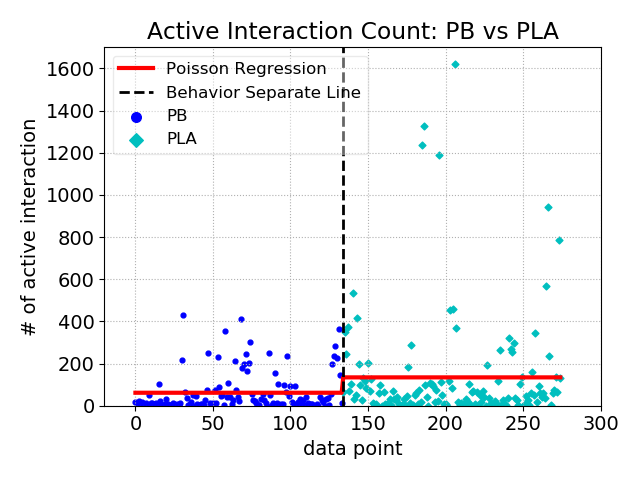

<IPython.core.display.Javascript object>


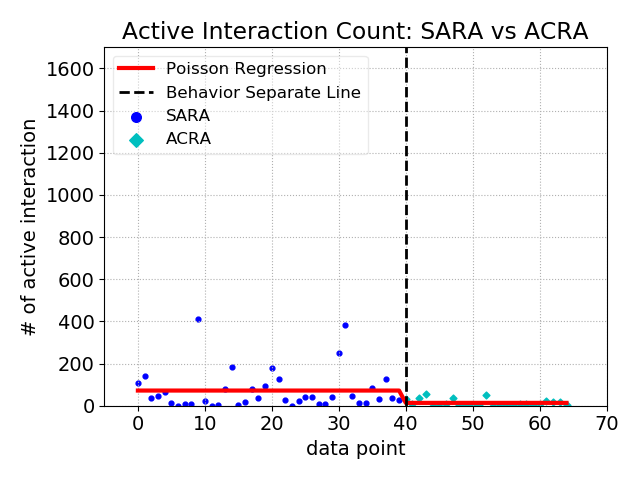

<IPython.core.display.Javascript object>


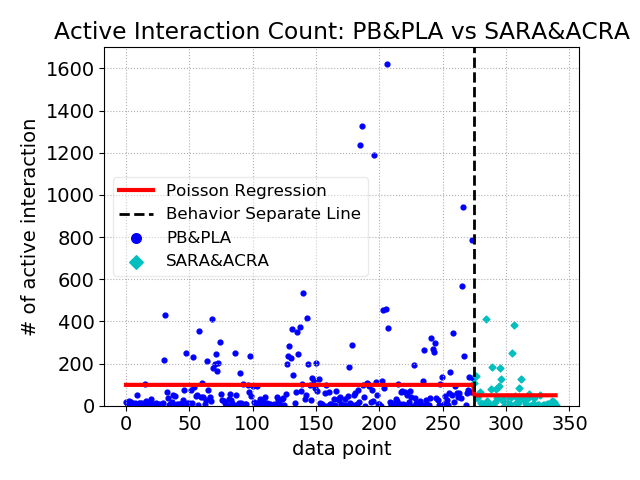

In [97]:
def plot_Poisson_Regression(Y, predVals, separate_line_PB_PLA, behavior1='PB', behavior2='PLA'):
    plt.figure()

    plt.scatter(range(separate_line_PB_PLA), Y[:separate_line_PB_PLA], c='b', marker='o', s = 12)
    plt.scatter(range(separate_line_PB_PLA,len(Y)), Y[separate_line_PB_PLA:], c='c', marker='D', s = 12)
    
    plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

    plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)

    plt.ylabel('# of active interaction')
    plt.xlabel('data point')
    if behavior1=='PB':
        plt.xlim(-20,300)
    elif behavior1=='SARA':
        plt.xlim(-5,70)
    else:
        pass
    plt.ylim(0,1700)
    plt.title('Active Interaction Count: {} vs {}'.format(behavior1, behavior2))
    plt.legend(['Poisson Regression', 'Behavior Separate Line', behavior1, behavior2],fontsize=12, markerscale=2, framealpha=0.4)
    plt.tight_layout()
    plt.grid(True, linestyle=':')
    plt.show()
    plt.savefig('./figures/Poisson_Regression_active_interaction_{}_{}.png'.format(behavior1, behavior2), dpi=300)

plot_Poisson_Regression(Y_PB_PLA, predVals_PB_PLA, separate_line_PB_PLA, 'PB', 'PLA')

plot_Poisson_Regression(Y_SARA_ACRA, predVals_SARA_ACRA, separate_line_SARA_ACRA, 'SARA', 'ACRA')

plot_Poisson_Regression(Y_PB_PLA_SARA_ACRA, predVals_PB_PLA_SARA_ACRA, separate_line_PB_PLA_SARA_ACRA, 'PB&PLA', 'SARA&ACRA')
    

In [38]:
predVals_PB_PLA[-1] - predVals_PB_PLA[0]

72.95241875727751

In [39]:
predVals_SARA_ACRA[-1] - predVals_SARA_ACRA[0]

-58.495000000000054

In [98]:
predVals_PB_PLA_SARA_ACRA[-1] - predVals_PB_PLA_SARA_ACRA[0]

-49.45762237762237

In [99]:
print('PB:{}, PLA:{}'.format(predVals_PB_PLA[0], predVals_PB_PLA[-1]))

PB:61.529850746268686, PLA:134.4822695035462


In [100]:
print('SARA:{}, ACRA:{}'.format(predVals_SARA_ACRA[0], predVals_SARA_ACRA[-1]))

SARA:71.97500000000005, ACRA:13.479999999999995


In [101]:
print('PB&PLA:{}, SARA&ACRA:{}'.format(predVals_PB_PLA_SARA_ACRA[0], predVals_PB_PLA_SARA_ACRA[-1]))

PB&PLA:98.93454545454546, SARA&ACRA:49.476923076923086


# ZeroInflatedPoisson Regression
from statsmodels.discrete.count_model import ZeroInflatedPoisson

# Occupancy

In [41]:
# occupancy_camera1_prescribed_behavior
# occupancy_camera1_para_learning_agent
# occupancy_camera1_single_agent_raw_act
# occupancy_camera1_agent_coummunity_raw_act

In [42]:
#pd.DataFrame(occupancy_camera1_prescribed_behavior['data'])
occupancy_camera1_prescribed_behavior.keys()

dict_keys(['data', 'separate_line', 'date'])

In [43]:

occupancy_camera1_prescribed_behavior['separate_line']
occupancy_camera1_prescribed_behavior['date']

['Sep_17_1500_1600',
 'Sep_18_1430_1600',
 'Sep_19_1430_1500',
 'Sep_19_1500_1600',
 'Sep_20_1300_1400',
 'Sep_21_1400_1500',
 'Sep_24_1400_1500',
 'Sep_25_1300_1400',
 'Sep_26_1400_1500',
 'Sep_27_1300_1400',
 'Sep_28_1300_1400',
 'Oct_02_1300_1400',
 'Oct_03_1500_1600',
 'Oct_05_1300_1400']

In [76]:
def combine_occupancy_of_comparable_behavior(occupancy_camera1_prescribed_behavior,
                                             occupancy_camera1_para_learning_agent):
    PB_occupancy = pd.DataFrame(occupancy_camera1_prescribed_behavior['data'])
    PB_occupancy.reset_index(drop=True,inplace=True)
    PB_occupancy['behavior_code'] = 0

    PLA_occupancy = pd.DataFrame(occupancy_camera1_para_learning_agent['data'])
    PLA_occupancy.reset_index(drop=True,inplace=True)
    PLA_occupancy['behavior_code'] = 1

    PB_PLA_occupancy_separate_line = len(PB_occupancy)
    PB_PLA_occupancy = pd.concat([PB_occupancy, PLA_occupancy])
    PB_PLA_occupancy.reset_index(drop=True,inplace=True)
    
    return PB_occupancy, PLA_occupancy, PB_PLA_occupancy, PB_PLA_occupancy_separate_line

PB_occupancy,\
PLA_occupancy,\
PB_PLA_occupancy,\
PB_PLA_occupancy_separate_line = combine_occupancy_of_comparable_behavior(occupancy_camera1_prescribed_behavior,
                                                                          occupancy_camera1_para_learning_agent)

SARA_occupancy,\
ACRA_occupancy,\
SARA_ACRA_occupancy,\
SARA_ACRA_occupancy_separate_line = combine_occupancy_of_comparable_behavior(occupancy_camera1_single_agent_raw_act,
                                                               occupancy_camera1_agent_coummunity_raw_act)
    

SARA_ACRA_occupancy.columns


Index(['Time', 'Occupancy', 'behavior_code'], dtype='object')

In [77]:
PB_PLA_occupancy_tmp = PB_PLA_occupancy.copy()
PB_PLA_occupancy_tmp['behavior_code']=0
SARA_ACRA_occupancy_tmp = SARA_ACRA_occupancy.copy()
SARA_ACRA_occupancy_tmp['behavior_code']=1
PBPLA_SARAACRA_occupancy_separate_line = len(PB_PLA_occupancy_tmp)
PBPLA_SARAACRA_occupancy = pd.concat([PB_PLA_occupancy_tmp, SARA_ACRA_occupancy_tmp])
PBPLA_SARAACRA_occupancy.reset_index(drop=True,inplace=True)
# PBPLA_SARAACRA_occupancy

In [79]:
def Poisson_Regression_on_occupancy_data(PB_PLA_occupancy, PB_occupancy):
    # generate X and Y
    X = PB_PLA_occupancy['behavior_code'].values
    X = sm.add_constant(X, prepend=False) # add constant

    Y = PB_PLA_occupancy['Occupancy'].values

    print('X.shape=({}, {})'.format(X.shape[0],X.shape[1]))
    print('Y.shape=({}, {})'.format(Y.shape[0], ''))

    zero_num = np.count_nonzero(Y==0)
    print('zeros: {}, total: {}'.format(zero_num, len(Y)))

    separate_line_PB_PLA = len(PB_occupancy) - len(np.where( np.where(Y == 0)[0]< len(PB_occupancy))[0])
    print('PB_occupancy={}'.format(len(PB_occupancy)))
    print('separate_line_PB_PLA={}'.format(separate_line_PB_PLA))

    X = np.delete(X, np.where(Y == 0), axis=0)
    Y = np.delete(Y, np.where(Y == 0))

    # fit Poisson Regression
    poisson_mod = sm.Poisson(Y, X)
    poisson_res = poisson_mod.fit(method="newton")
    print(poisson_res.summary2())

    # testing the model
    predVals = poisson_res.predict(X)
    print('Parameters: ', poisson_res.params)
    print('T-values: ', poisson_res.tvalues)
    print('poisson_res.scale={}'.format(poisson_res.scale))
    return X, Y, predVals, separate_line_PB_PLA

print('Occupancy Poisson Regression: PB and PLA')
PB_PLA_X_occupancy,\
PB_PLA_Y_occupancy,\
PB_PLA_predVals_occupancy,\
PB_PLA_occupancy_separate_line= Poisson_Regression_on_occupancy_data(PB_PLA_occupancy, PB_occupancy)

print('****************************************************************')

print('Occupancy Poisson Regression: SARA and ACRA')
SARA_ACRA_X_occupancy,\
SARA_ACRA_Y_occupancy,\
SARA_ACRA_predVals_occupancy,\
SARA_ACRA_occupancy_separate_line = Poisson_Regression_on_occupancy_data(SARA_ACRA_occupancy, SARA_occupancy)

print('****************************************************************')

print('Occupancy Poisson Regression: SARA and ACRA')
PBPLA_SARAACRA_X_occupancy,\
PBPLA_SARAACRA_Y_occupancy,\
PBPLA_SARAACRA_predVals_occupancy,\
PBPLA_SARAACRA_occupancy_separate_line = Poisson_Regression_on_occupancy_data(PBPLA_SARAACRA_occupancy, PB_PLA_occupancy)


Occupancy Poisson Regression: PB and PLA
X.shape=(749327, 2)
Y.shape=(749327, )
zeros: 111209, total: 749327
PB_occupancy=349776
separate_line_PB_PLA=298398
Optimization terminated successfully.
         Current function value: 2.299963
         Iterations 4
                         Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.000       
Dependent Variable: y                AIC:              2935299.1317
Date:               2018-12-03 21:08 BIC:              2935321.8643
No. Observations:   638118           Log-Likelihood:   -1.4676e+06 
Df Model:           1                LL-Null:          -1.4681e+06 
Df Residuals:       638116           LLR p-value:      1.0549e-200 
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     4.0000                                         
----------------------------------------------------------------------
         Coef.     Std.Err.        z        P>|z|     [0.025    0.975]
-------------

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


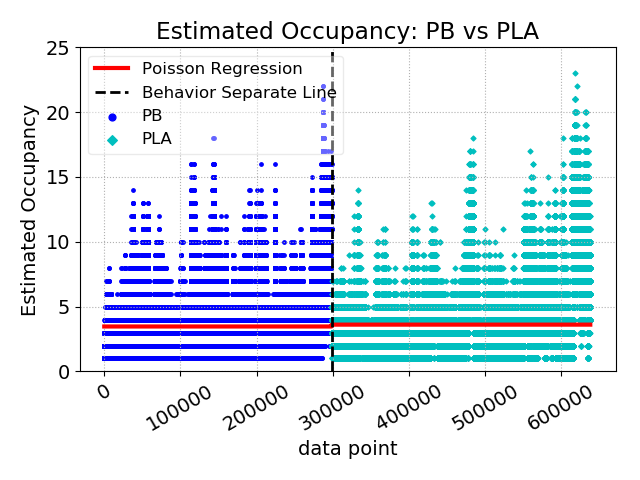

<IPython.core.display.Javascript object>


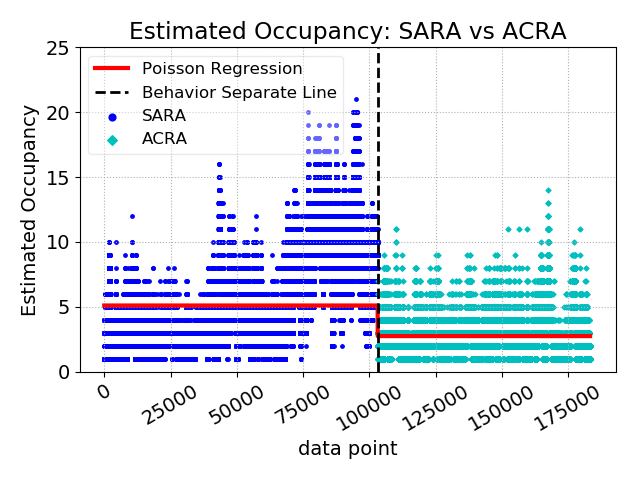

<IPython.core.display.Javascript object>


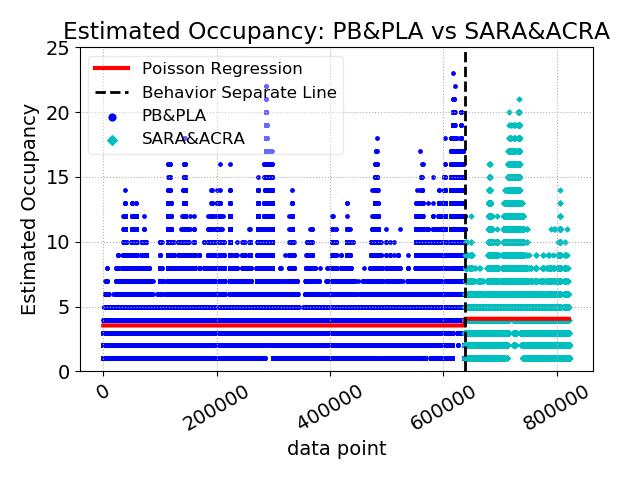

In [80]:

def plot_Poisson_Regression_On_Occupancy(Y, predVals, separate_line_PB_PLA, behavior1='PB', behavior2='PLA'):
    plt.figure()

    plt.scatter(range(separate_line_PB_PLA), Y[:separate_line_PB_PLA], c='b', marker='o', s = 6)
    plt.scatter(range(separate_line_PB_PLA,len(Y)), Y[separate_line_PB_PLA:], c='c', marker='D', s = 6)

    plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

    plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)

    plt.ylabel('Estimated Occupancy')
    plt.xlabel('data point')
    plt.xticks(rotation=30)
#     if behavior1=='PB':
#         plt.xlim(-20,300)
#     else:
#         plt.xlim(-5,70)
    plt.ylim(0,25)
    plt.title('Estimated Occupancy: {} vs {}'.format(behavior1, behavior2))
    plt.legend(['Poisson Regression', 'Behavior Separate Line', behavior1, behavior2],fontsize=12, markerscale=2, framealpha=0.4)
    plt.tight_layout()
    plt.grid(True, linestyle=':')
    plt.show()
    plt.savefig('./figures/Poisson_Regression_estimated_occupancy_{}_{}.png'.format(behavior1, behavior2), dpi=300)

plot_Poisson_Regression_On_Occupancy(PB_PLA_Y_occupancy, 
                                     PB_PLA_predVals_occupancy, 
                                     PB_PLA_occupancy_separate_line, 
                                     behavior1='PB', behavior2='PLA')

plot_Poisson_Regression_On_Occupancy(SARA_ACRA_Y_occupancy, 
                                     SARA_ACRA_predVals_occupancy, 
                                     SARA_ACRA_occupancy_separate_line, 
                                     behavior1='SARA', behavior2='ACRA')

plot_Poisson_Regression_On_Occupancy(PBPLA_SARAACRA_Y_occupancy, 
                                     PBPLA_SARAACRA_predVals_occupancy, 
                                     PBPLA_SARAACRA_occupancy_separate_line, 
                                     behavior1='PB&PLA', behavior2='SARA&ACRA')
    

In [49]:
PB_PLA_predVals_occupancy[-1]-PB_PLA_predVals_occupancy[0]

0.14270879142783555

In [50]:
SARA_ACRA_predVals_occupancy[-1]-SARA_ACRA_predVals_occupancy[0]

-2.3606773693403995

In [73]:
PBPLA_SARAACRA_predVals_occupancy[-1]-PBPLA_SARAACRA_predVals_occupancy[0]

0.5150364640110996

In [57]:
print('PB:{}, PLA:{}'.format(PB_PLA_predVals_occupancy[0],PB_PLA_predVals_occupancy[-1]))

PB:3.4684180188872373, PLA:3.611126810315073


In [58]:
print('SARA:{}, ACRA:{}'.format(SARA_ACRA_predVals_occupancy[0],SARA_ACRA_predVals_occupancy[-1]))

SARA:5.091761099038366, ACRA:2.7310837296979664


In [74]:
print('PB & PLA:{}, SARA & ACRA:{}'.format(PBPLA_SARAACRA_predVals_occupancy[0],PBPLA_SARAACRA_predVals_occupancy[-1]))

PB & PLA:3.544393043290968, SARA & ACRA:4.059429507302068


# Plot Schedule

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


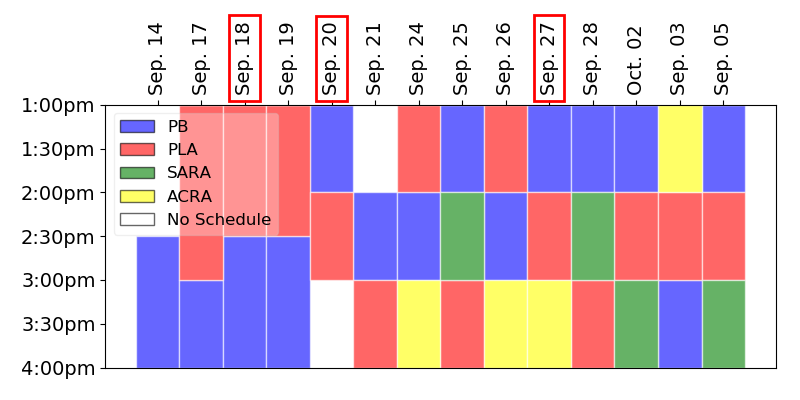

In [50]:
dates = ['Sep. 14', 
         'Sep. 17', 'Sep. 18', 'Sep. 19', 'Sep. 20', 'Sep. 21', 
         'Sep. 24', 'Sep. 25', 'Sep. 26', 'Sep. 27', 'Sep. 28', 
         'Oct. 02', 'Sep. 03','Sep. 05']
slots = ['1:00pm', '1:30pm', '2:00pm', '2:30pm', '3:00pm', '3:30pm', '4:00pm']


PB_time = [(3,3),
           (4,2),(3,3),(3,3),(0,2),(2,2),
           (2,2),(0,2),(2,2),(0,2),(0,2),
           (0,2),(4,2),(0,2)]
PLA_time = [(0,0),
            (0,4),(0,3),(0,3),(2,2),(4,2),
            (0,2),(4,2),(0,2),(2,2),(4,2),
            (2,2),(2,2),(2,2)]
SARA_time = [(0,0),
             (0,0),(0,0),(0,0),(0,0),(0,0),
             (0,0),(2,2),(0,0),(0,0),(2,2),
             (4,2),(0,0),(4,2)]
ACRA_time = [(0,0),
             (0,0),(0,0),(0,0),(0,0),(0,0),
             (4,2),(0,0),(4,2),(4,2),(0,0),
             (0,0),(0,2),(0,0)]

from matplotlib.patches import Patch
plt.figure(figsize=[8,4])

bar_w=1
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], PB_time[x], facecolors='blue',edgecolor='w',alpha=0.6)
    
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], PLA_time[x], facecolors='red',edgecolor='w',alpha=0.6)
    
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], SARA_time[x], facecolors='green',edgecolor='w',alpha=0.6)

for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], ACRA_time[x], facecolors='yellow',edgecolor='w',alpha=0.6)

plt.xticks(np.arange(len(dates)), dates, rotation=90)


plt.ylim(0,6)
plt.yticks(np.arange(0, 6.1, 1), slots)
# plt.xlabel('dates')
ax = plt.gca()
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticks_position('top')
# plt.ylabel('time')
plt.gca().invert_yaxis()
# plt.title('Experiment Schedule')
legend_elements = [Patch(facecolor='blue', edgecolor='k',alpha=0.6,label='PB'),
                   Patch(facecolor='red', edgecolor='k',alpha=0.6,label='PLA'),
                   Patch(facecolor='green', edgecolor='k',alpha=0.6,label='SARA'),
                   Patch(facecolor='yellow', edgecolor='k',alpha=0.6,label='ACRA'),
                   Patch(facecolor='white', edgecolor='k',alpha=0.6,label='No Schedule')]

plt.legend(handles=legend_elements, loc='upper left', framealpha=0.3, fontsize=12)

ax = plt.gca()
label = ax.xaxis.get_ticklabels()
label[2].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))
label[4].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))
label[9].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))



plt.tight_layout()
plt.savefig('./figures/plot_experiment_schedule.png', dpi=300)
# plt.grid(True, linestyle=':')


In [ ]:
PB_time[0]